# OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
# !pip install sweetviz

In [2]:
# !pip install more_itertools

In [3]:
# !pip install graphviz pydot 

In [ ]:
# !pip install plotly

In [18]:
# import desired libraries for preprocessing and model
import numpy as np          # linear algebra.
import pandas as pd         # data processing, CSV file I/O.
import seaborn as sns
import sweetviz as sv
import joblib
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Activation,Dropout, Concatenate, LSTM
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model
import more_itertools as mit
from sklearn.model_selection import train_test_split


In [19]:
# read CSV file as a dataFrame using pandas library
df = pd.read_csv('weather.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## WE SELLECT THE HIGHIEST CORRELATED FEATURES WITH TARGETS "M_WEATHER", and "M_RAIN_PERCENTAGE"

In [20]:
feature_config = sv.FeatureConfig(force_num=['M_PACKET_FORMAT', 'M_GAME_MAJOR_VERSION', 'M_GAME_MINOR_VERSION',
       'M_PACKET_VERSION', 'M_PACKET_ID', 'M_SESSION_UID', 'M_SESSION_TIME',
       'M_FRAME_IDENTIFIER', 'M_PLAYER_CAR_INDEX',
       'M_SECONDARY_PLAYER_CAR_INDEX', 'M_BRAKING_ASSIST',
       'M_SESSION_LINK_IDENTIFIER', 'M_PIT_RELEASE_ASSIST', 'TIMESTAMP',
       'M_ZONE_START', 'M_ZONE_FLAG', 'M_PIT_STOP_WINDOW_IDEAL_LAP',
       'M_TRACK_TEMPERATURE', 'M_TRACK_LENGTH', 'M_GAME_PAUSED',
       'M_FORECAST_ACCURACY', 'M_AIR_TEMPERATURE',
       'M_NUM_WEATHER_FORECAST_SAMPLES', 'M_SLI_PRO_NATIVE_SUPPORT',
       'M_SAFETY_CAR_STATUS', 'M_TRACK_ID', 'M_ERSASSIST', 'M_FORMULA',
       'M_SEASON_LINK_IDENTIFIER', 'M_PIT_ASSIST', 'M_GEARBOX_ASSIST',
       'M_SESSION_TYPE', 'M_SPECTATOR_CAR_INDEX',
       'M_PIT_STOP_WINDOW_LATEST_LAP', 'M_WEEKEND_LINK_IDENTIFIER',
       'M_DYNAMIC_RACING_LINE_TYPE', 'M_SESSION_TIME_LEFT',
       'M_SESSION_DURATION', 'M_PIT_STOP_REJOIN_POSITION',
       'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE', 'M_TIME_OFFSET',
       'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
       'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
       'M_TRACK_TEMPERATURE_CHANGE',
       'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE',
       'M_AIR_TEMPERATURE_CHANGE', 
             'M_RAIN_PERCENTAGE', # TARGET,
             'M_WEATHER',         # TARGET,
       'M_AI_DIFFICULTY', 'M_PIT_SPEED_LIMIT', 'M_NETWORK_GAME',
       'M_TOTAL_LAPS', 'M_STEERING_ASSIST', 'M_IS_SPECTATING',
       'M_DYNAMIC_RACING_LINE', 'M_DRSASSIST', 'M_NUM_MARSHAL_ZONES'])

In [21]:
report = sv.analyze(df, target_feat='M_WEATHER', feat_cfg=feature_config) # Data visualization using sweetviz library.


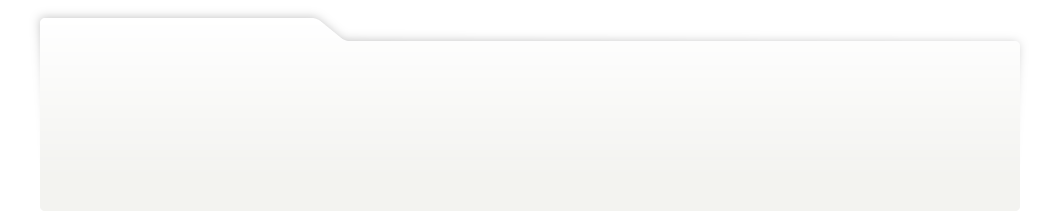
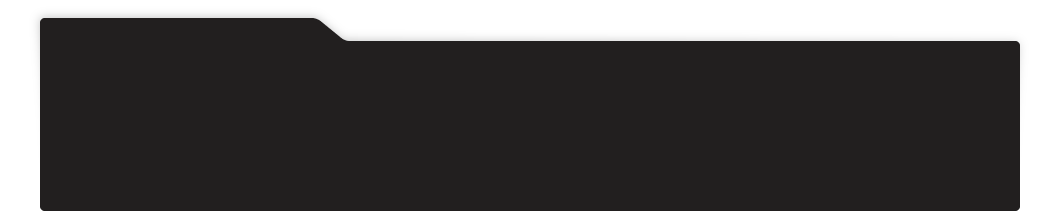
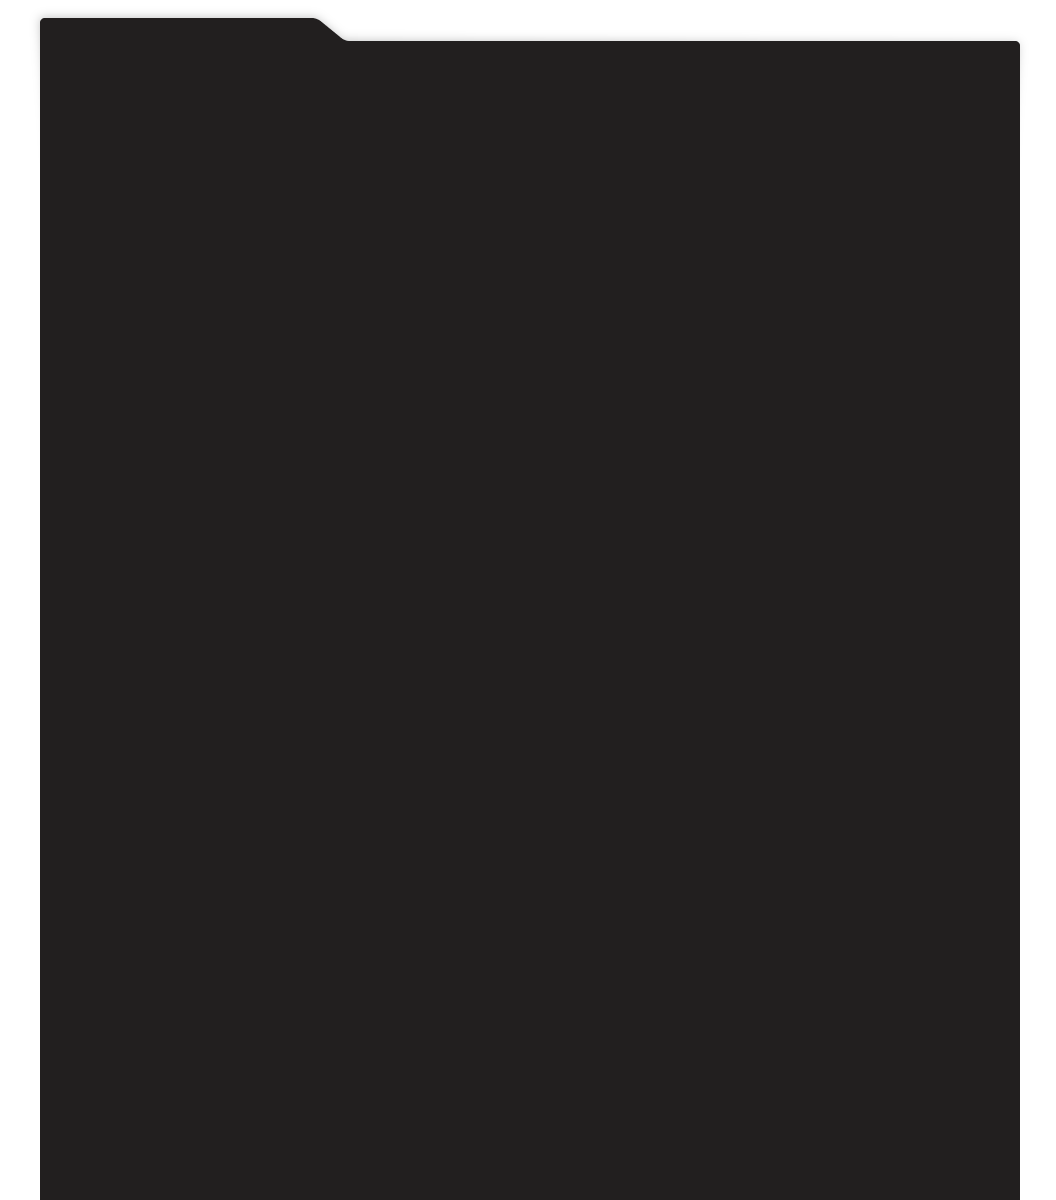
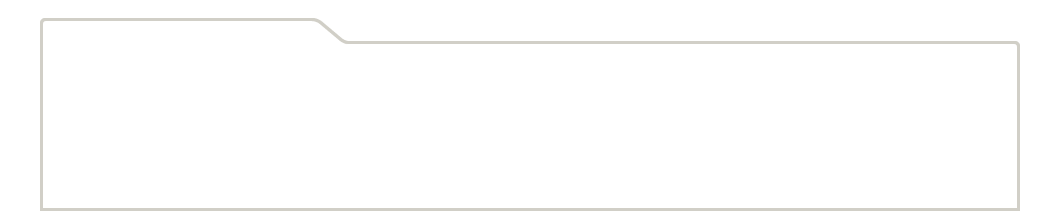
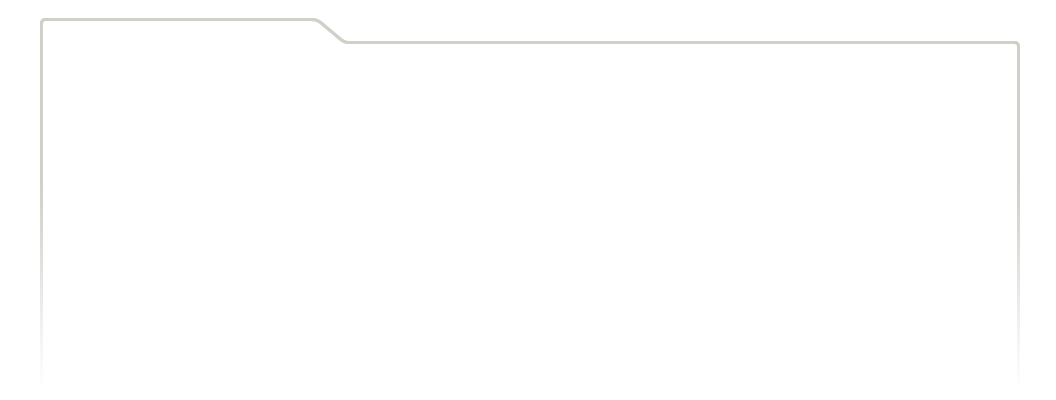
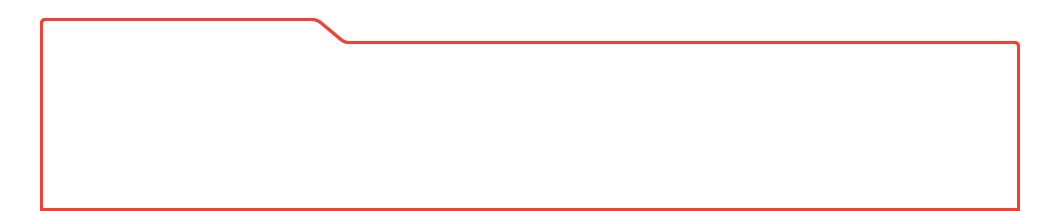
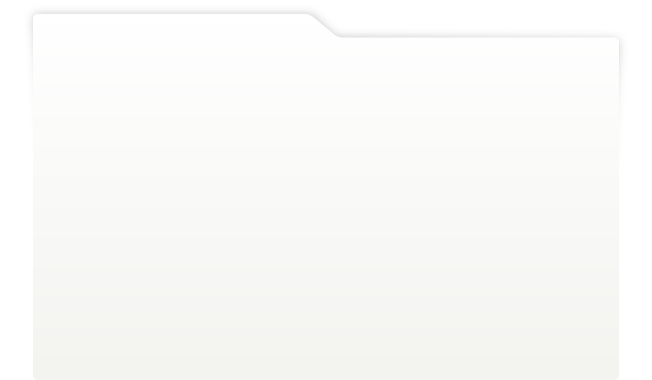
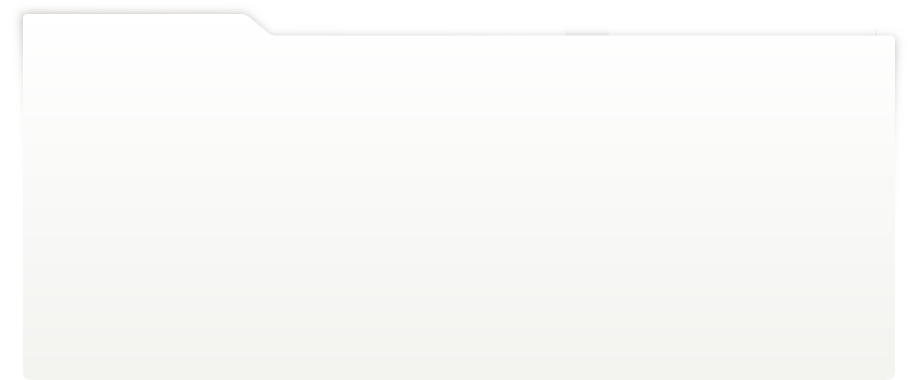
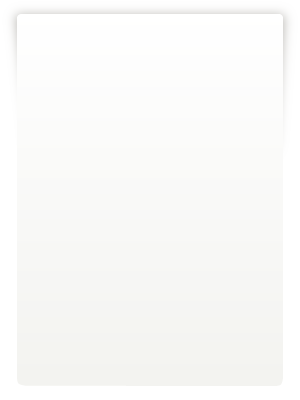
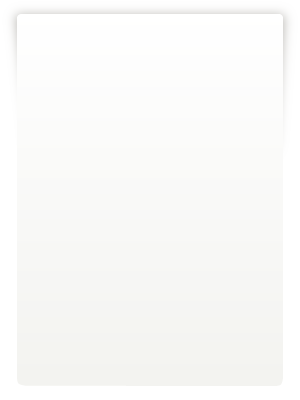
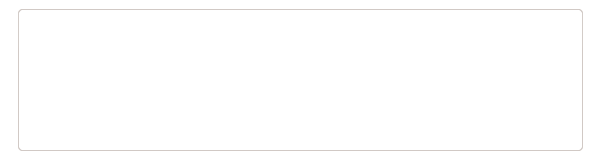
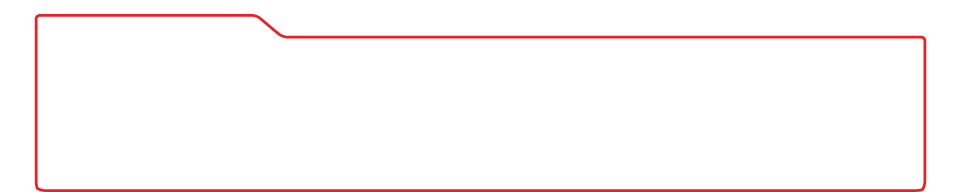
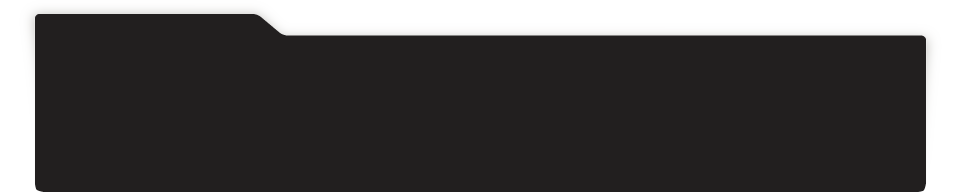
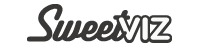
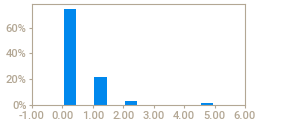
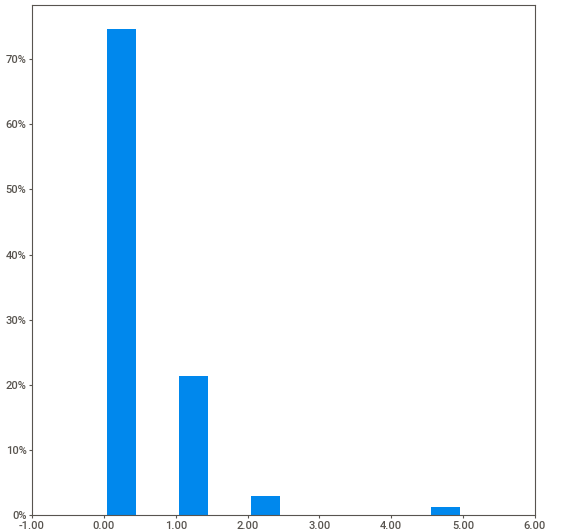
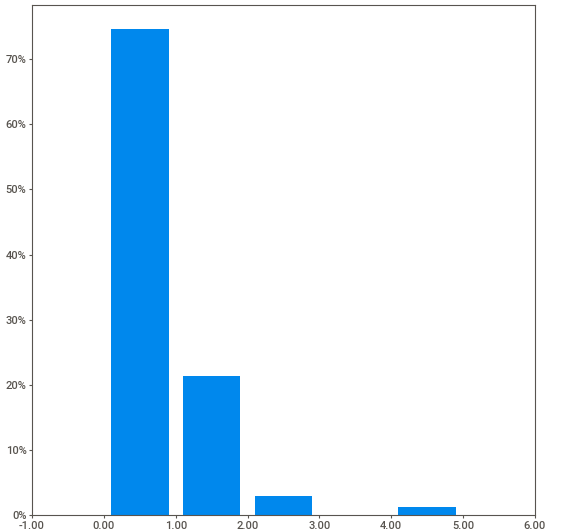
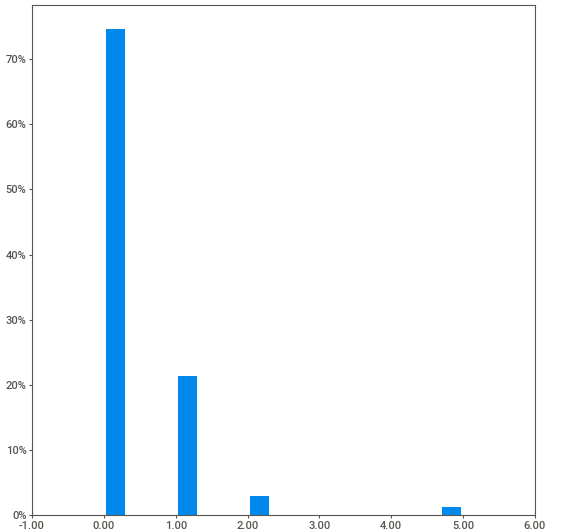
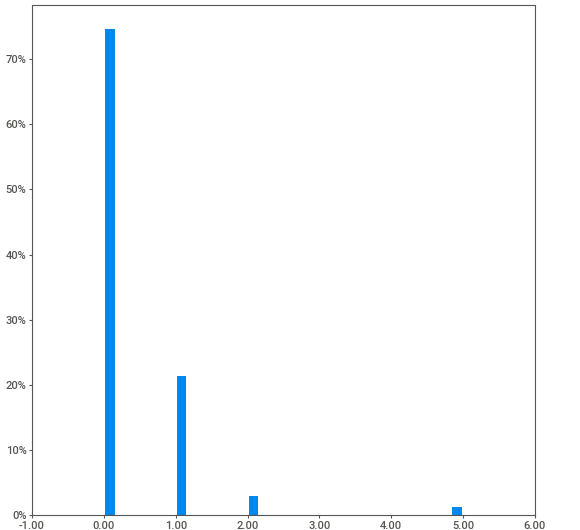
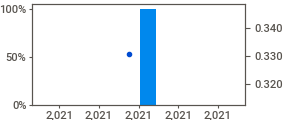
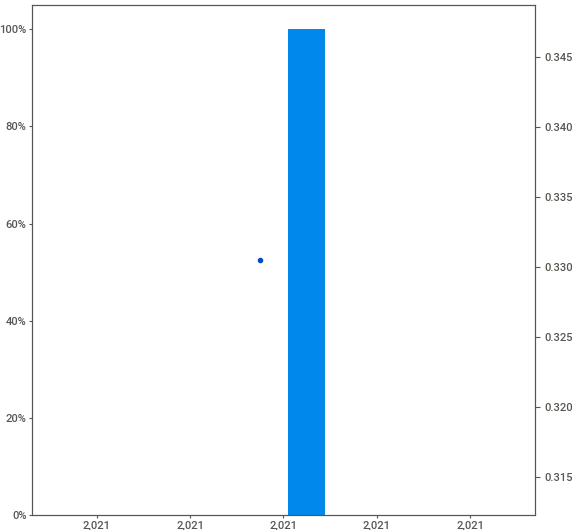
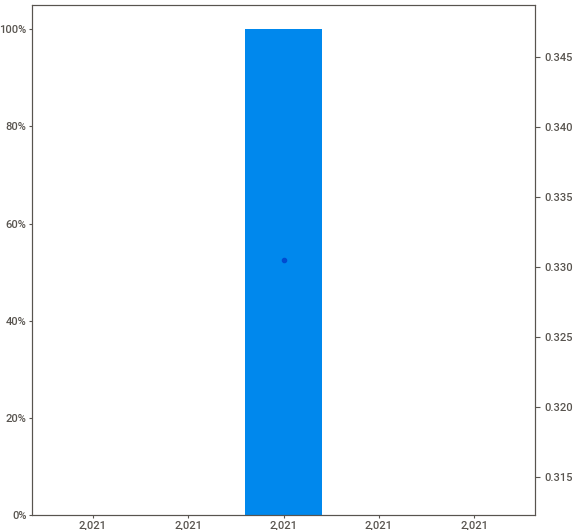
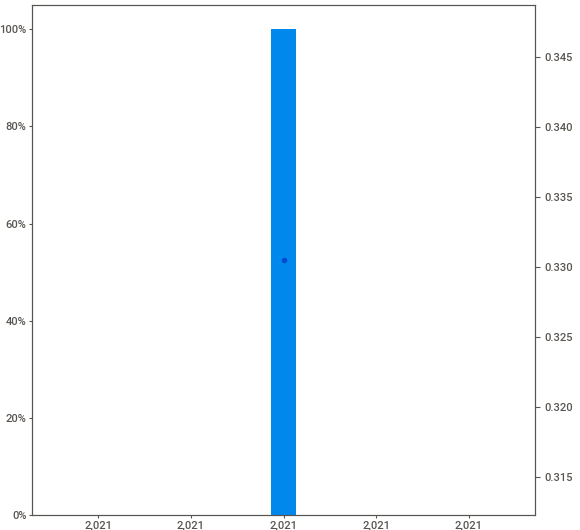
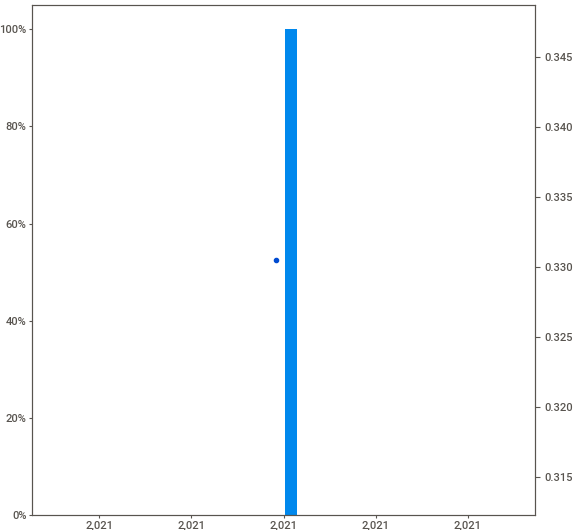
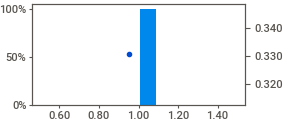
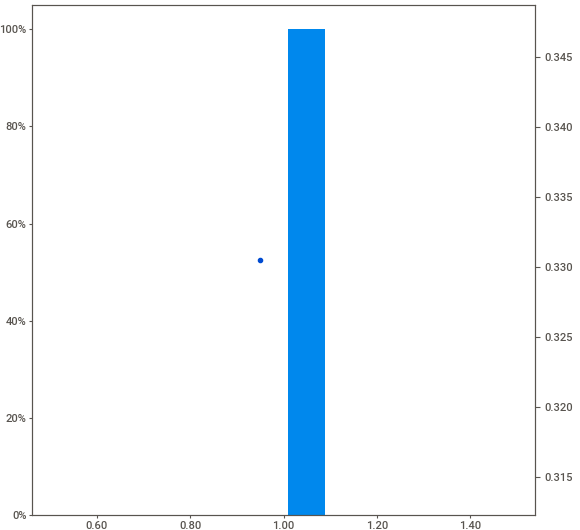
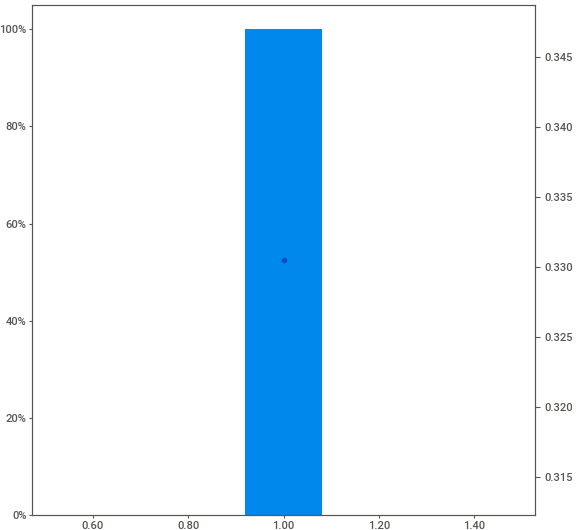
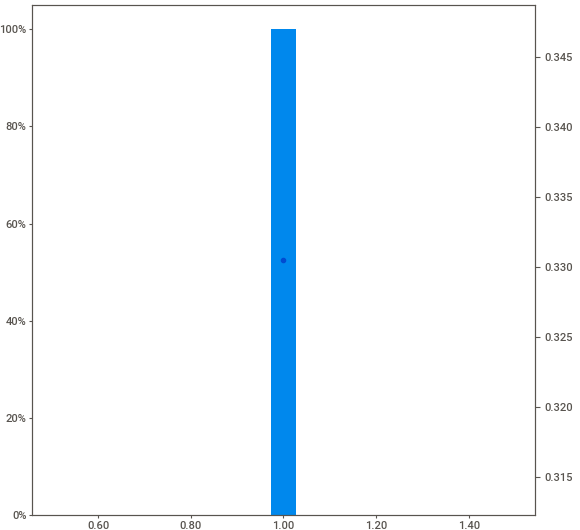
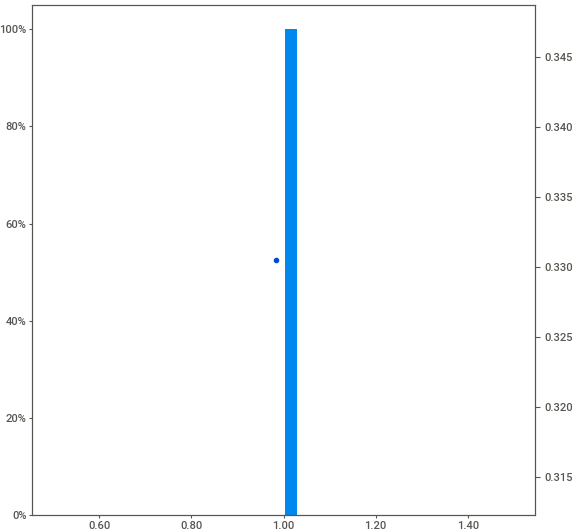
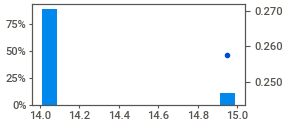
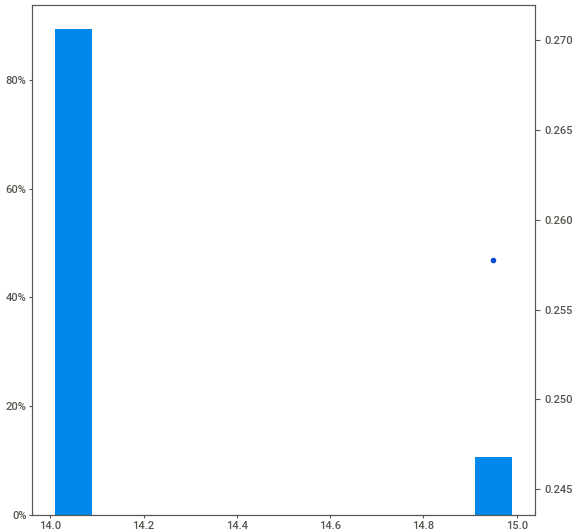
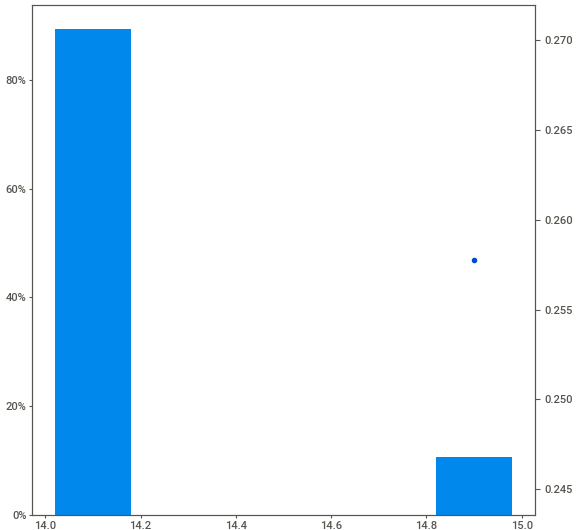
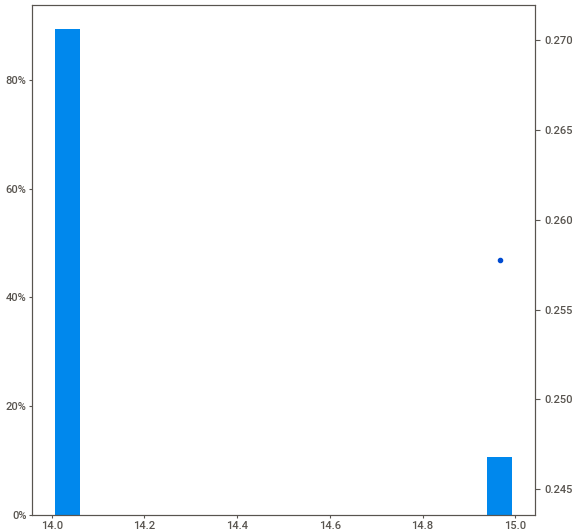
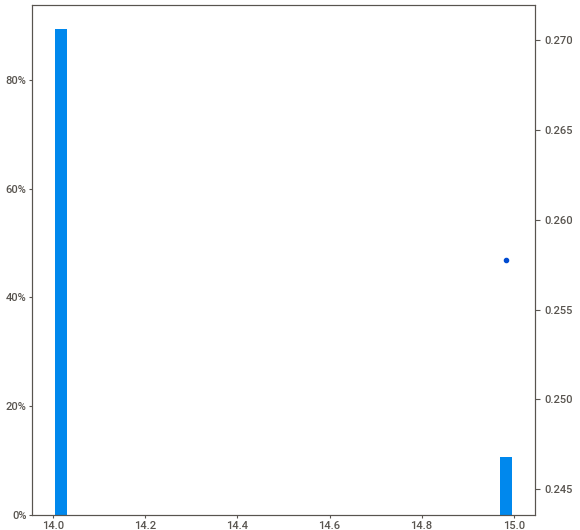
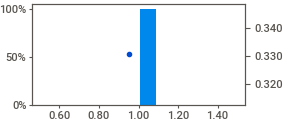
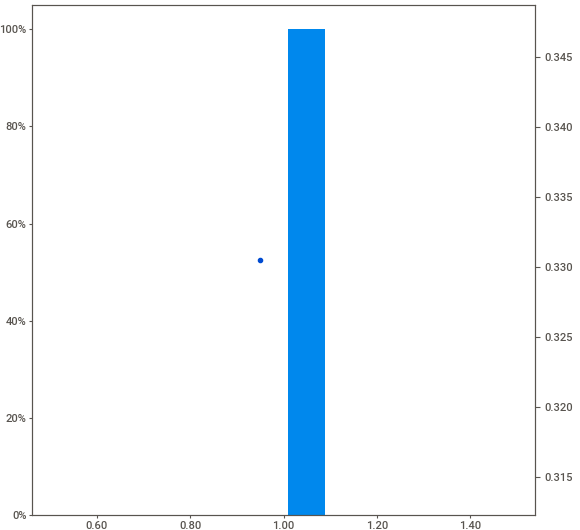
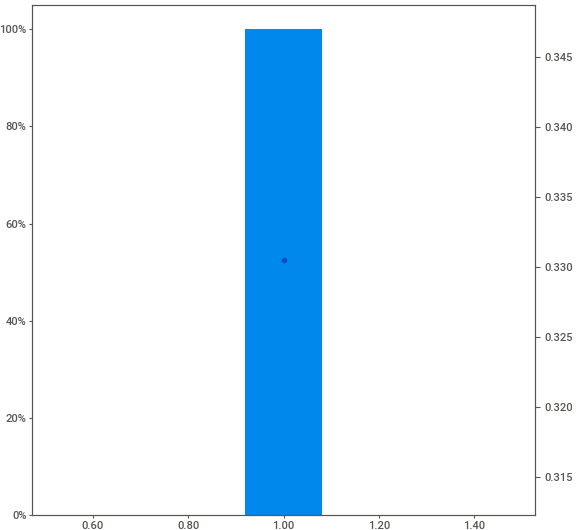
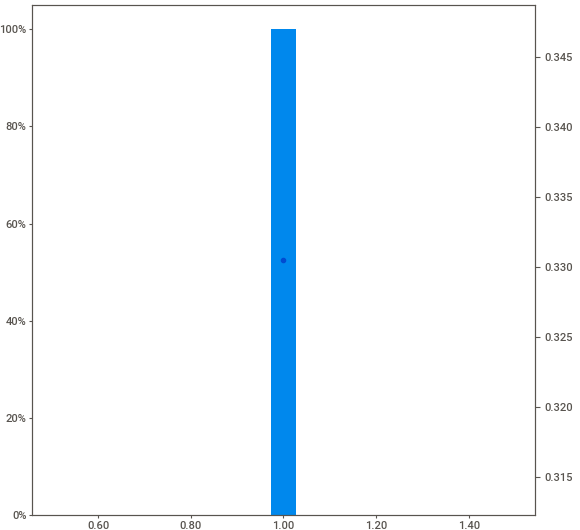
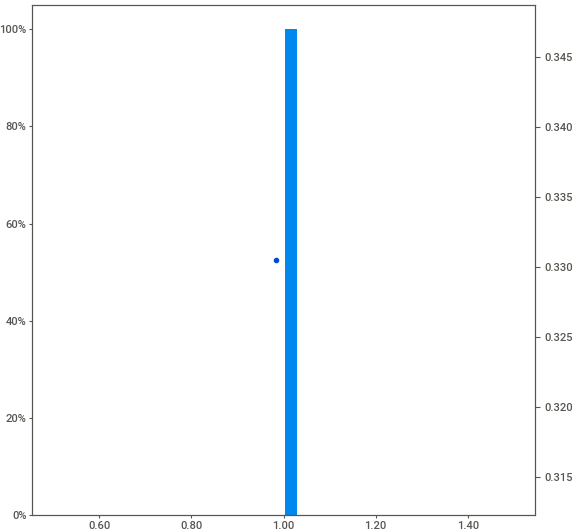
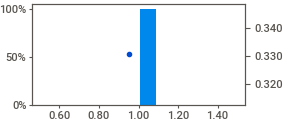
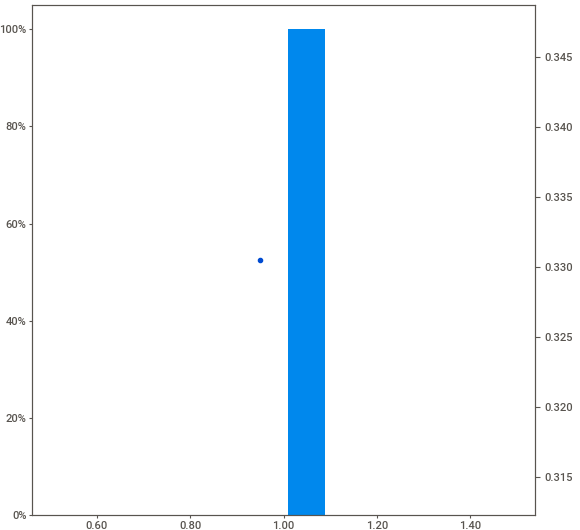
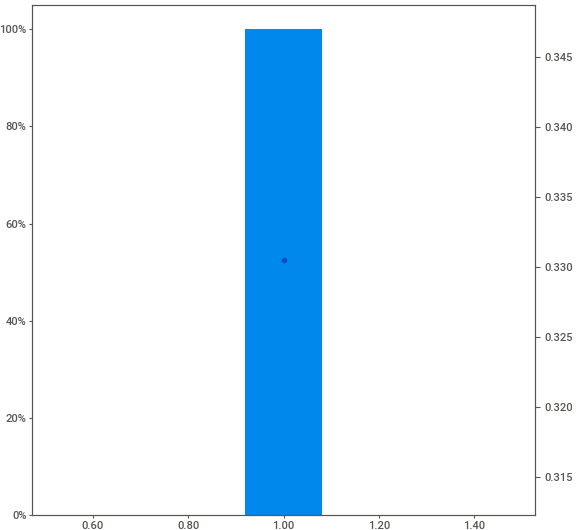
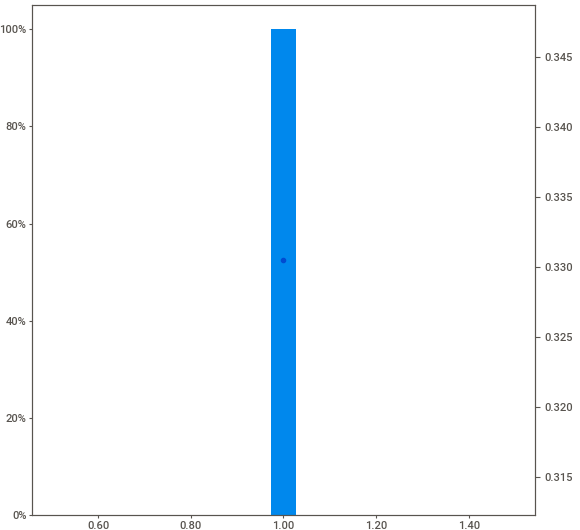
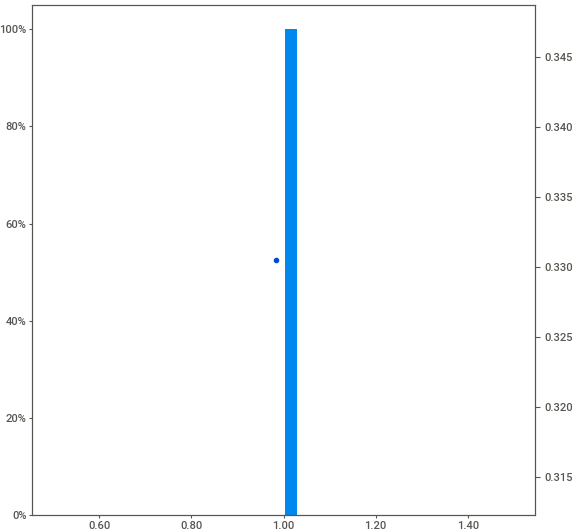
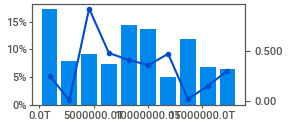
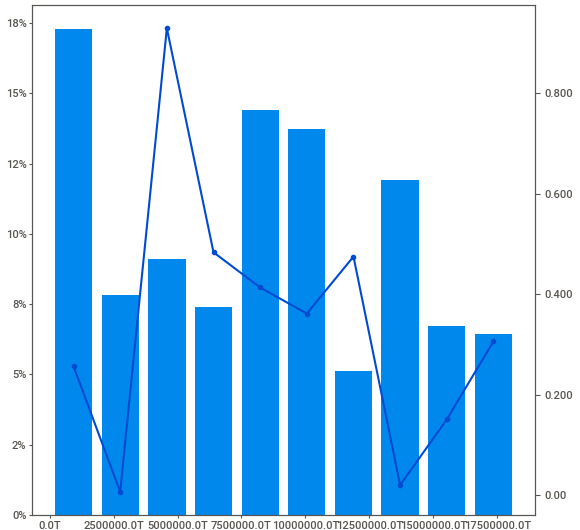
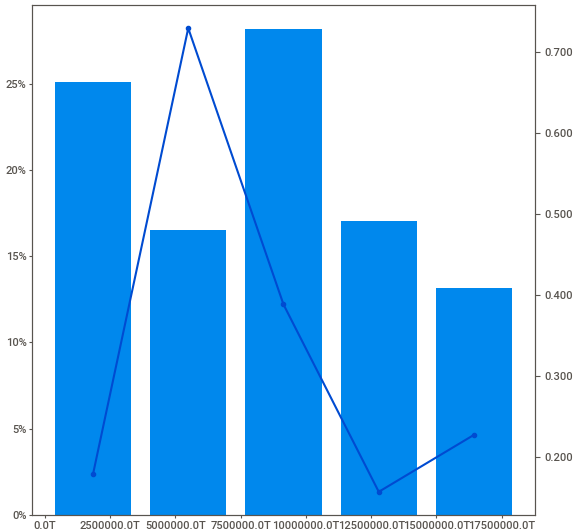
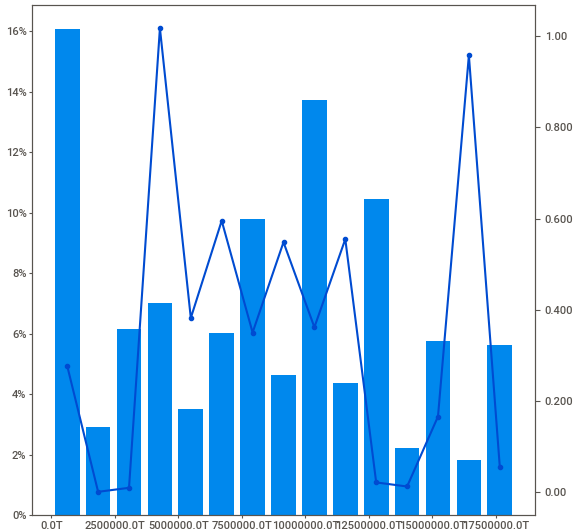
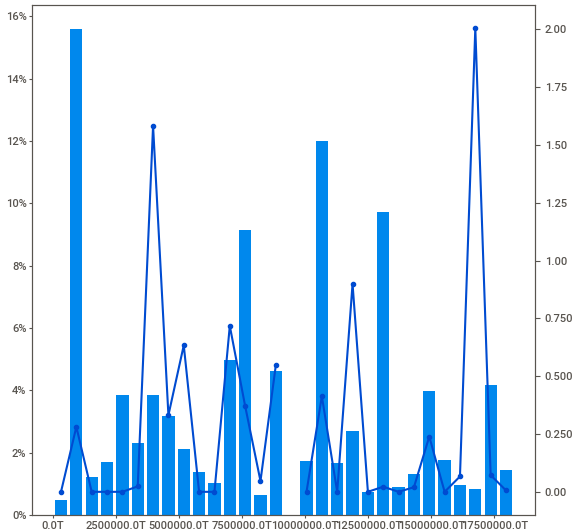
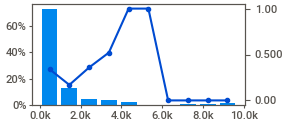
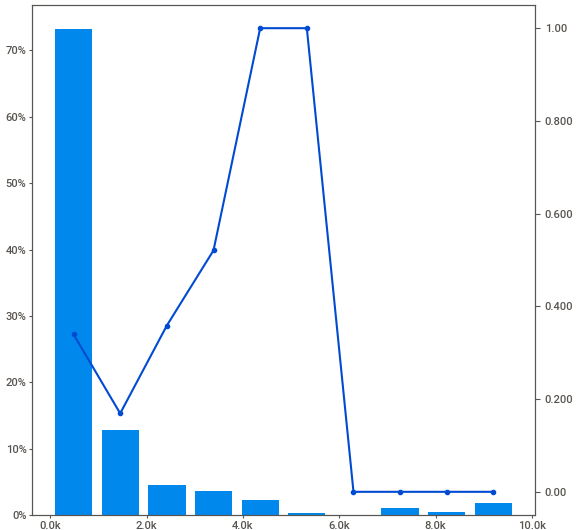
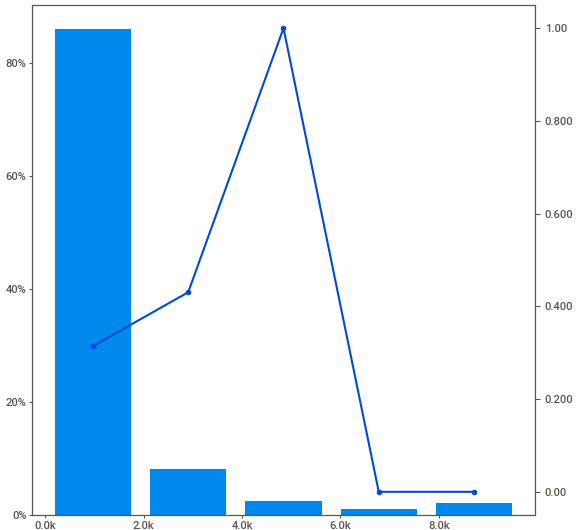
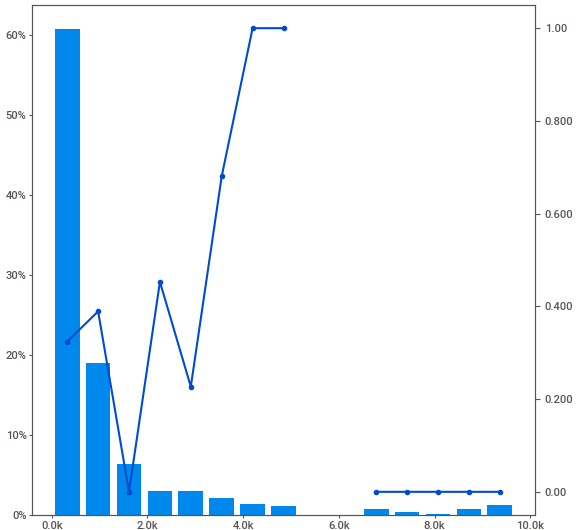
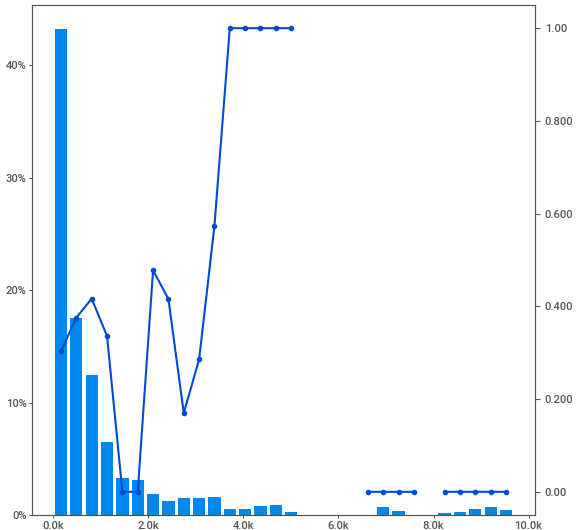
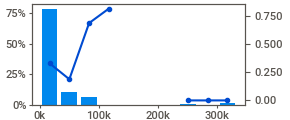
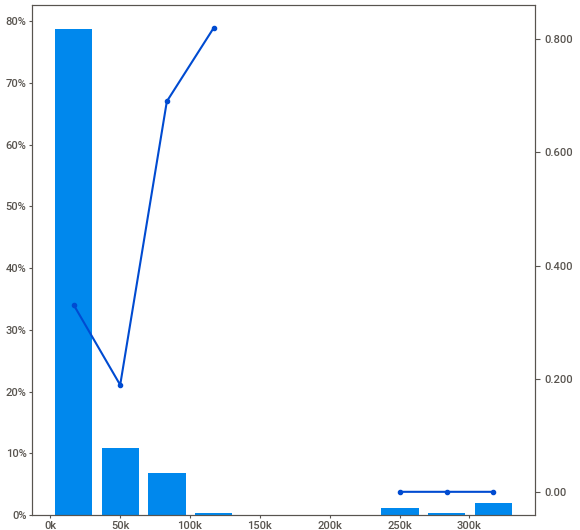
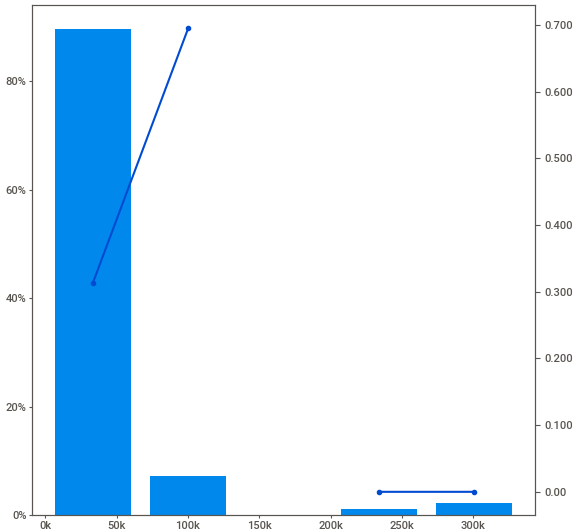
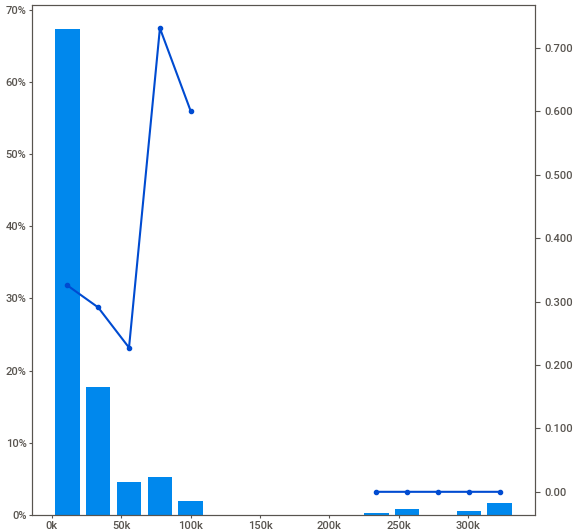
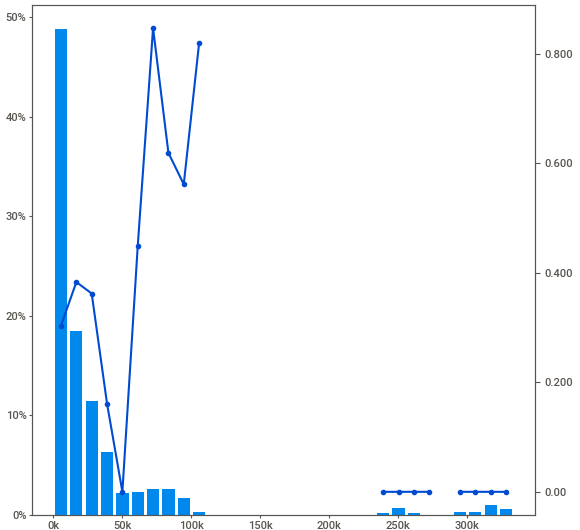
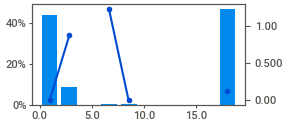
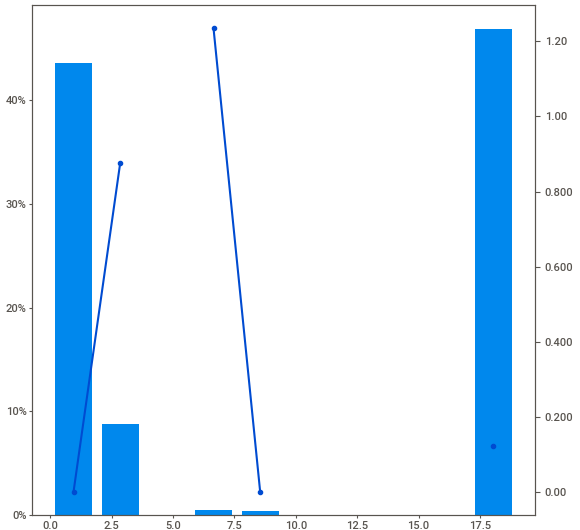
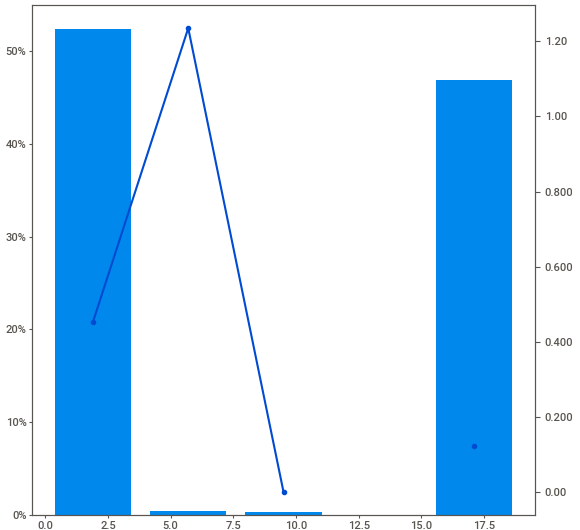
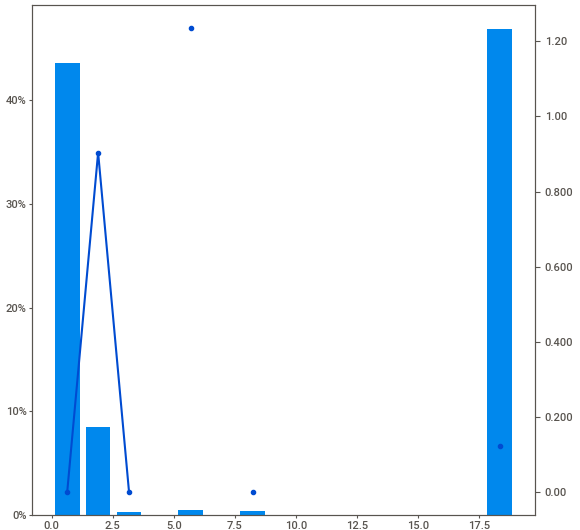
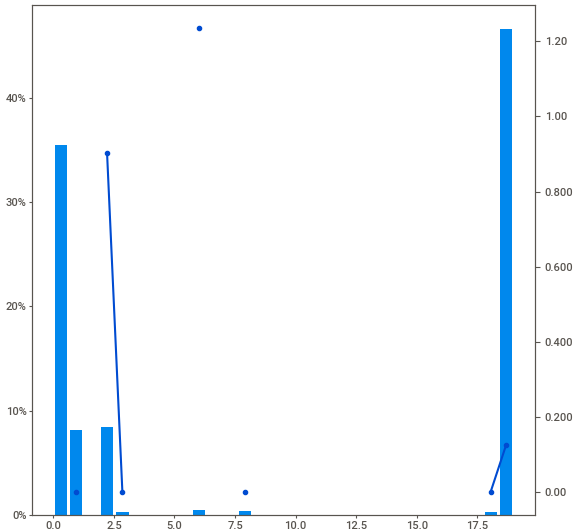
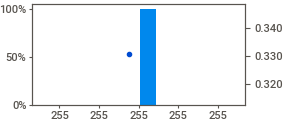
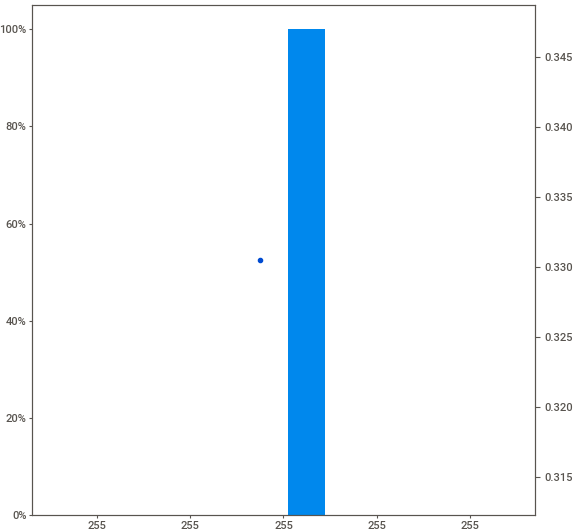
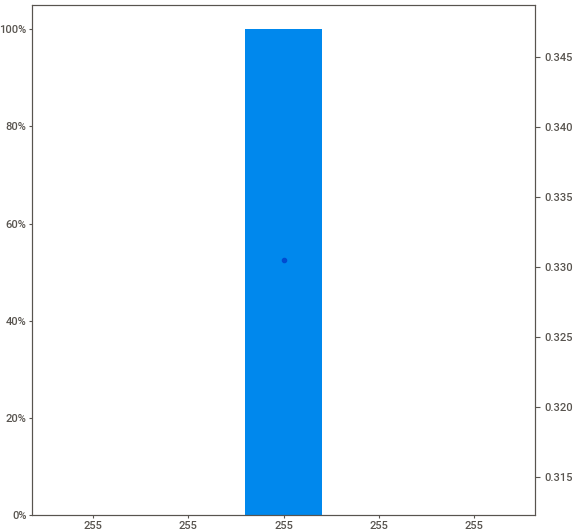
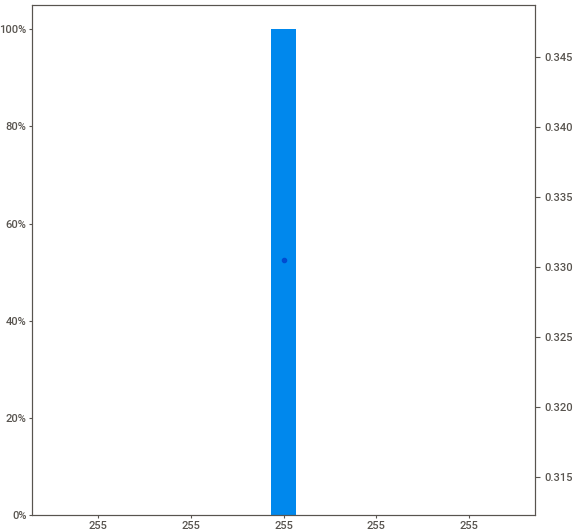
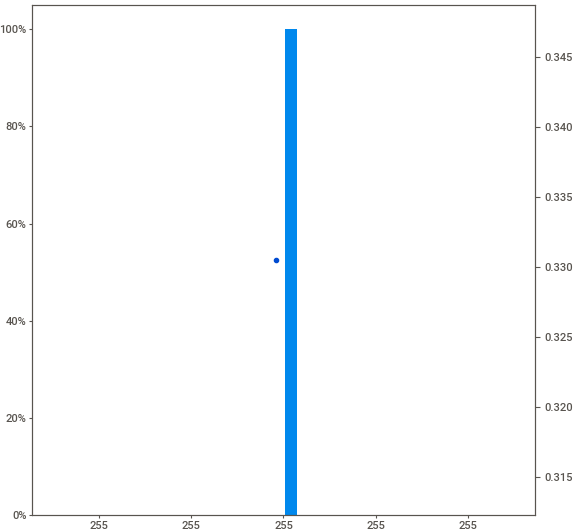
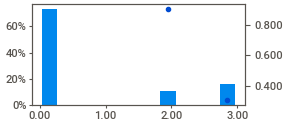
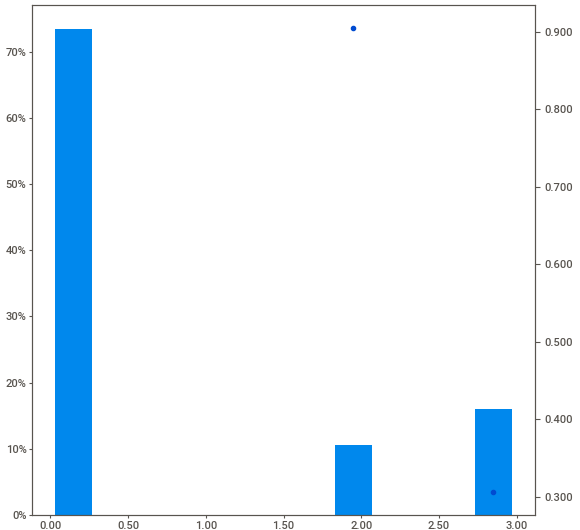
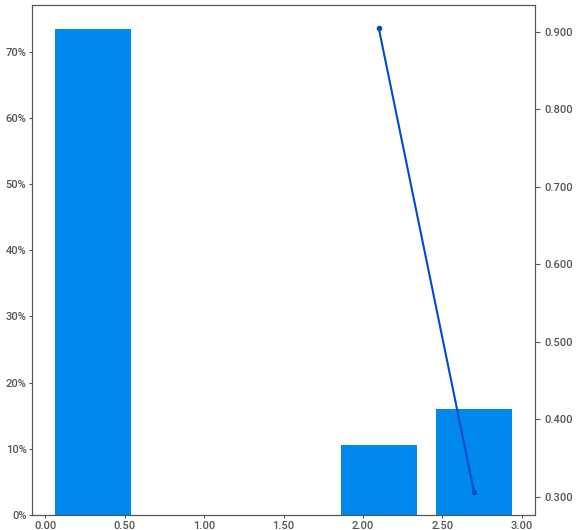
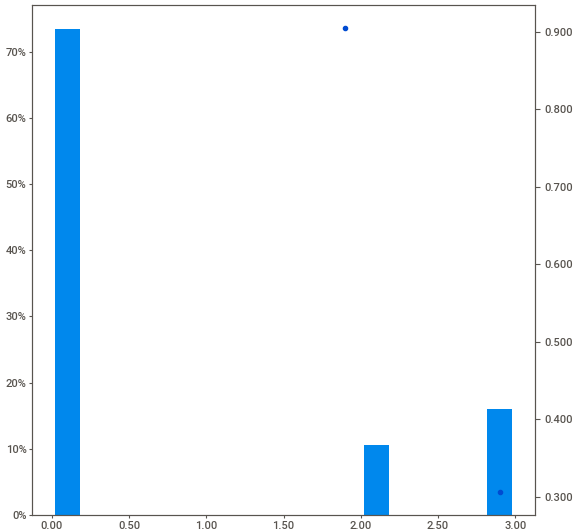
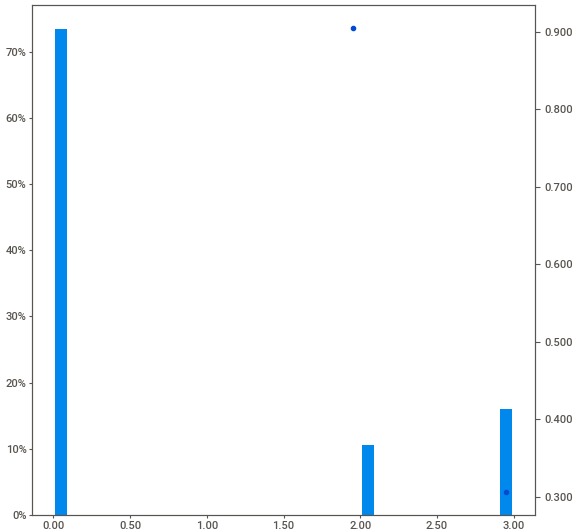
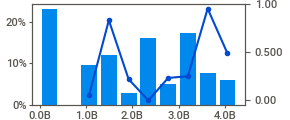
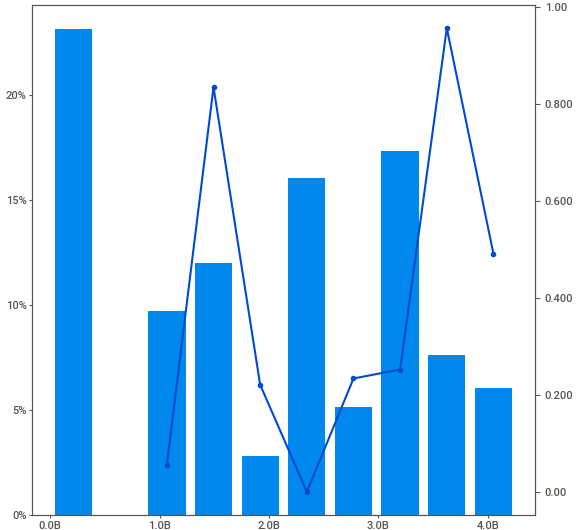
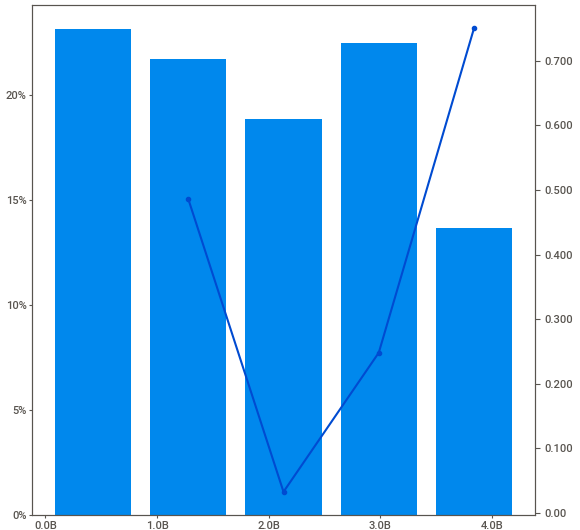
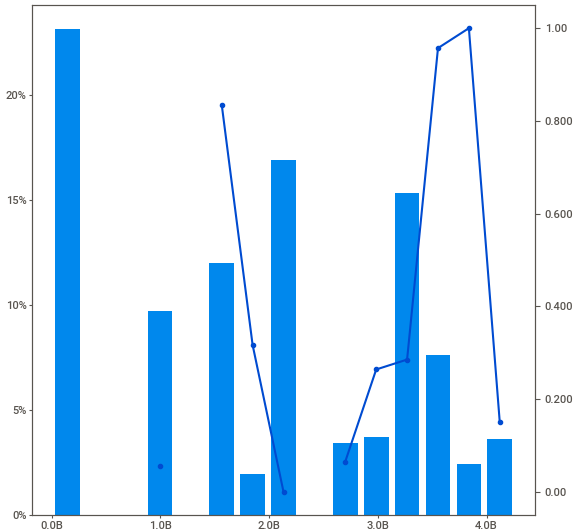
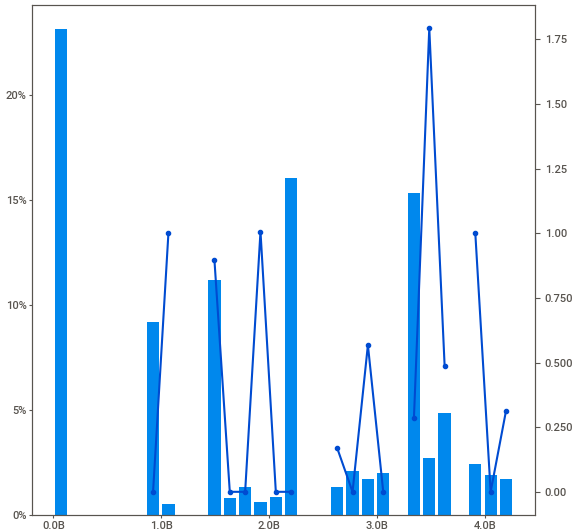
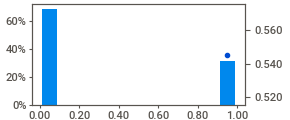
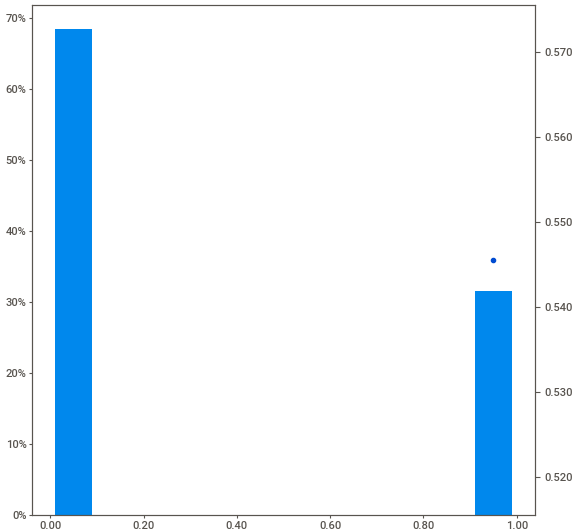
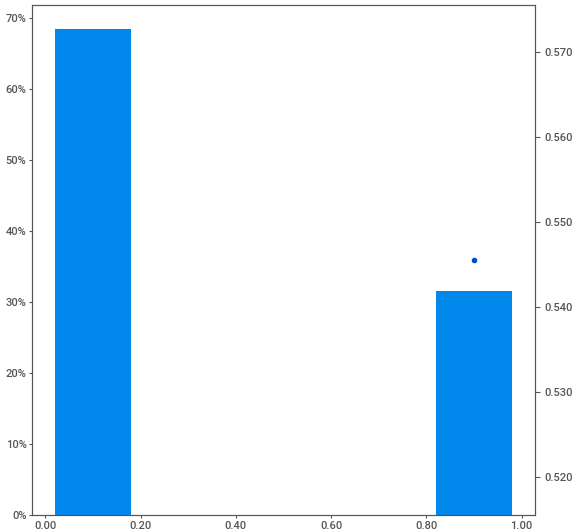
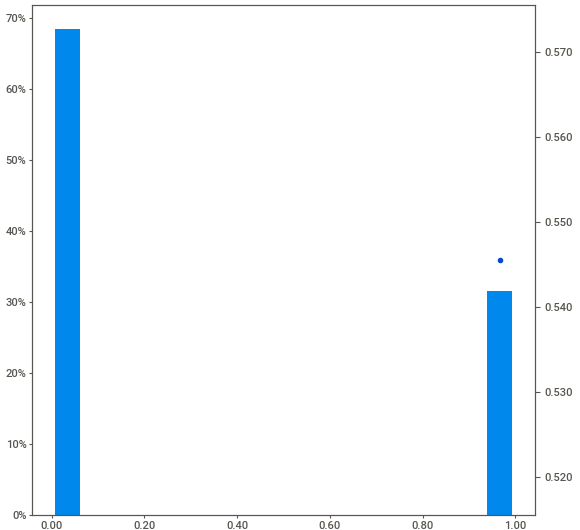
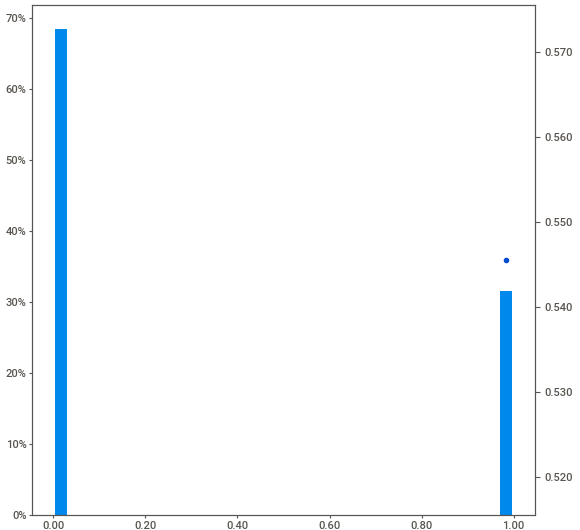
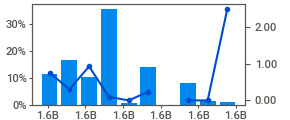
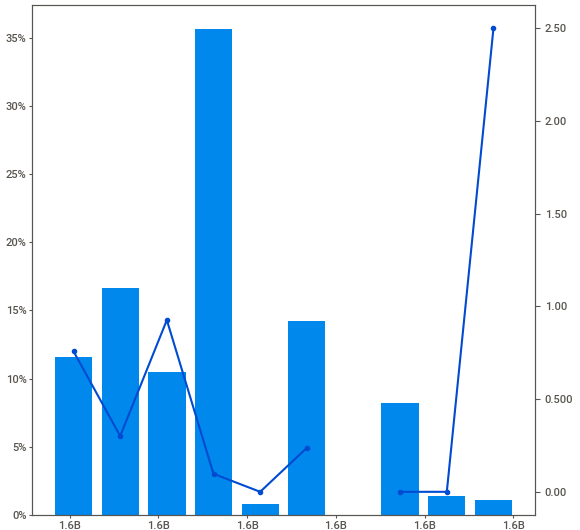
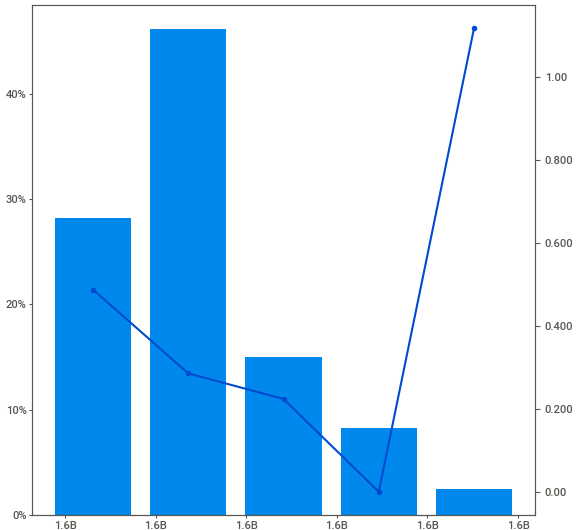
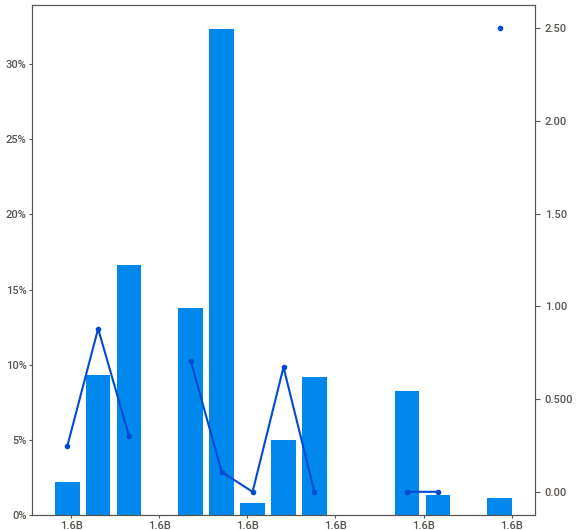
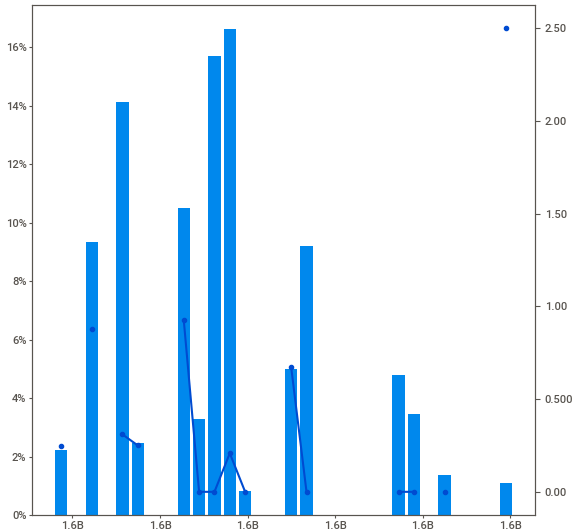
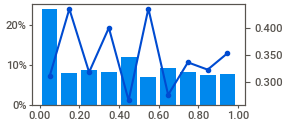
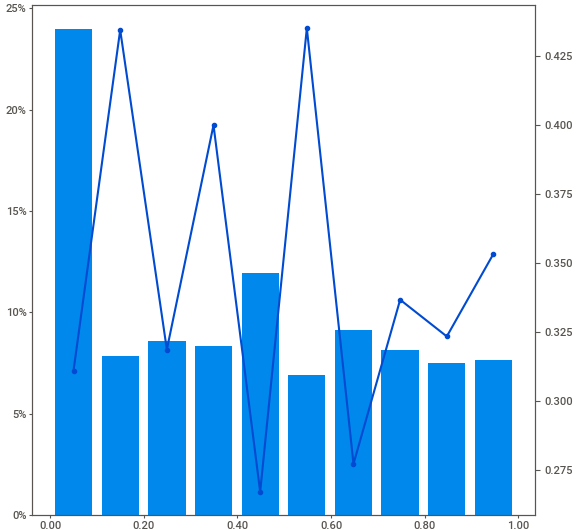
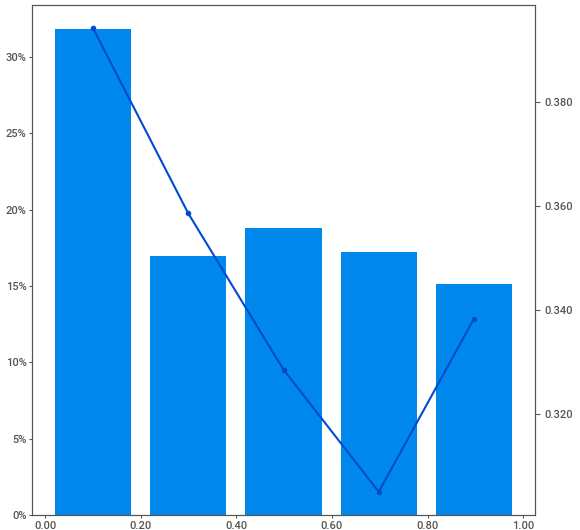
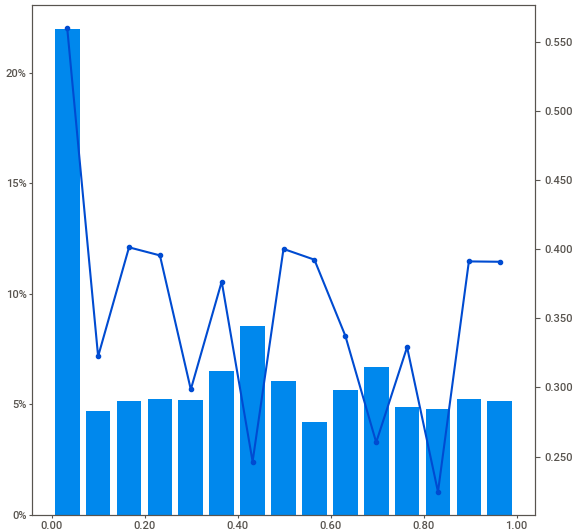
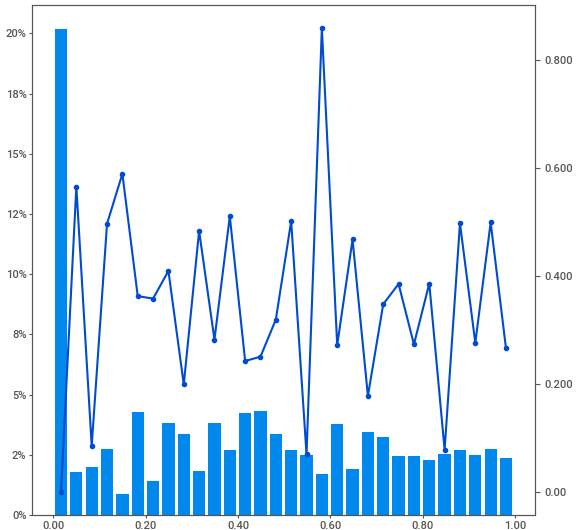
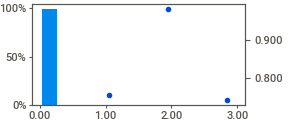
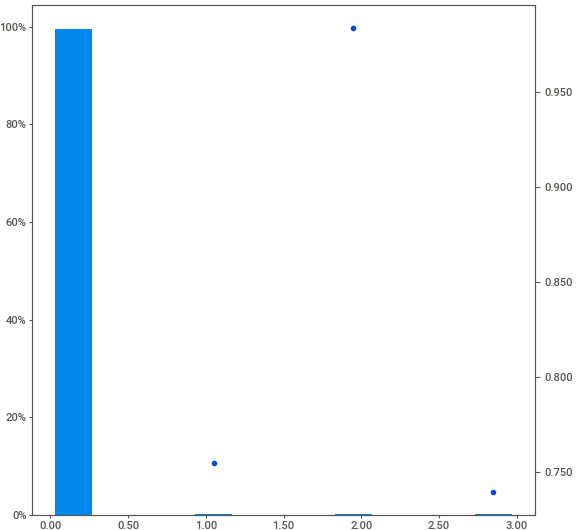
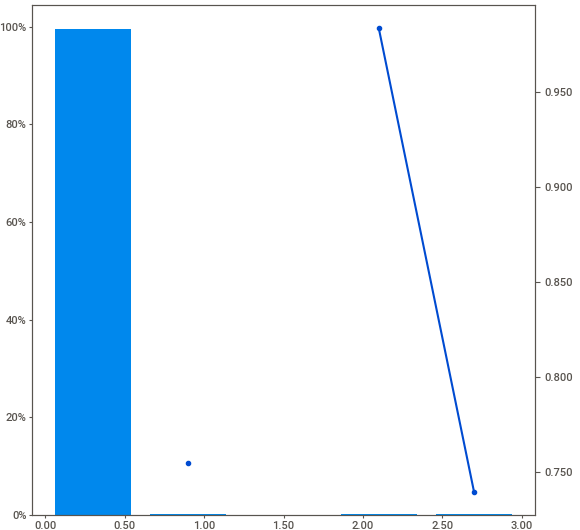
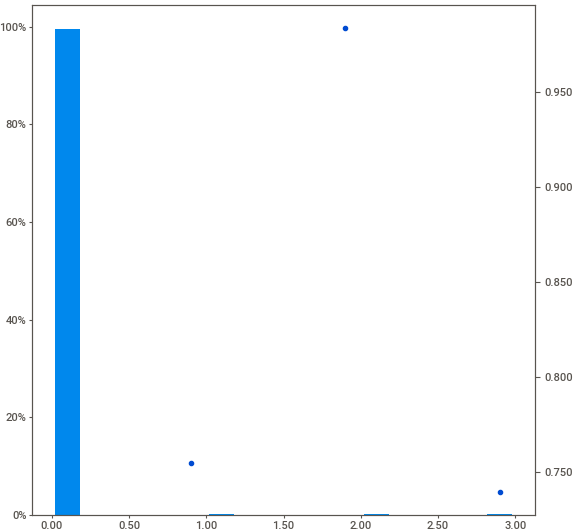
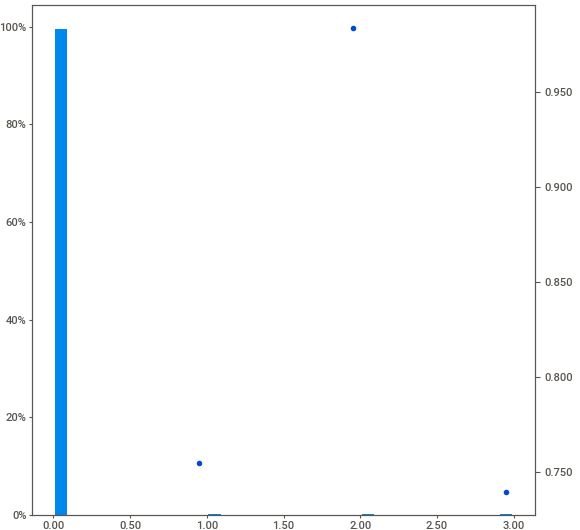
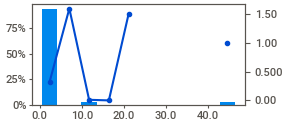
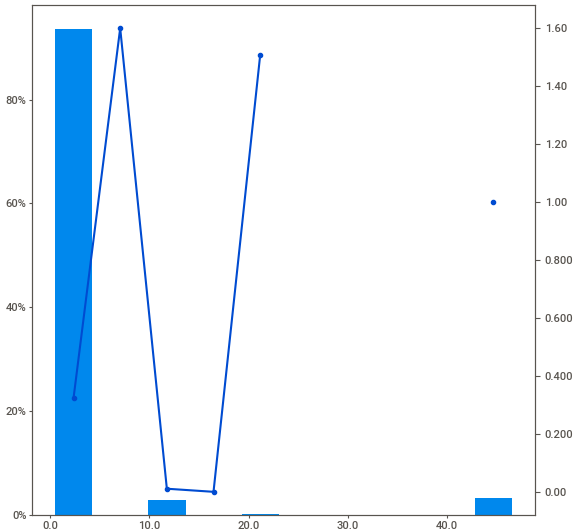
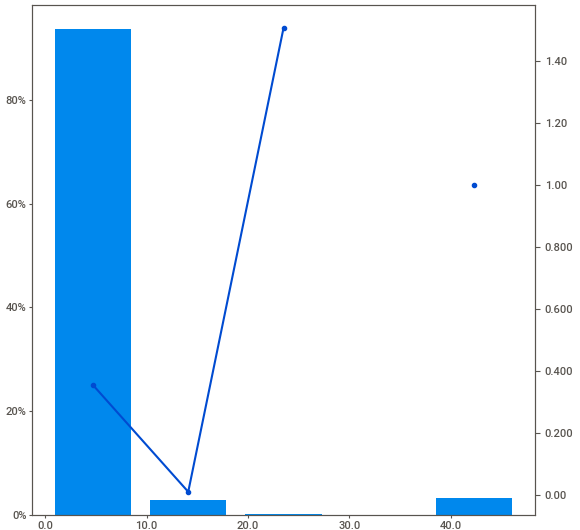
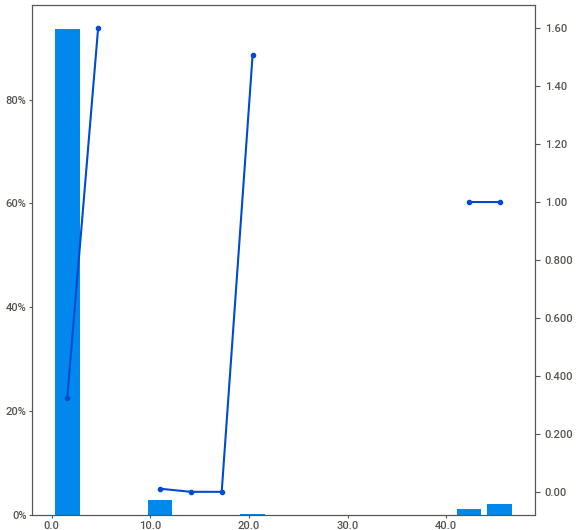
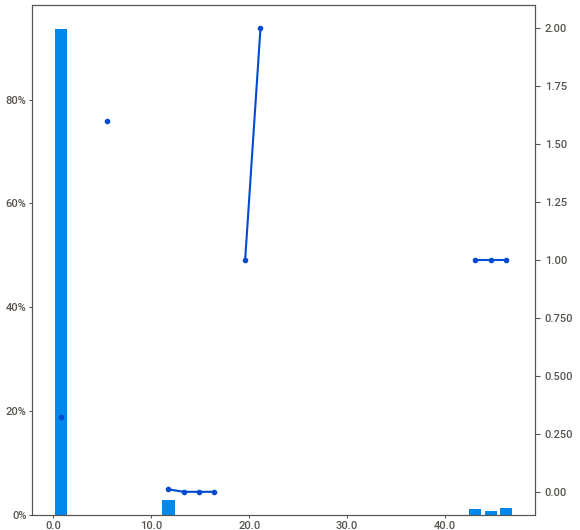
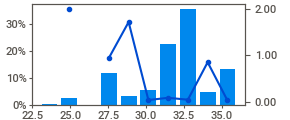
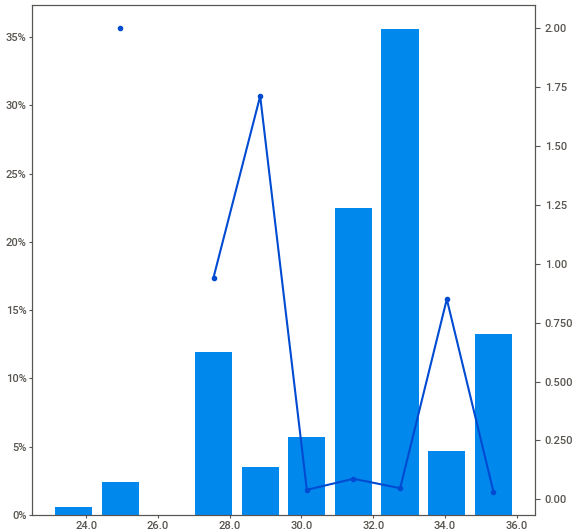
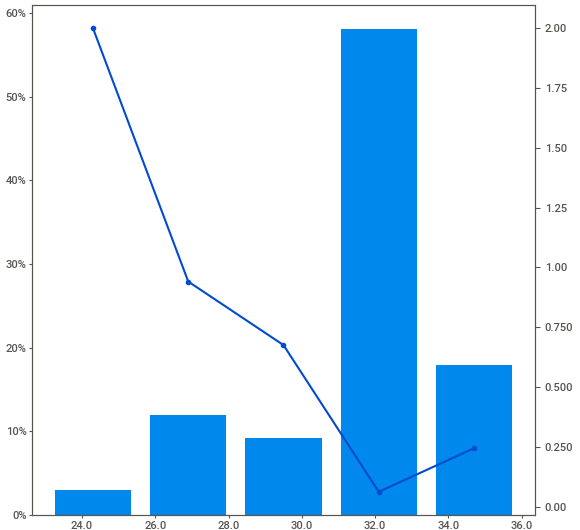
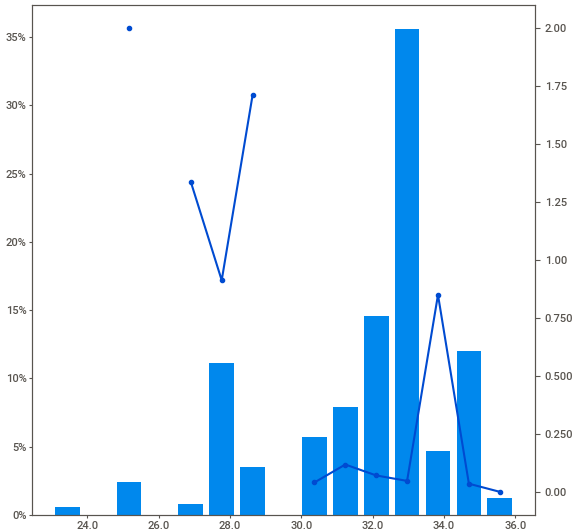
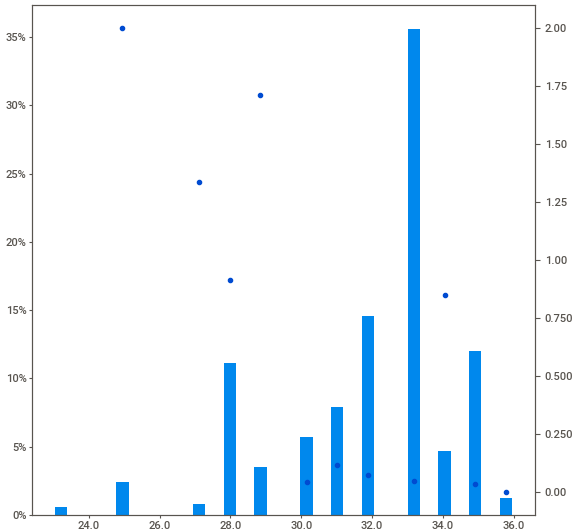
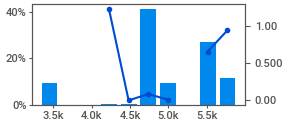
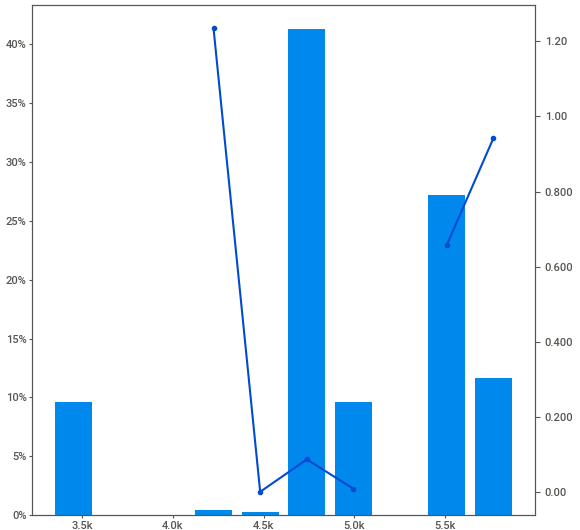
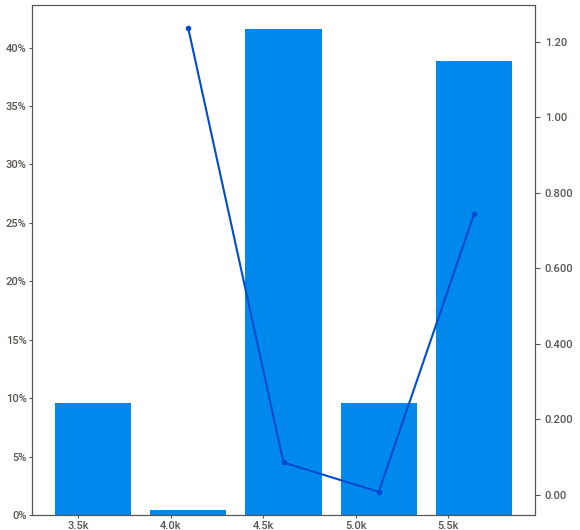
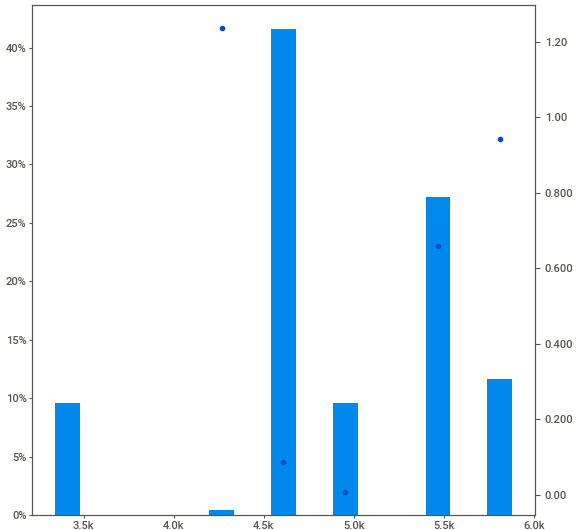
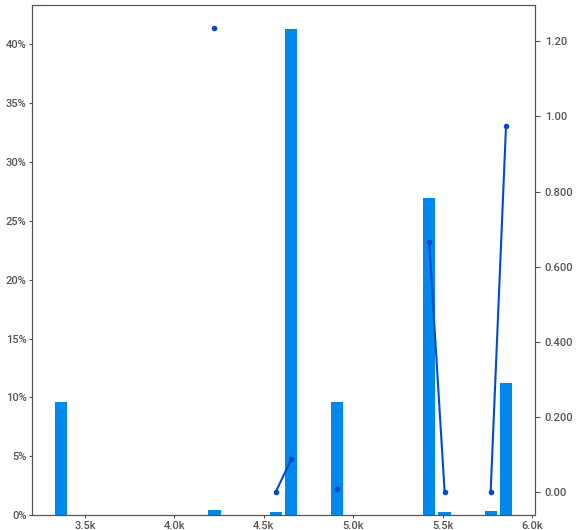
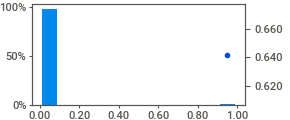
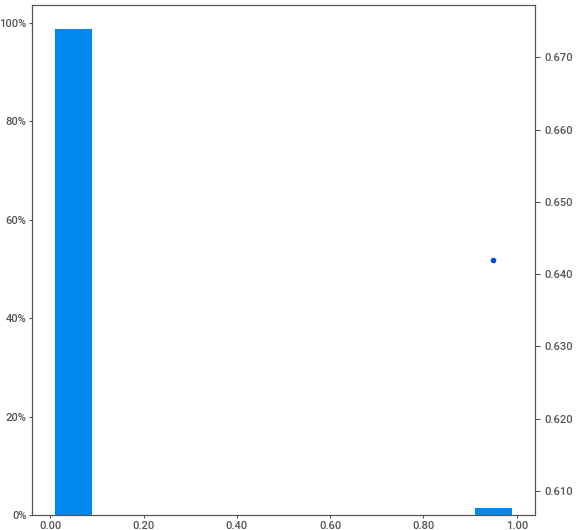
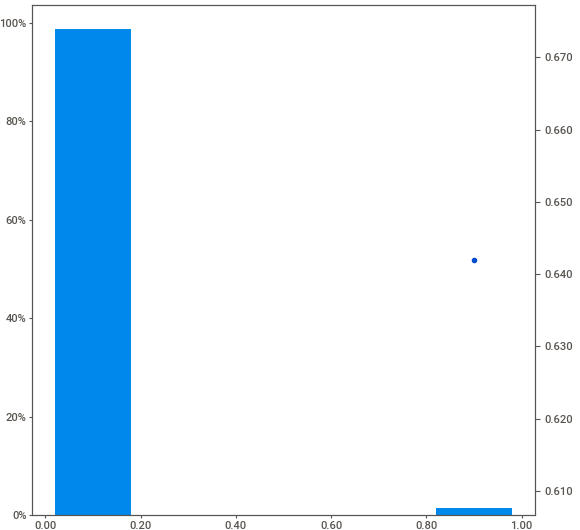
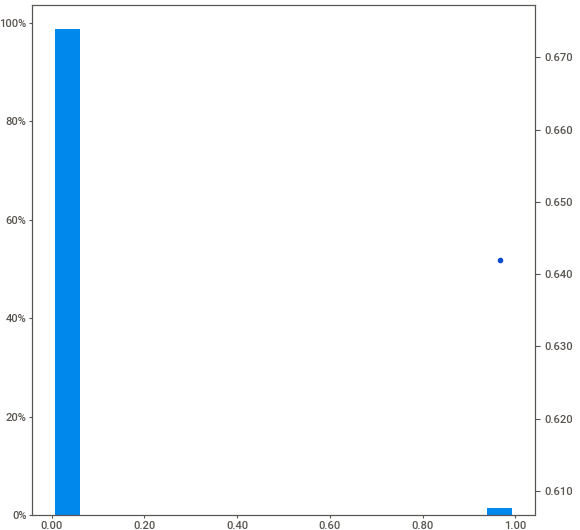
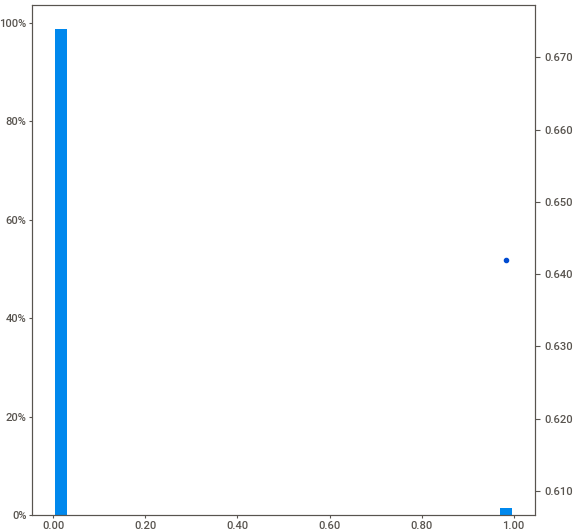
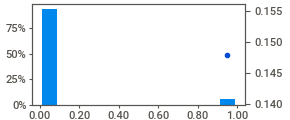
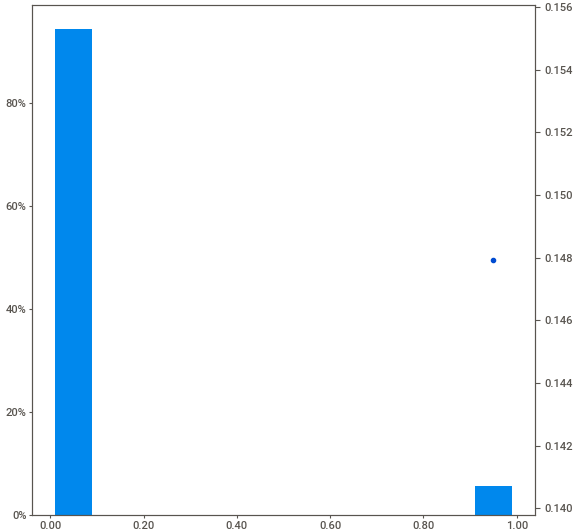
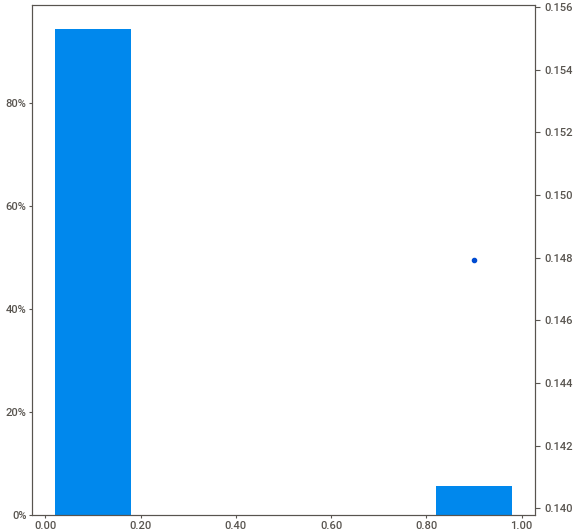
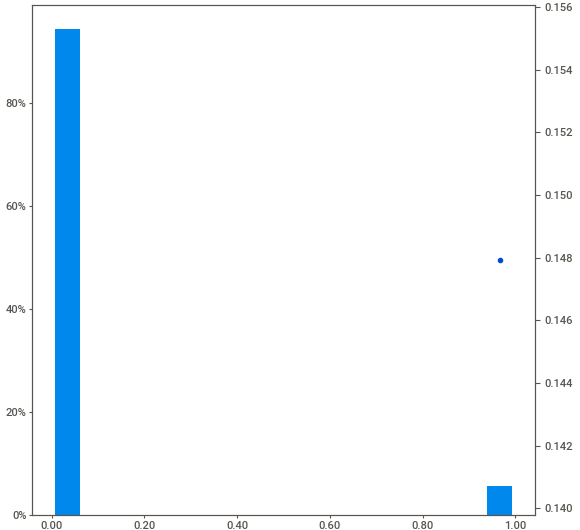
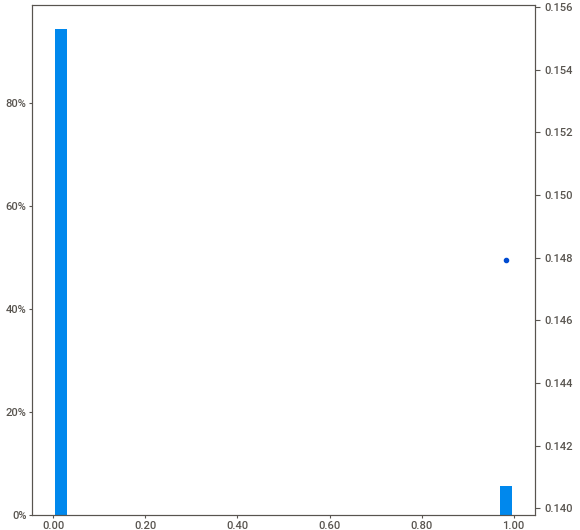
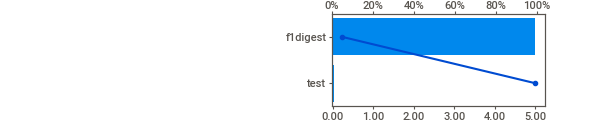
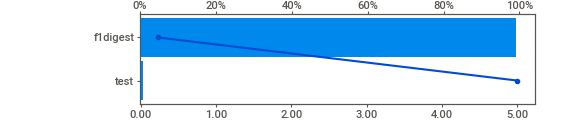
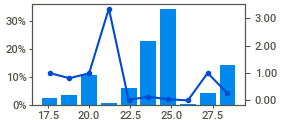
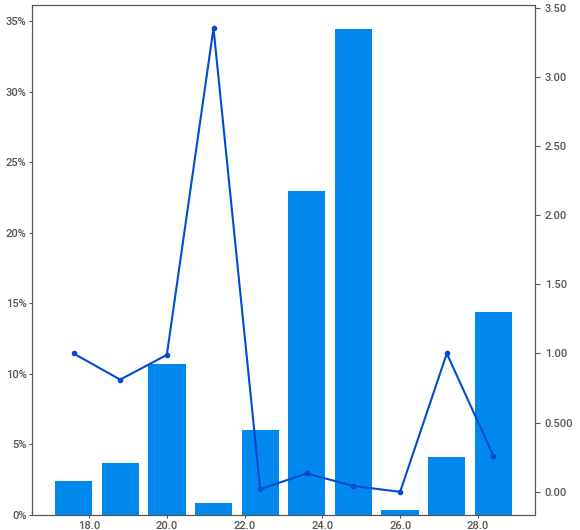
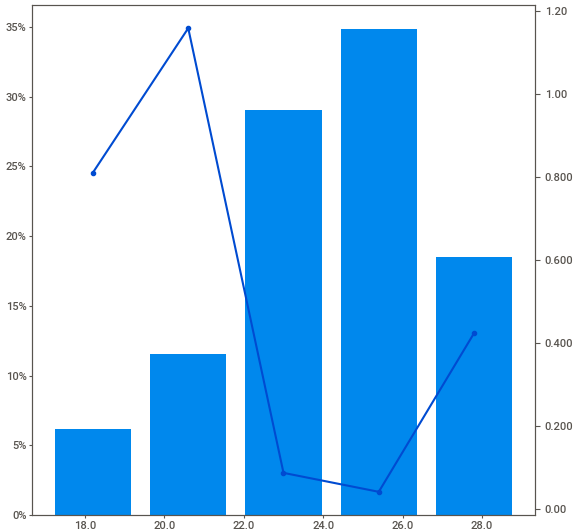
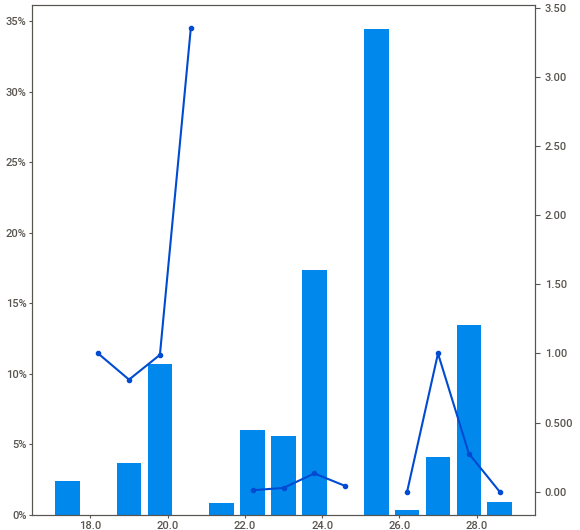
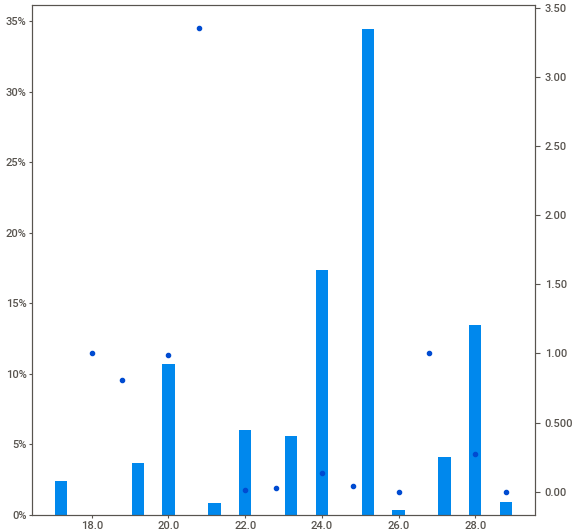
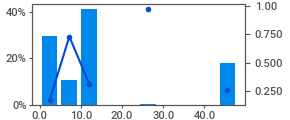
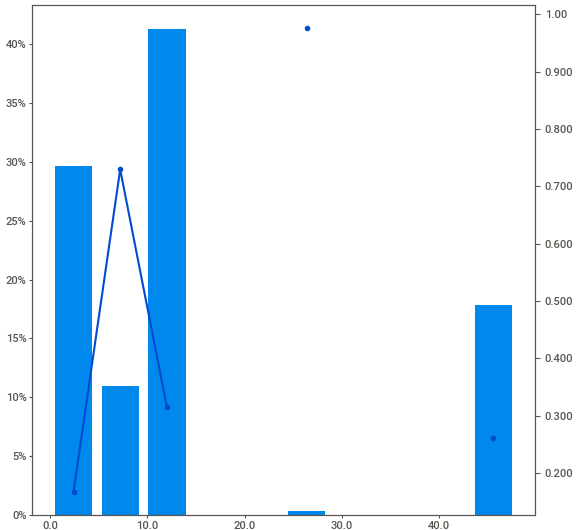
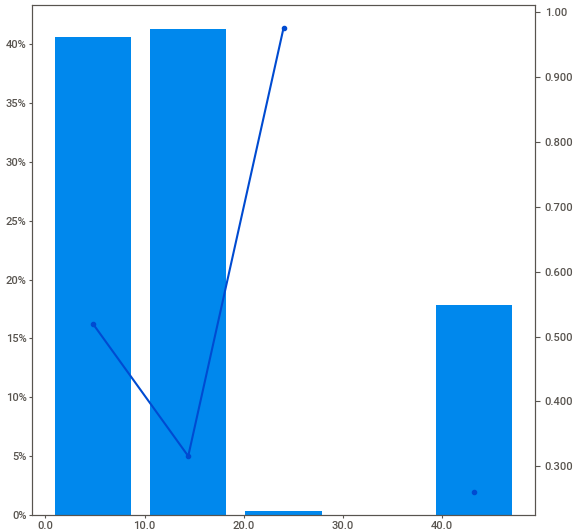
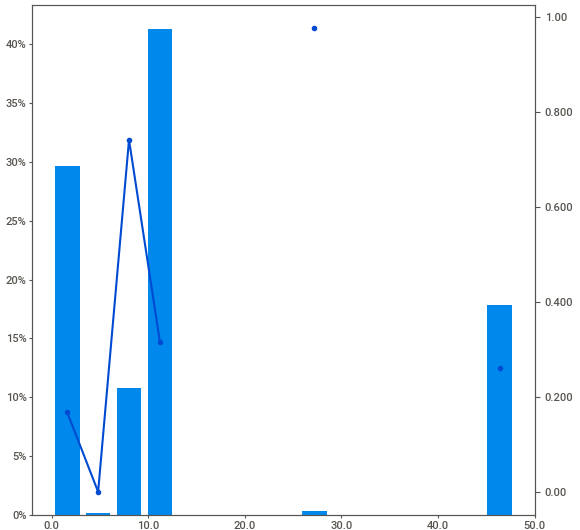
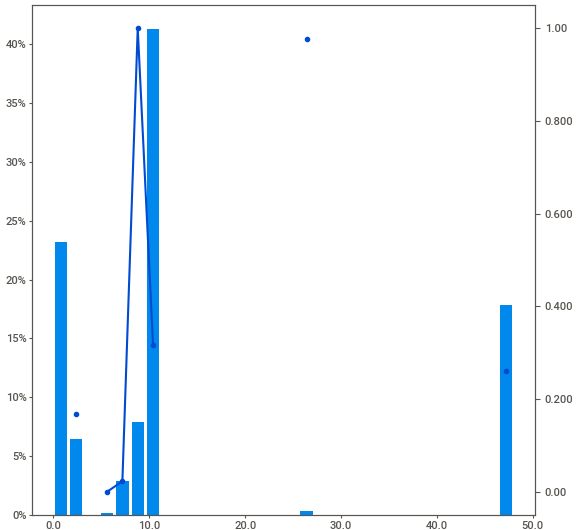
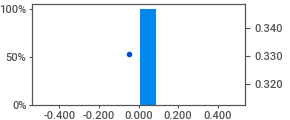
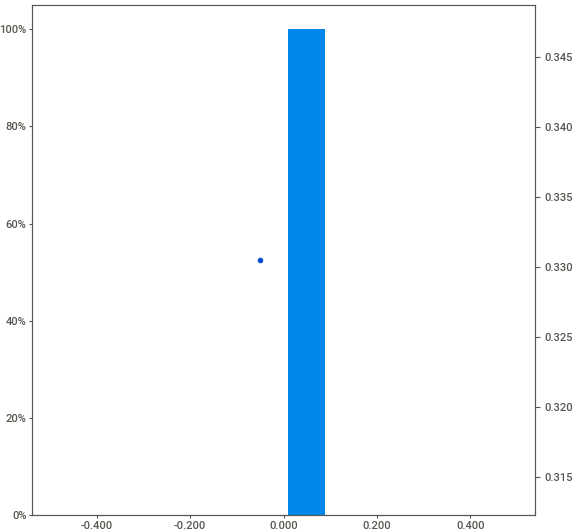
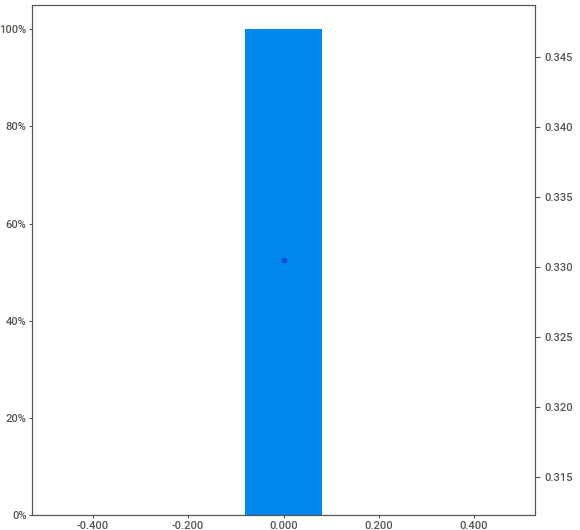
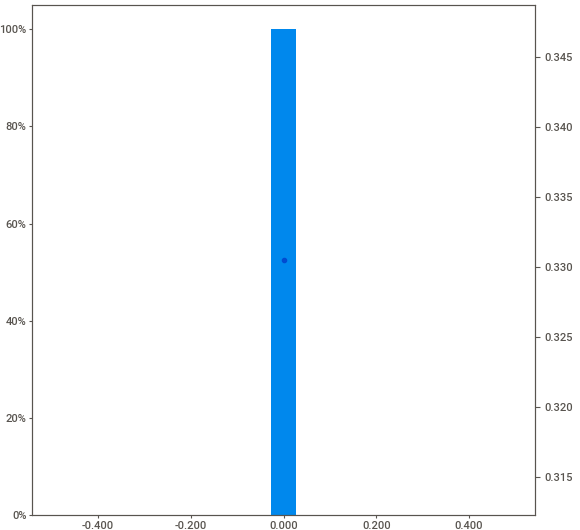
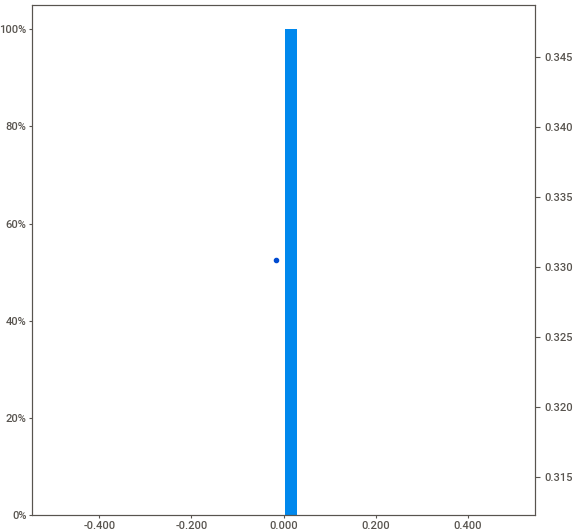
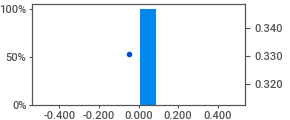
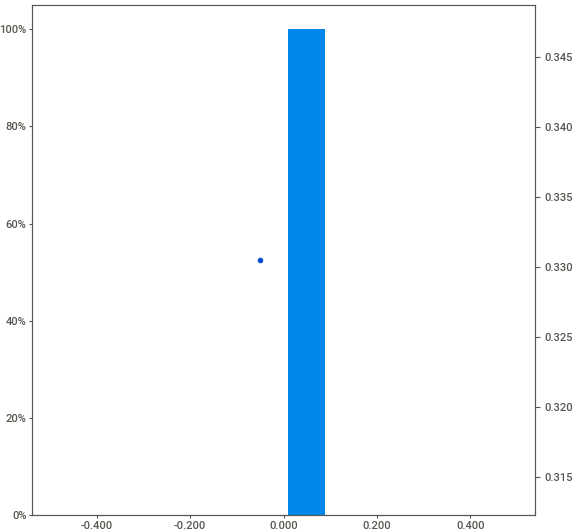
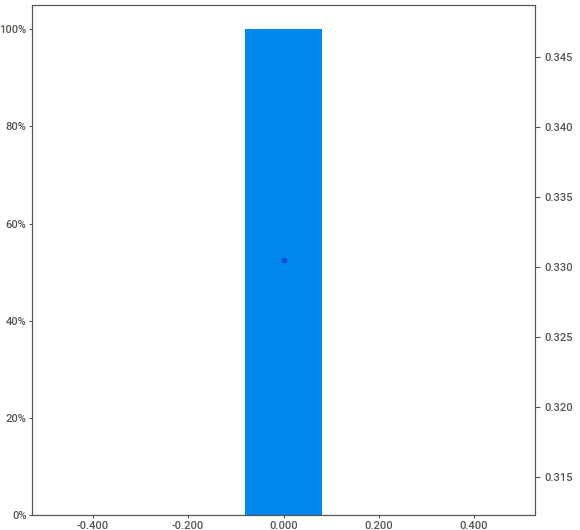
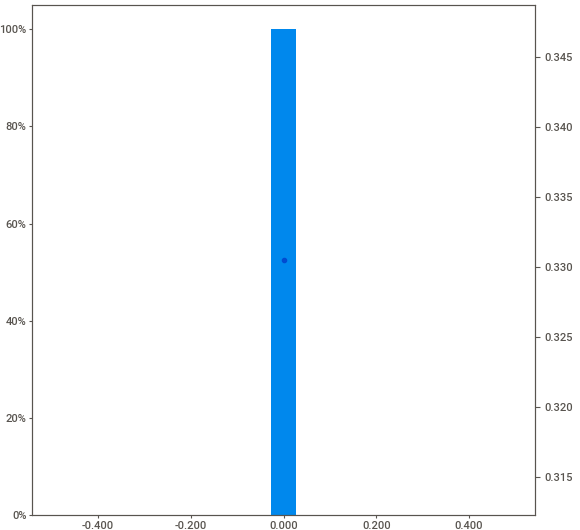
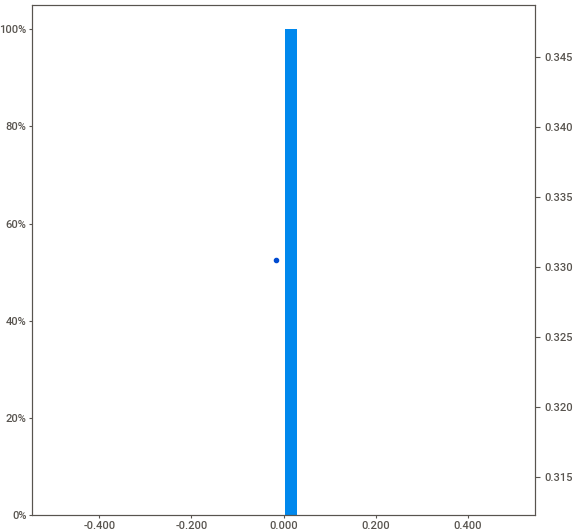
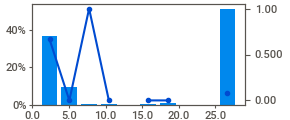
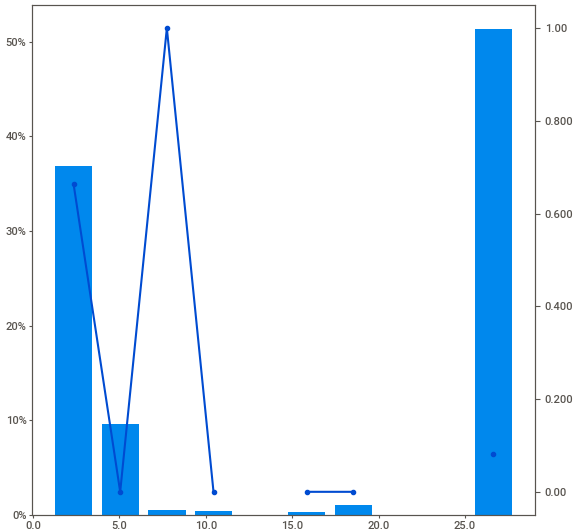
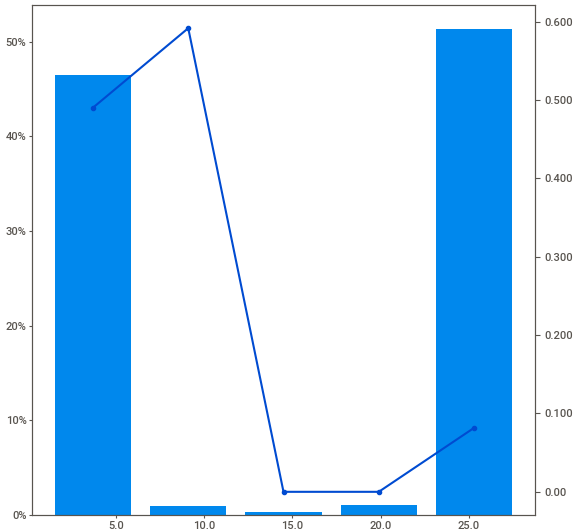
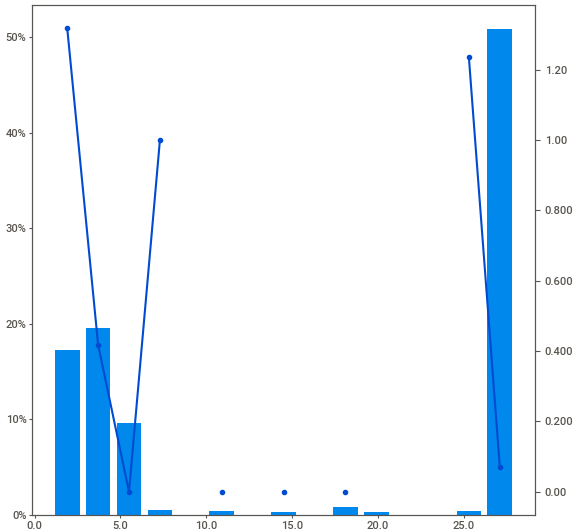
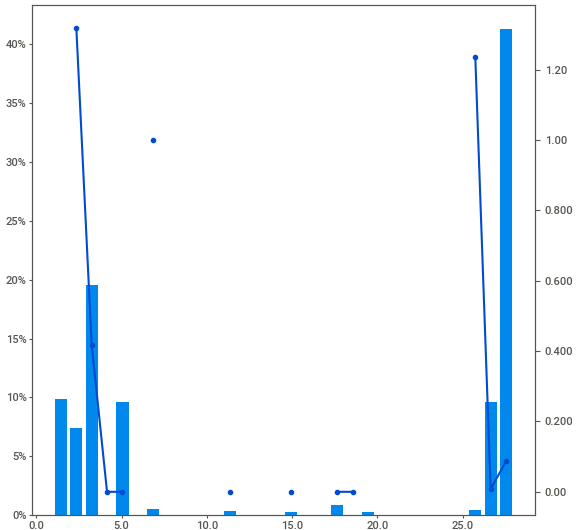
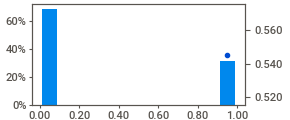
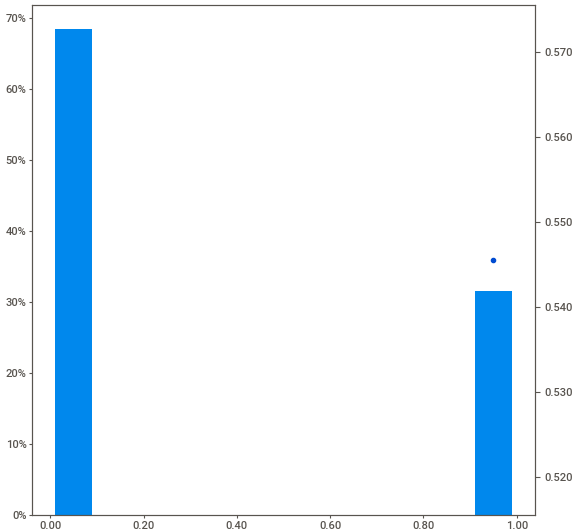
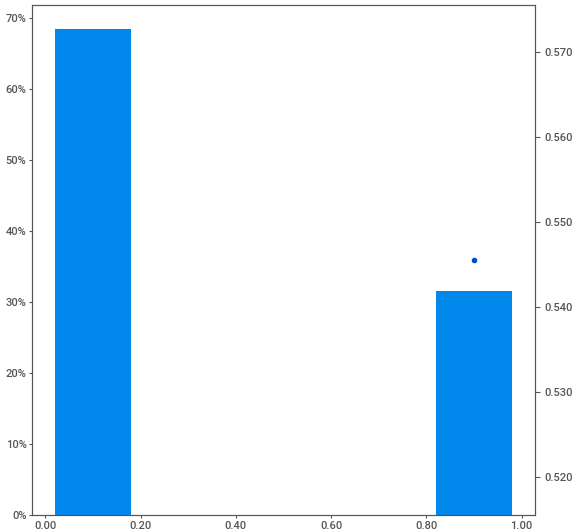
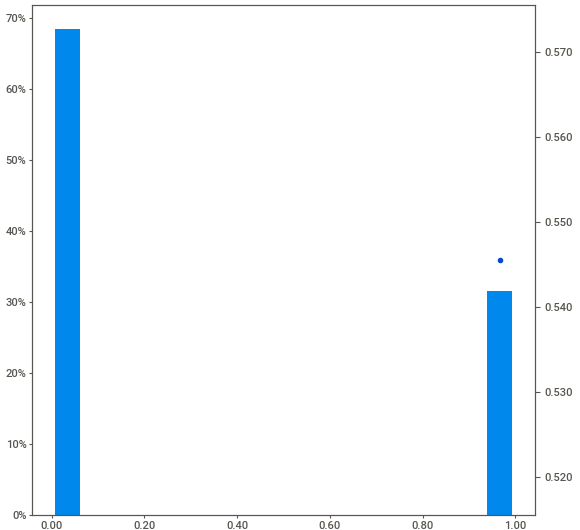
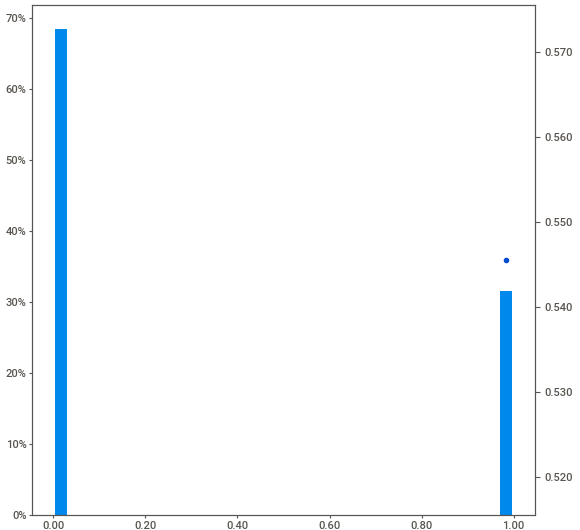
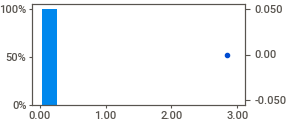
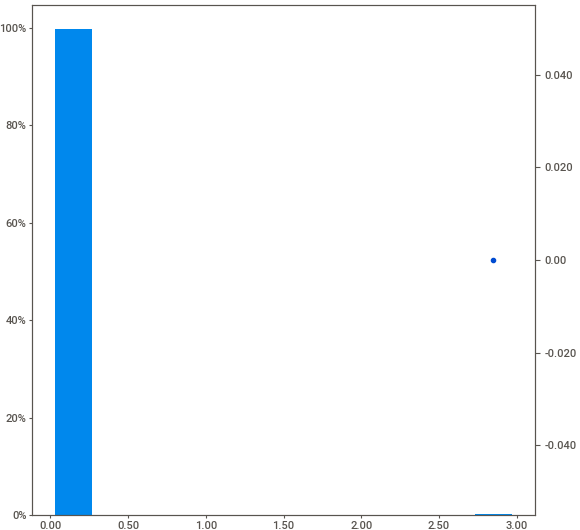
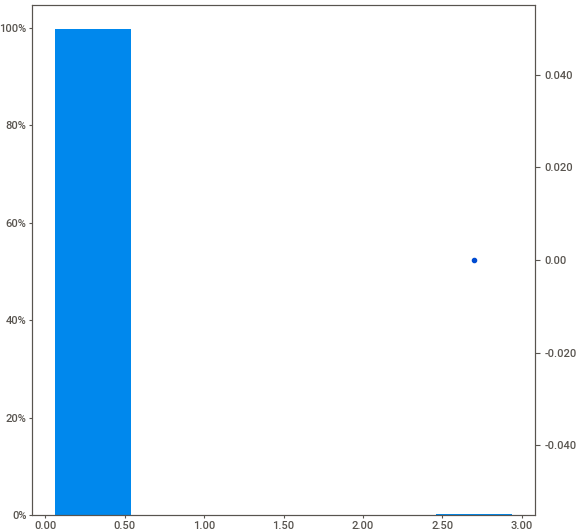
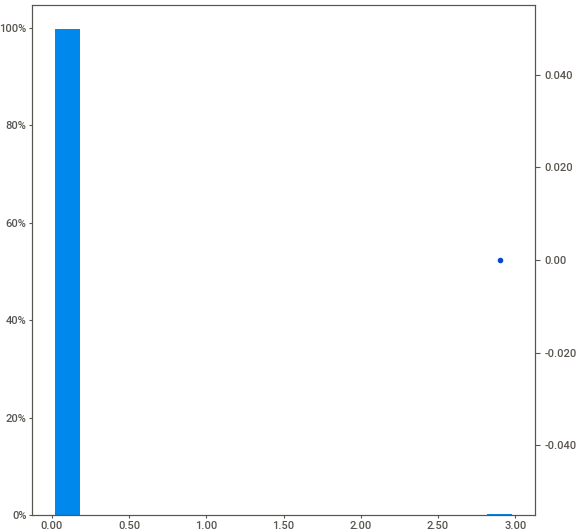
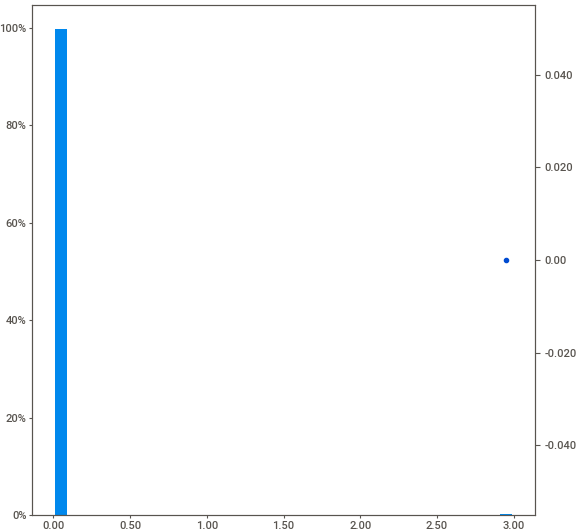
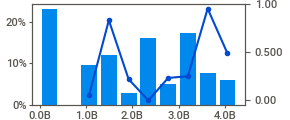
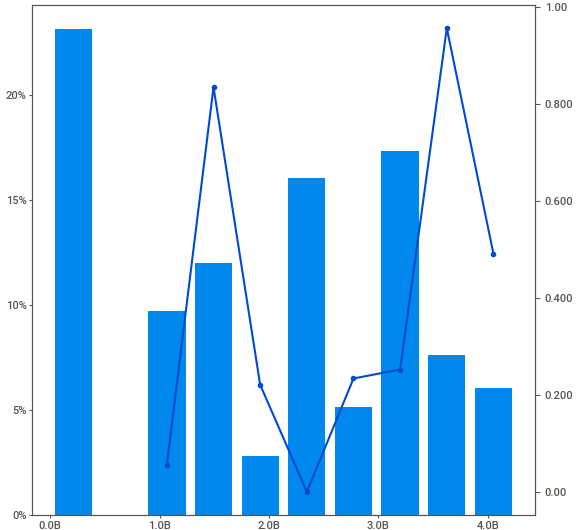
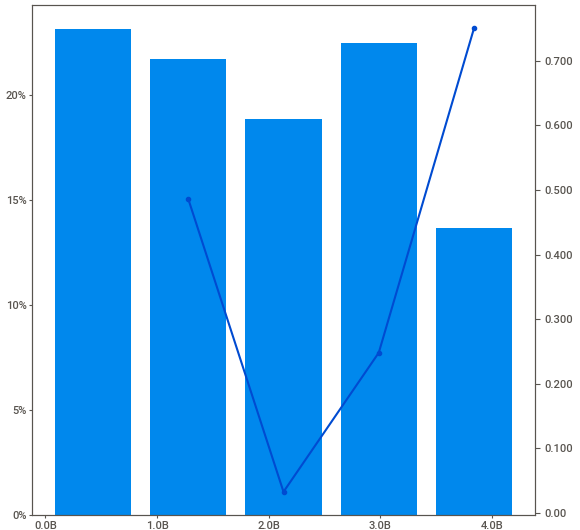
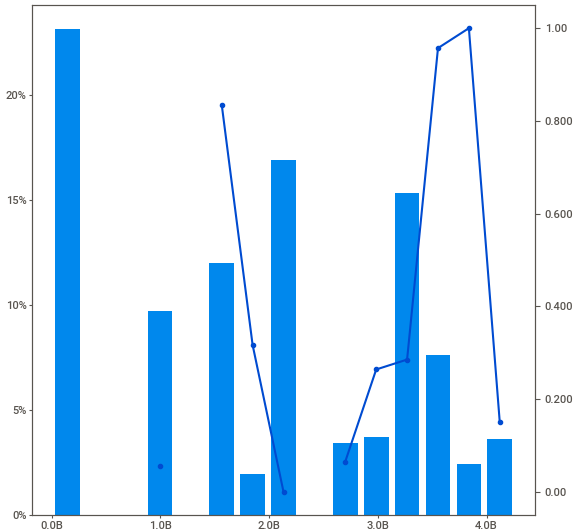
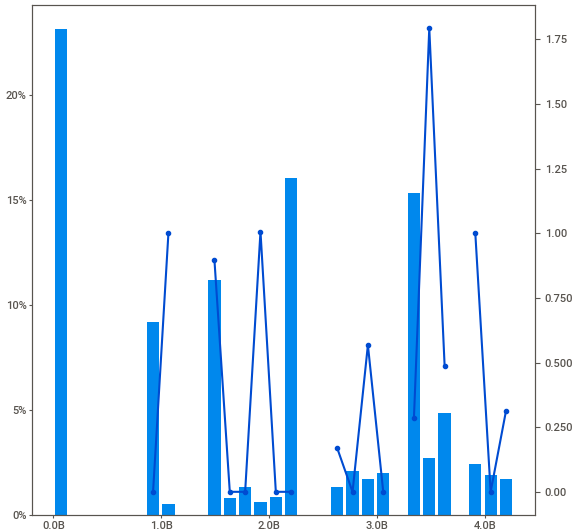
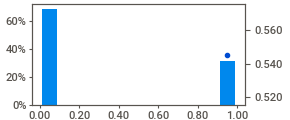
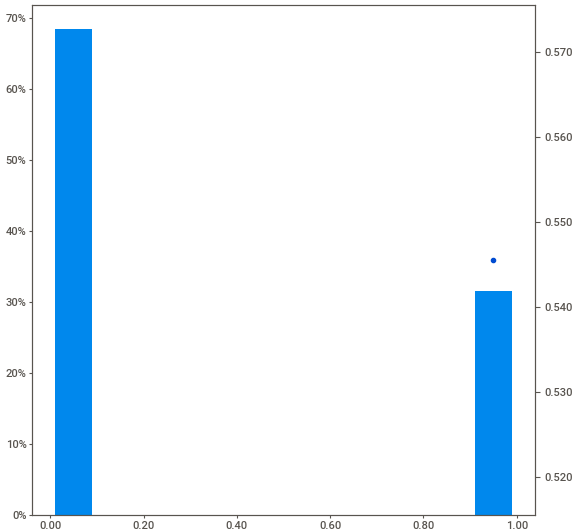
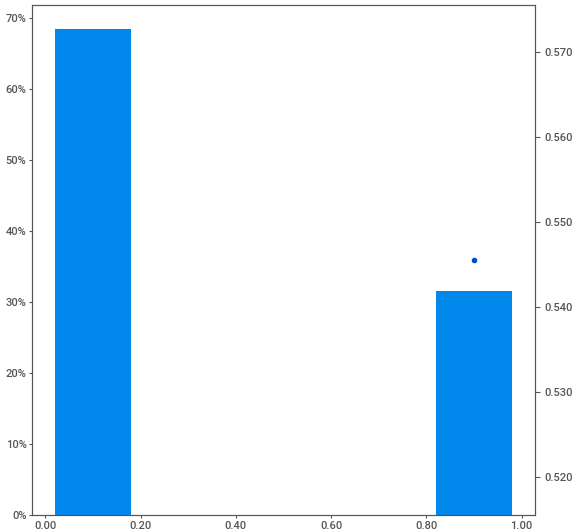
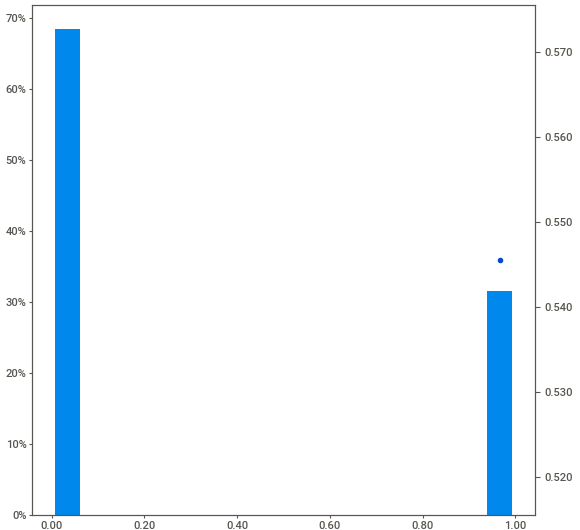
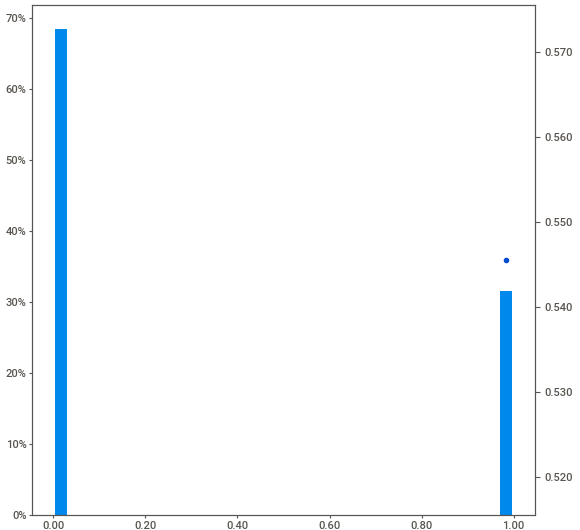
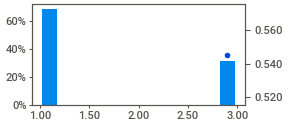
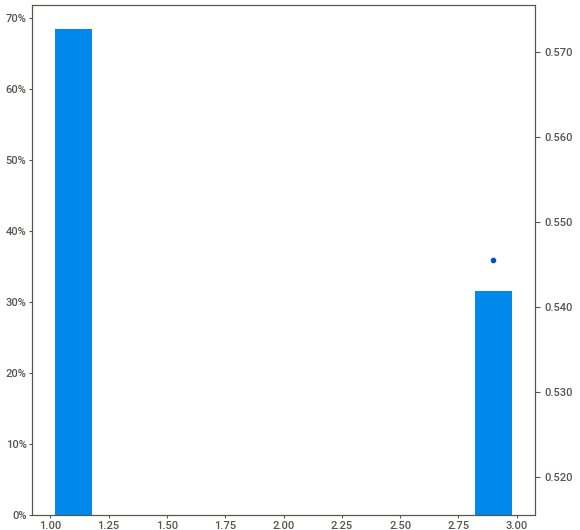
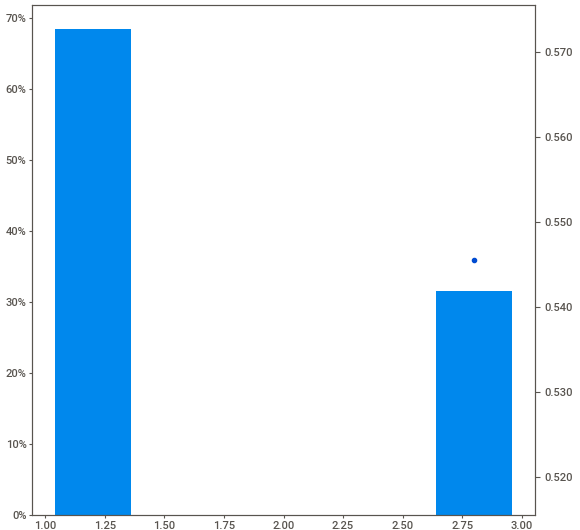
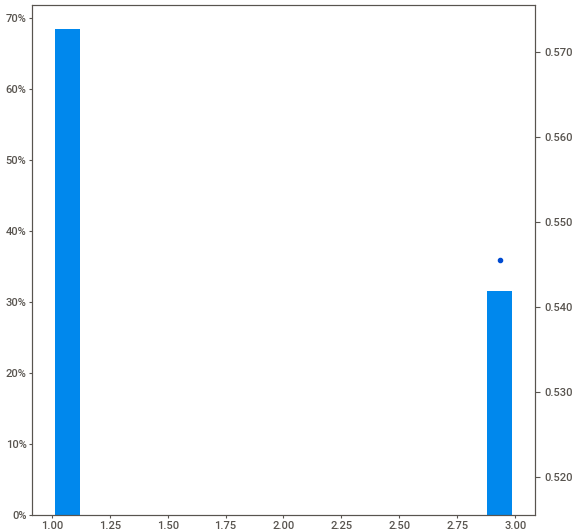
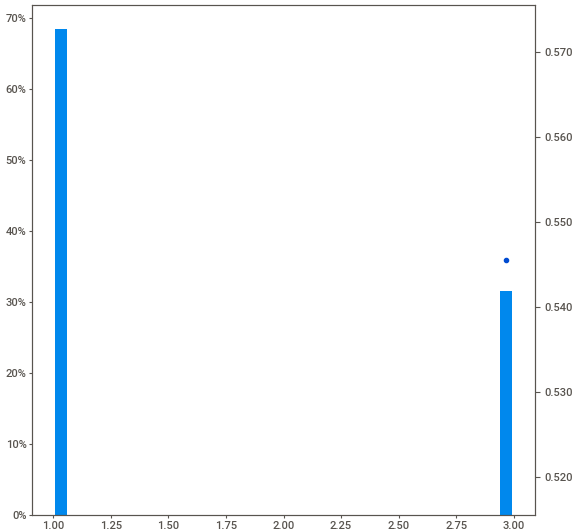
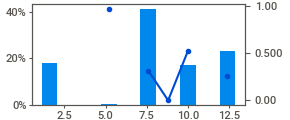
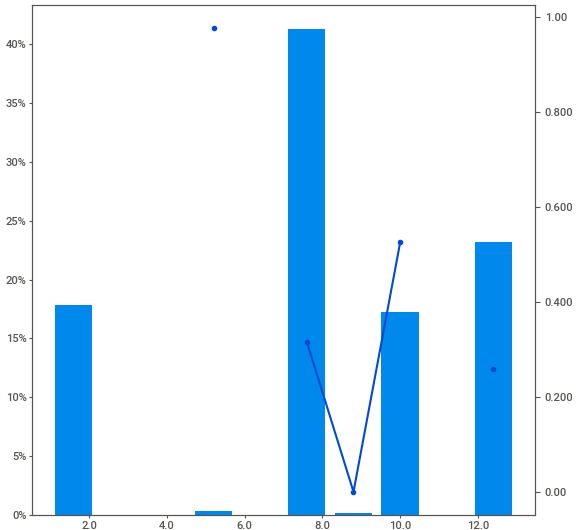
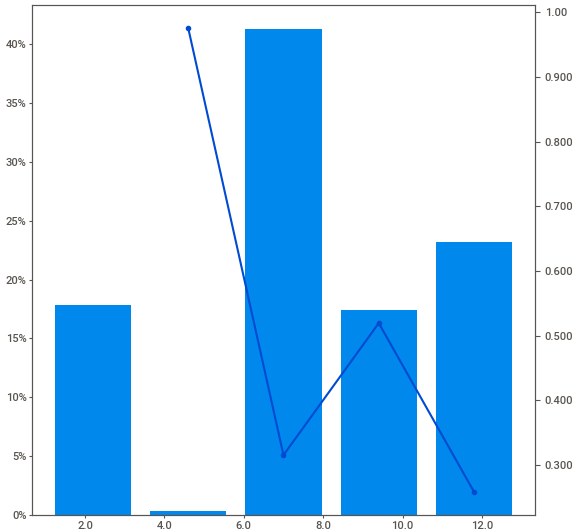
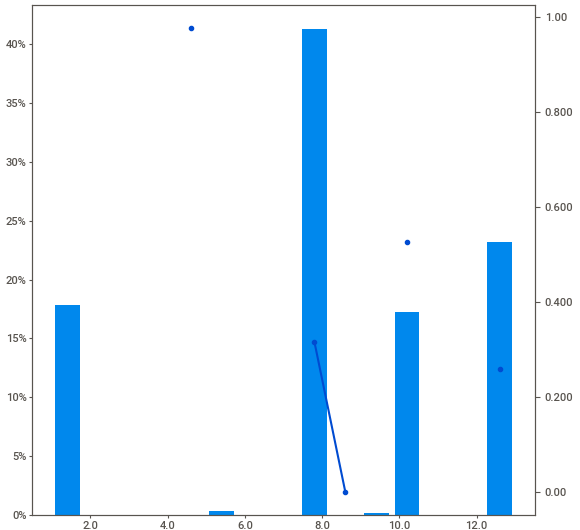
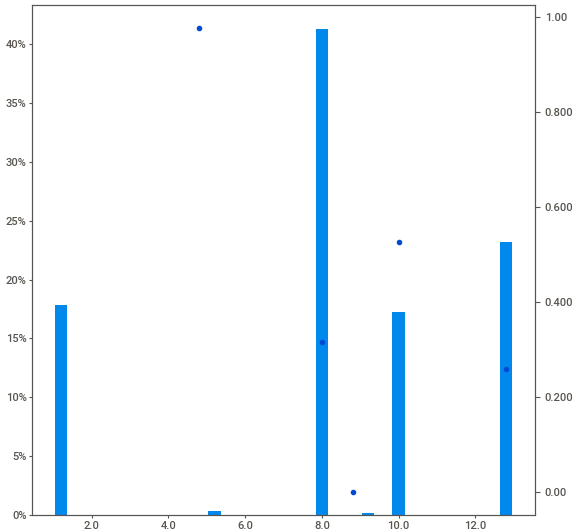
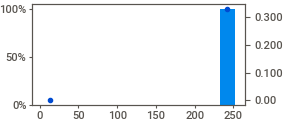
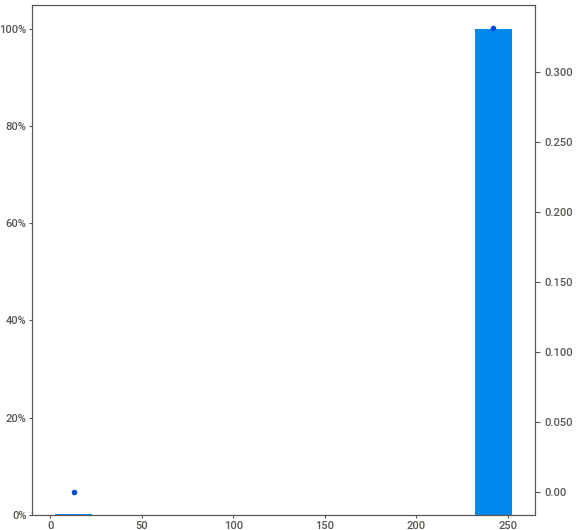
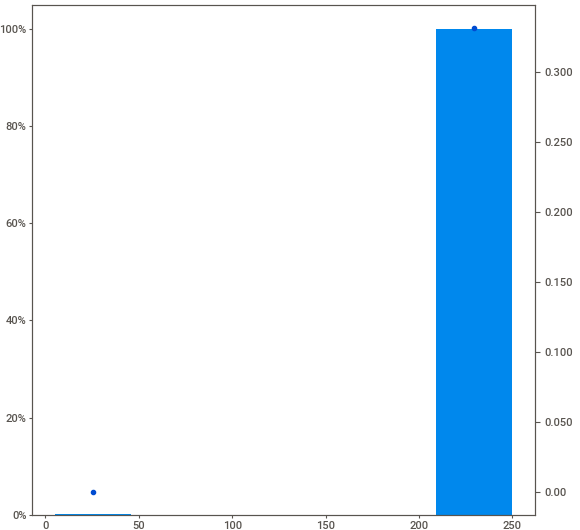
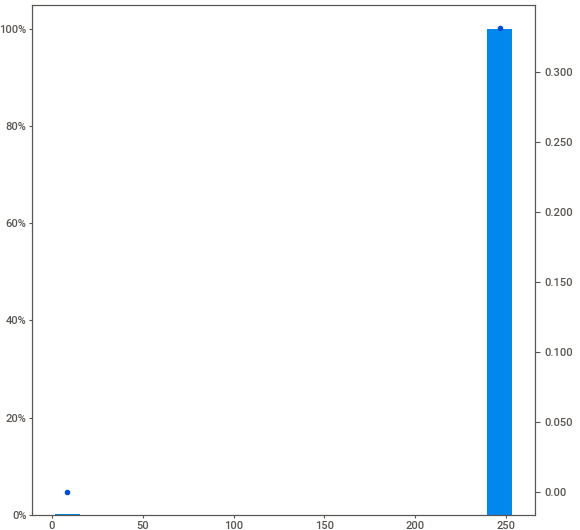
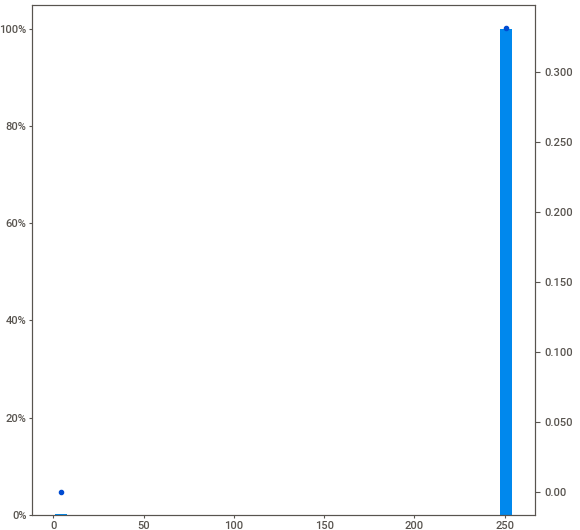
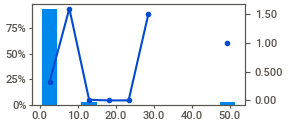
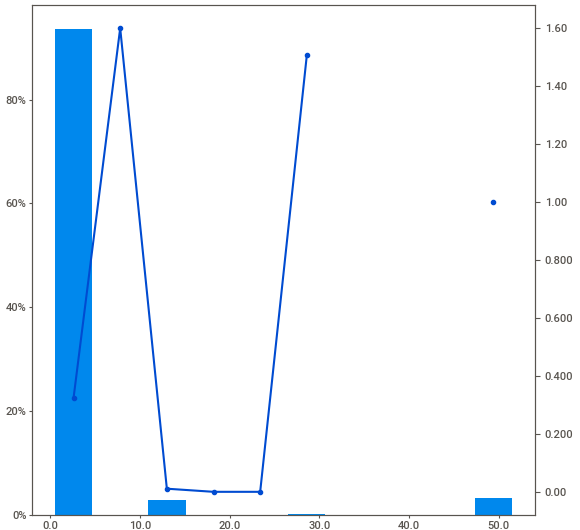
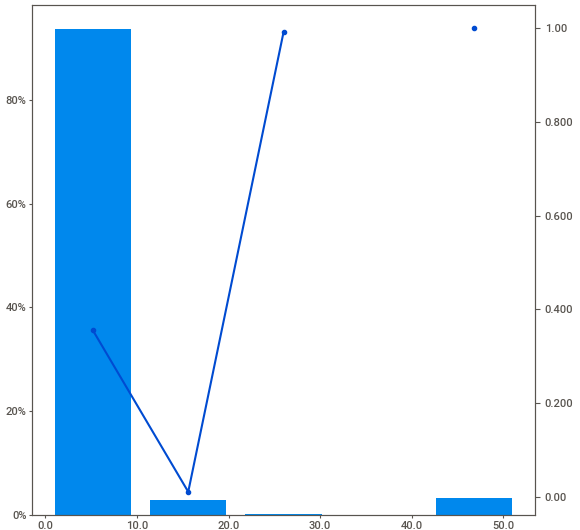
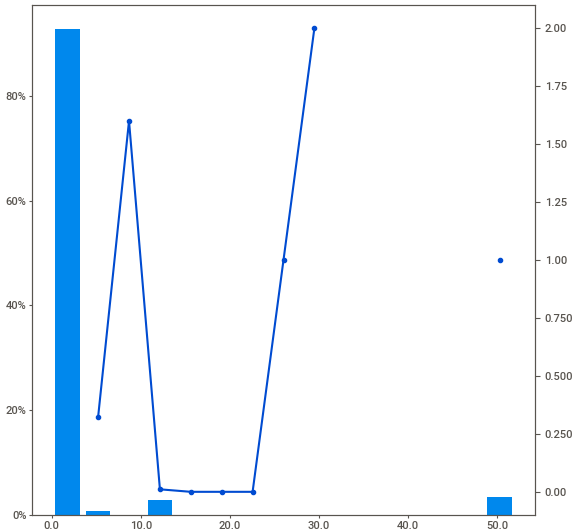
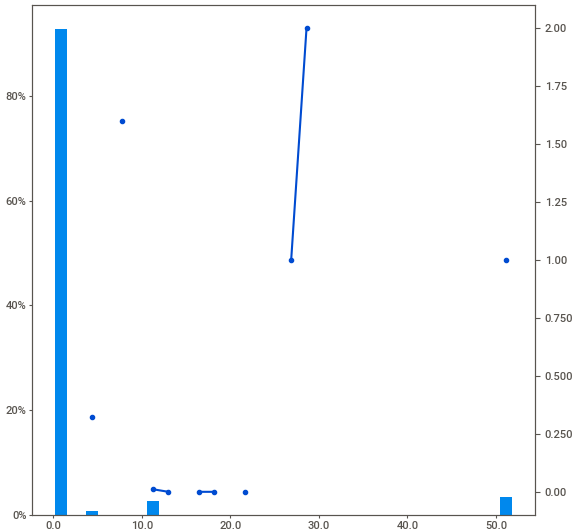
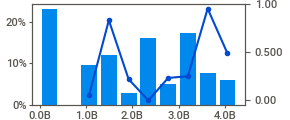
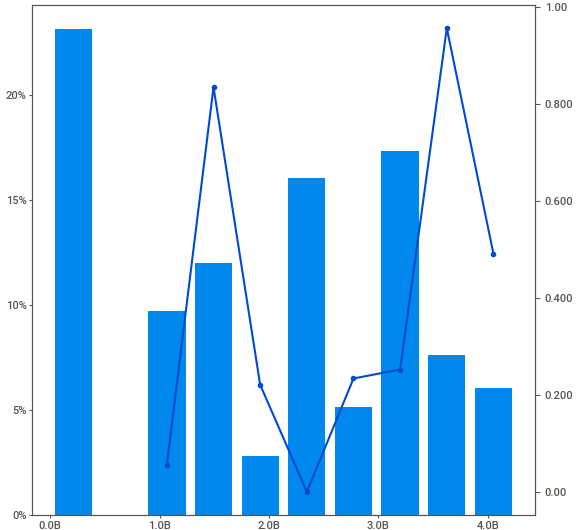
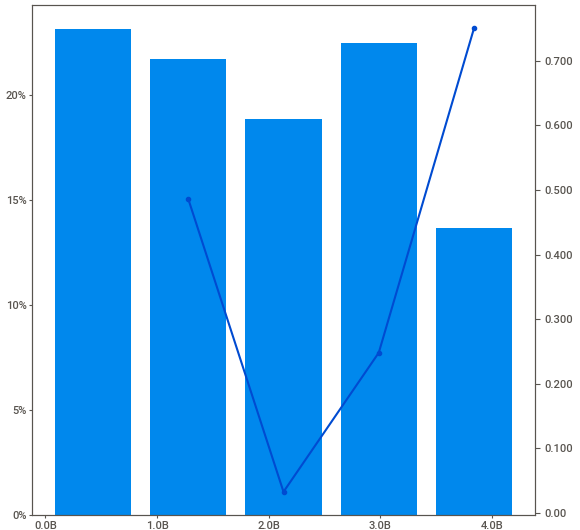
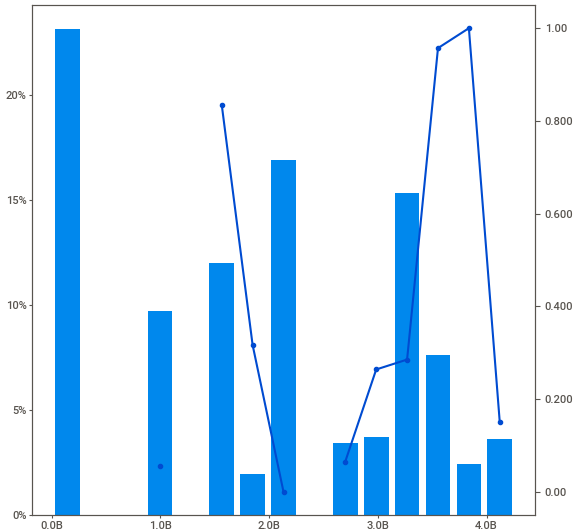
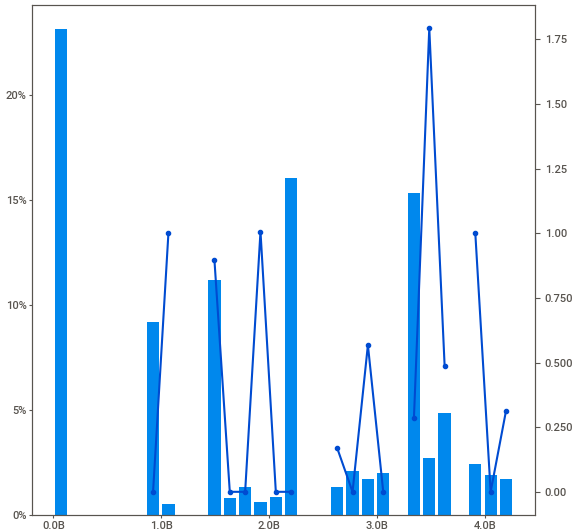
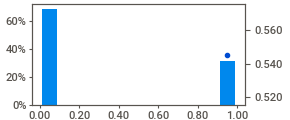
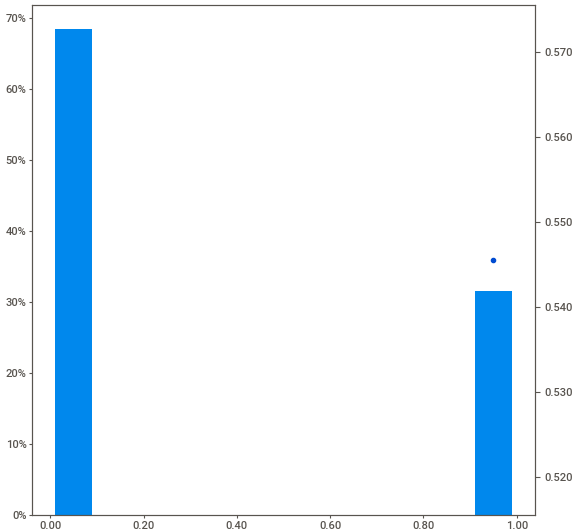
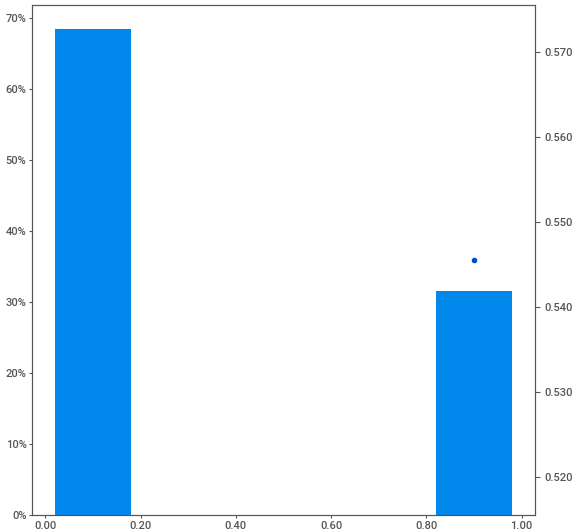
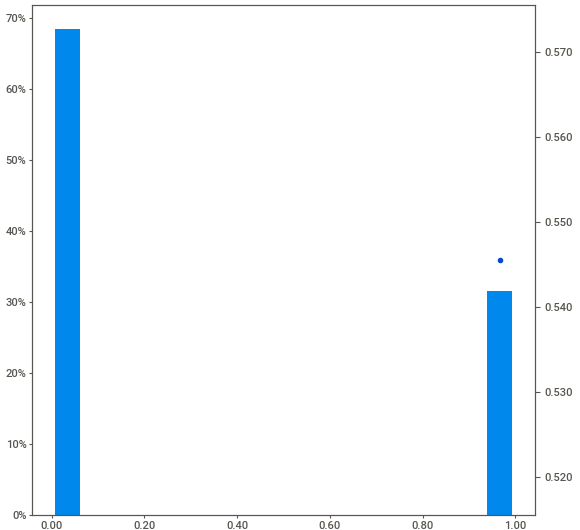
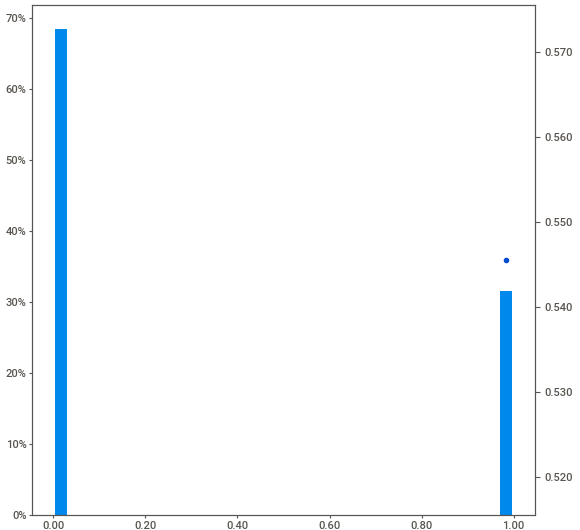
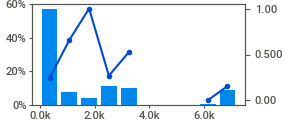
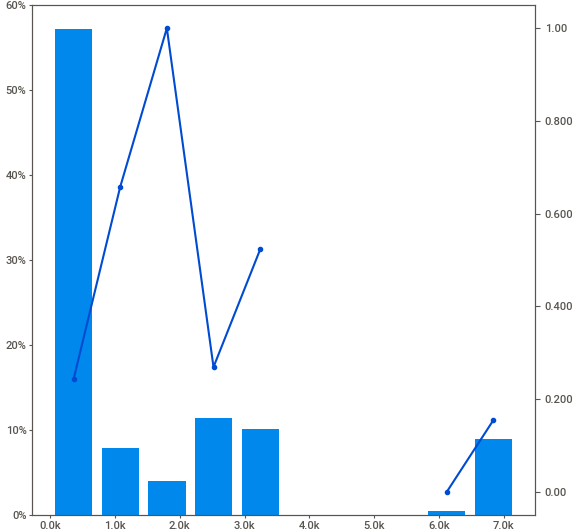
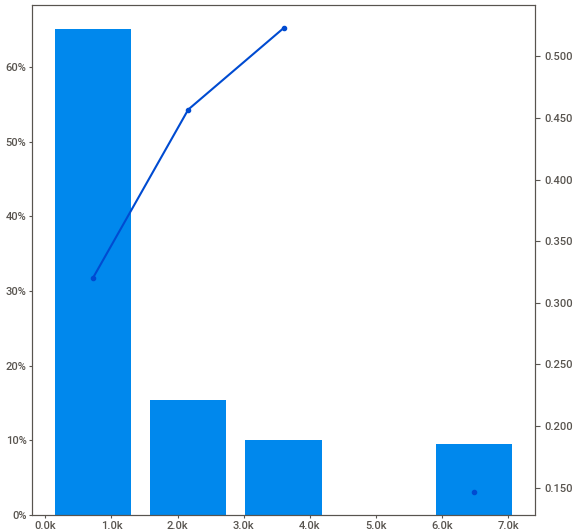
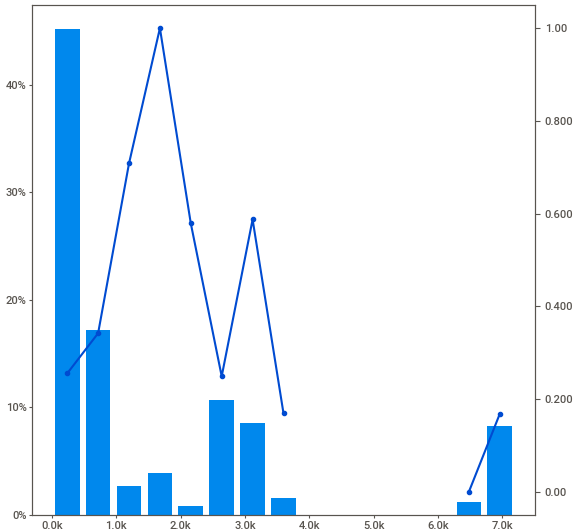
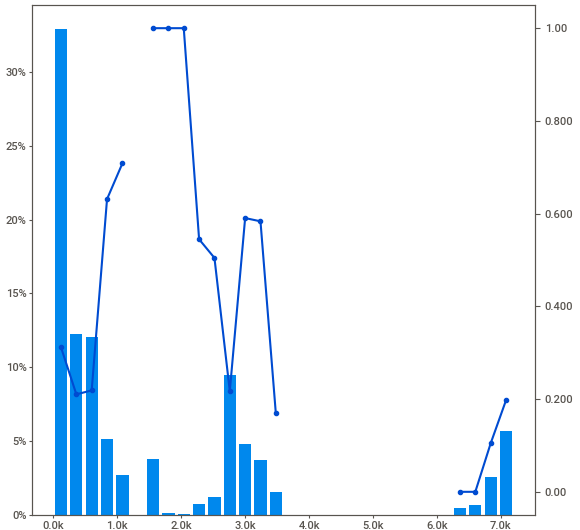
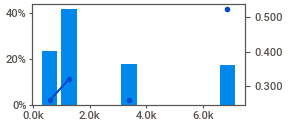
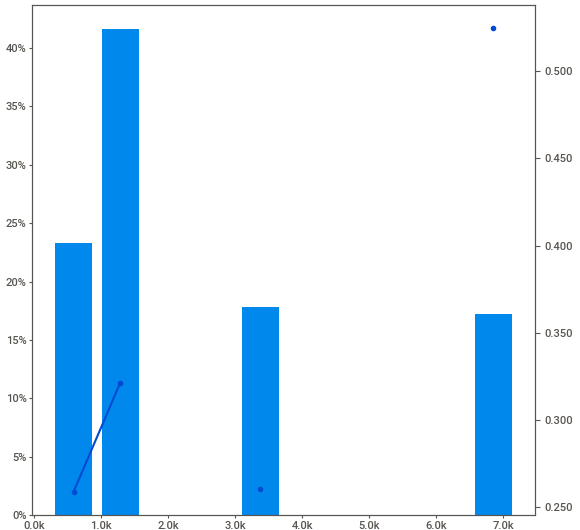
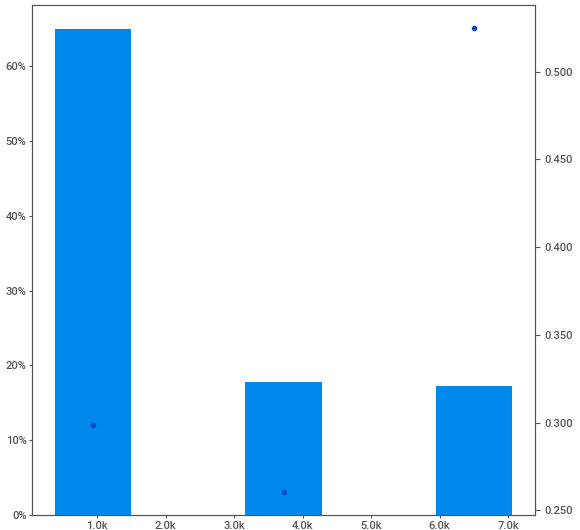
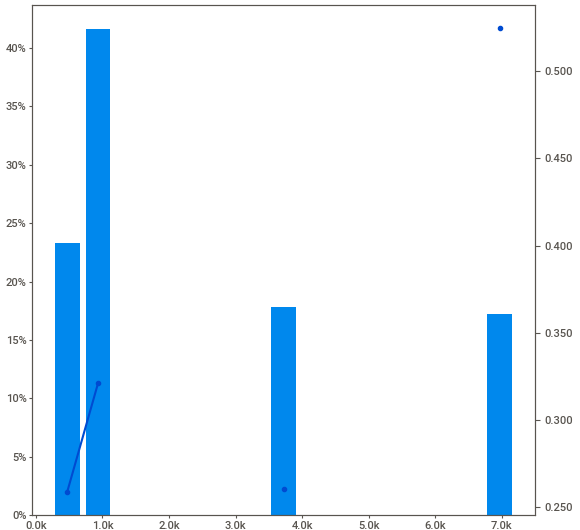
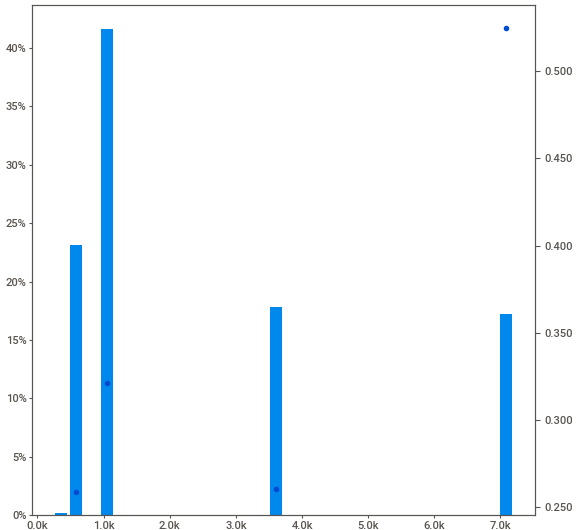
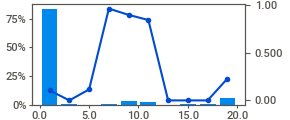
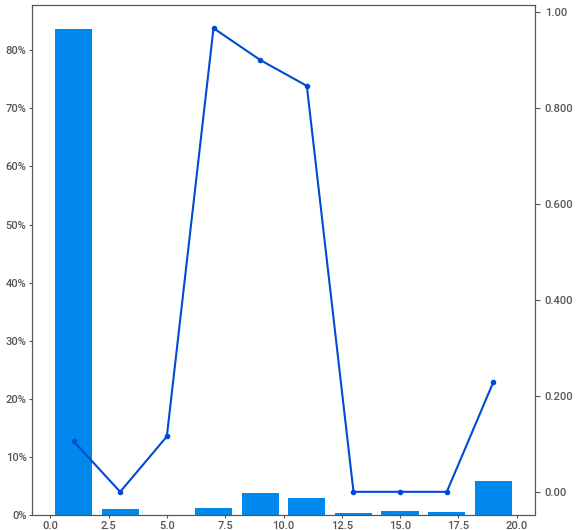
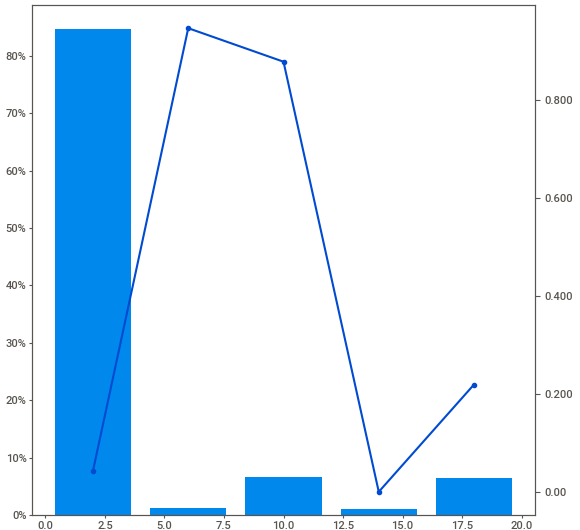
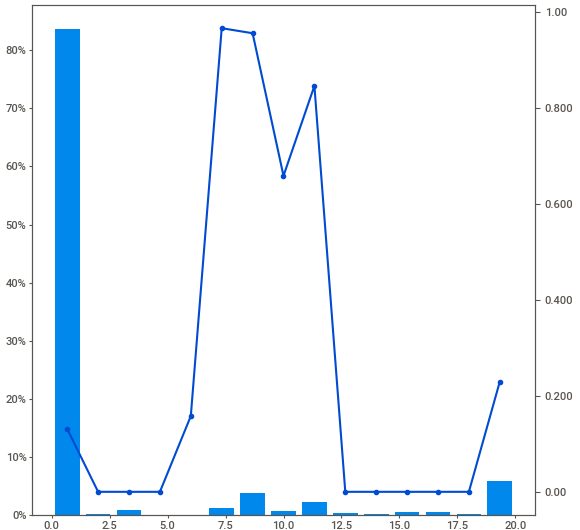
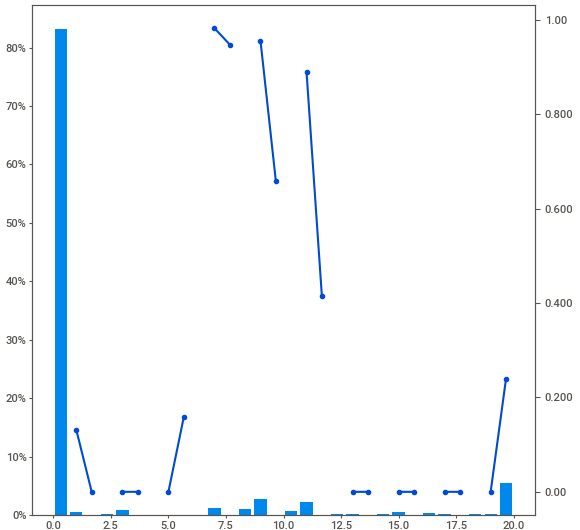
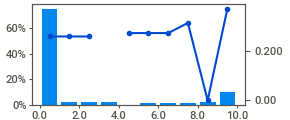
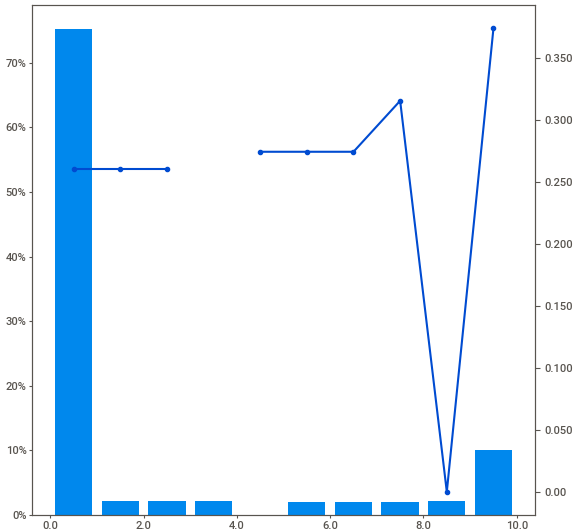
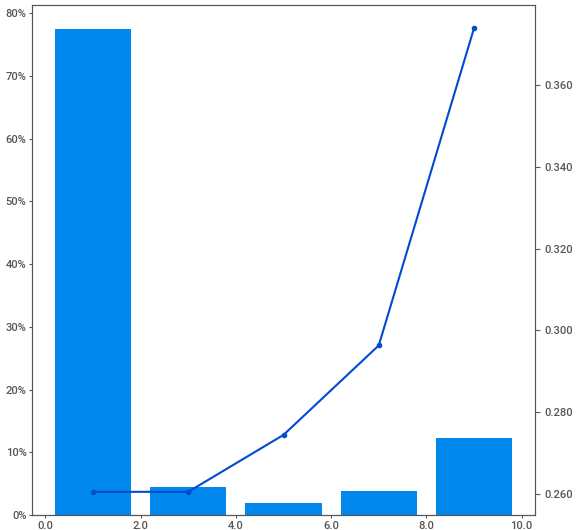
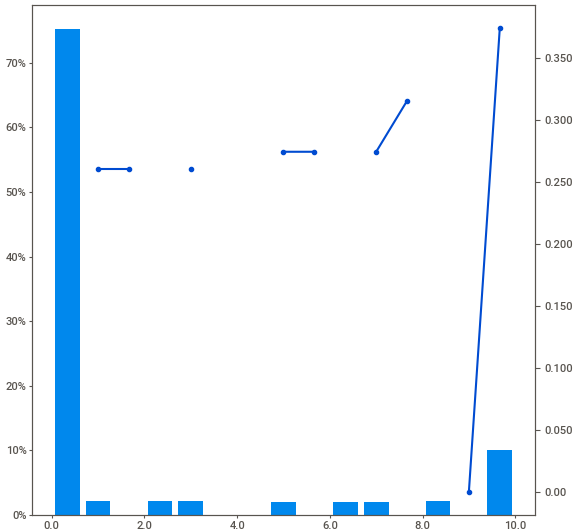
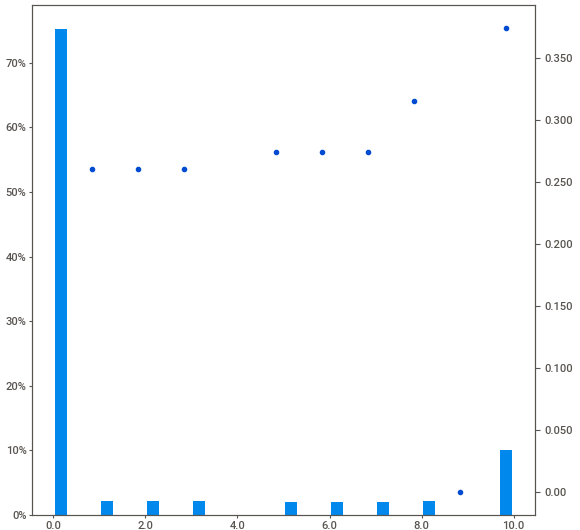
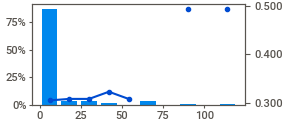
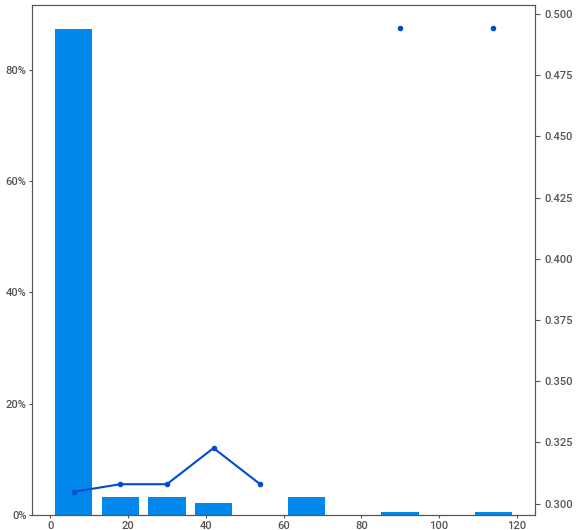
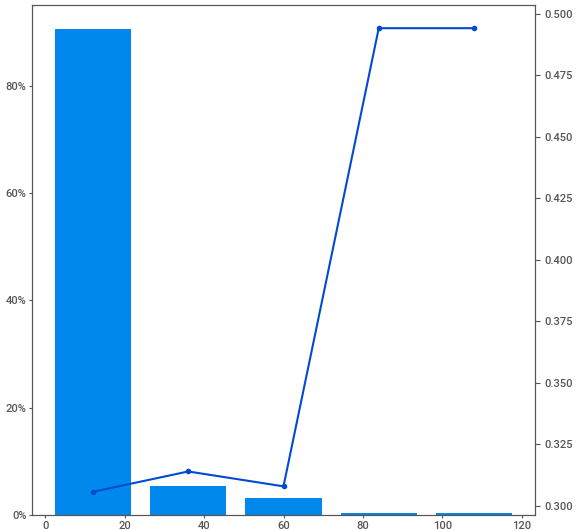
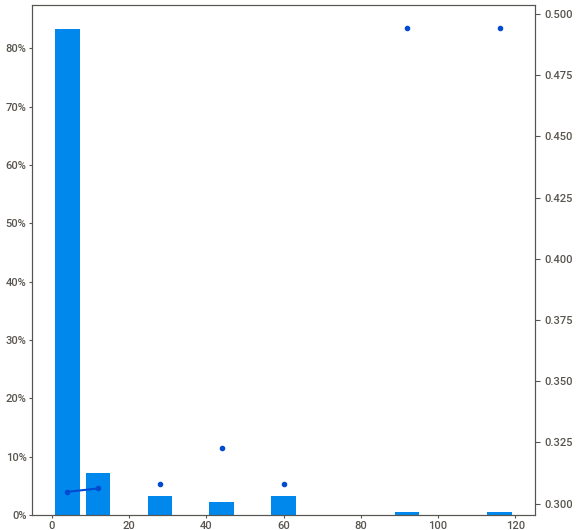
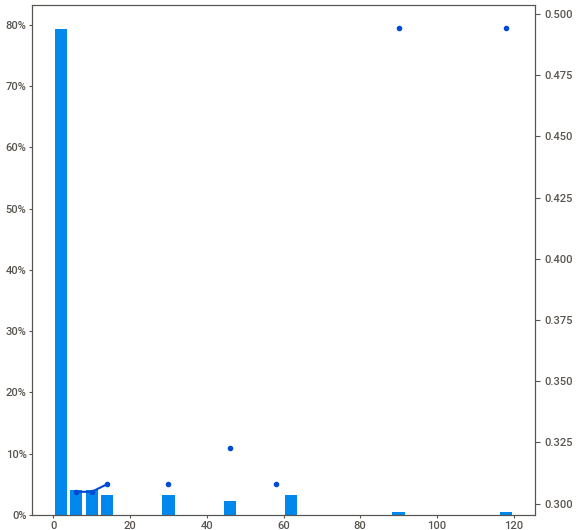
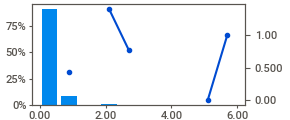
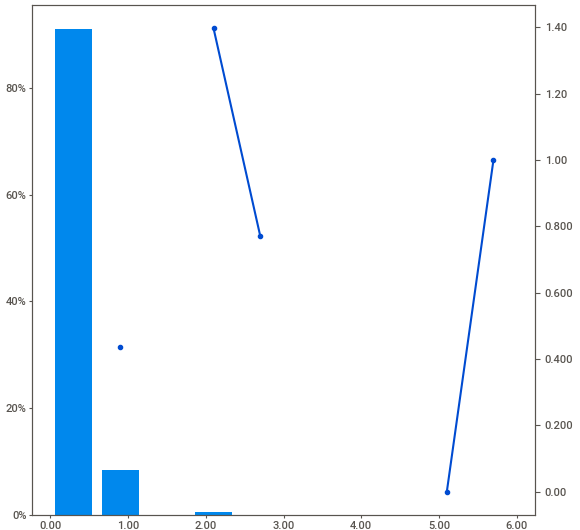
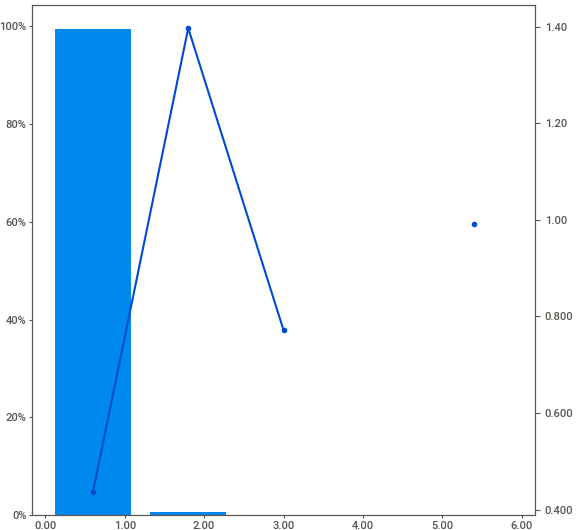
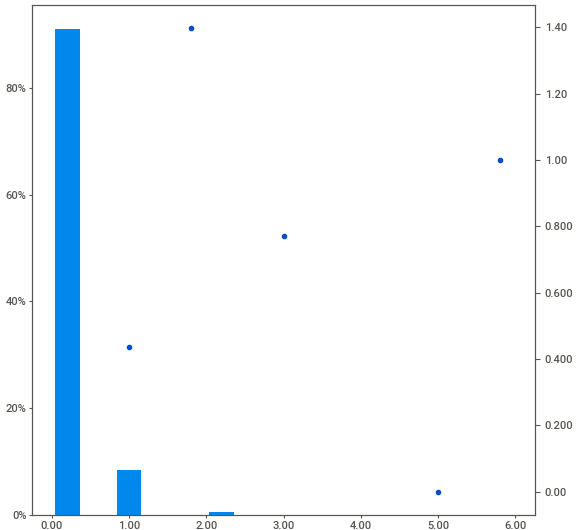
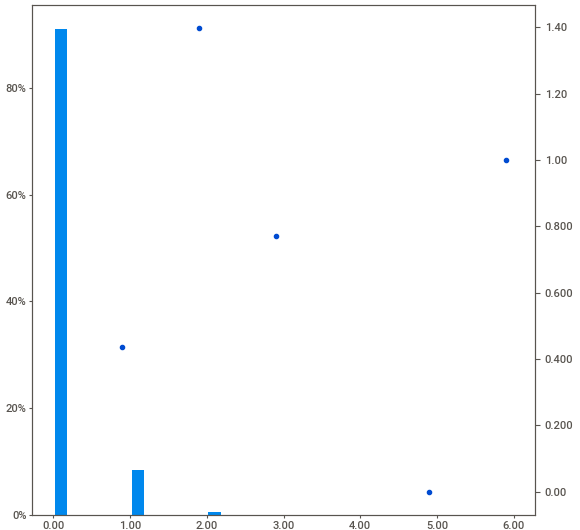
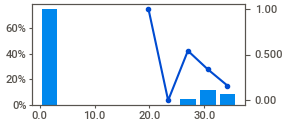
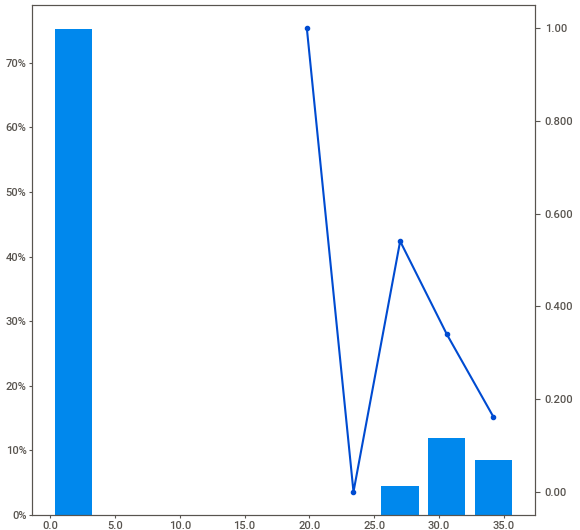
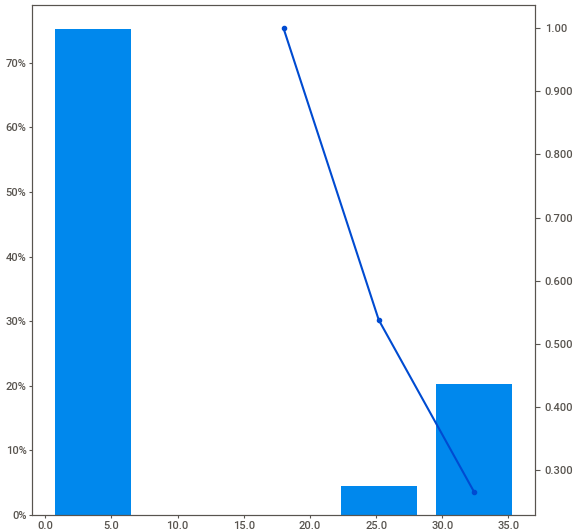
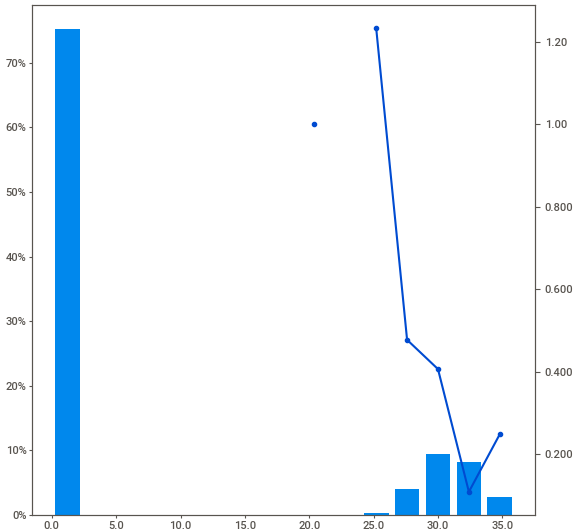
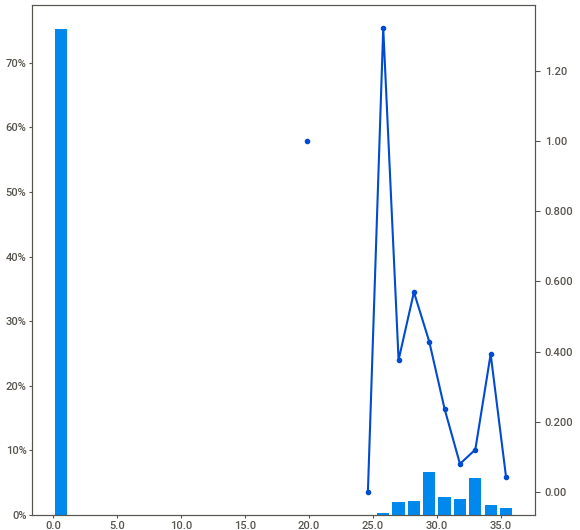
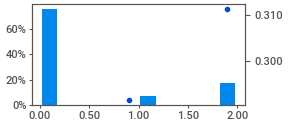
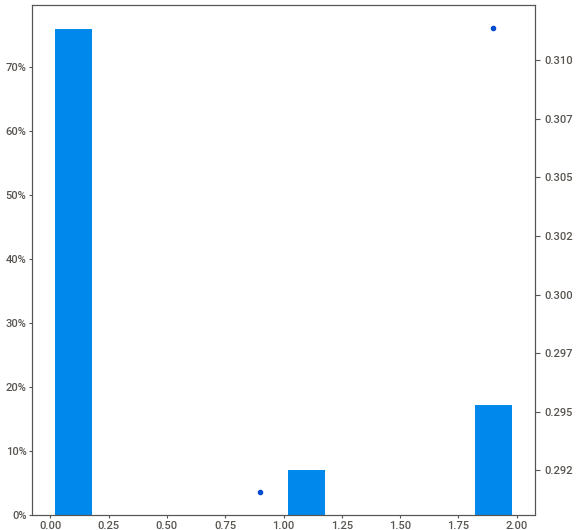
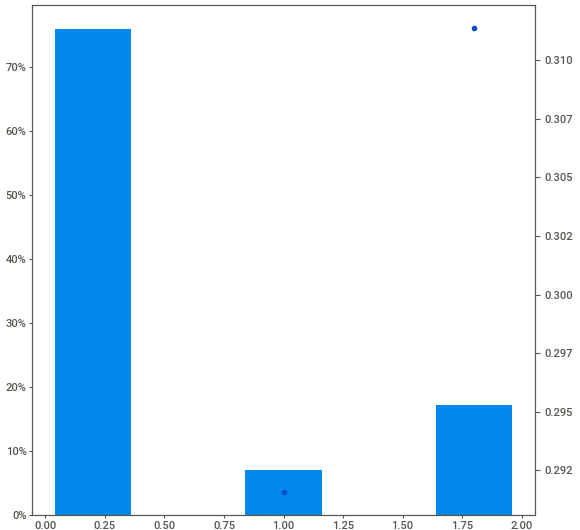
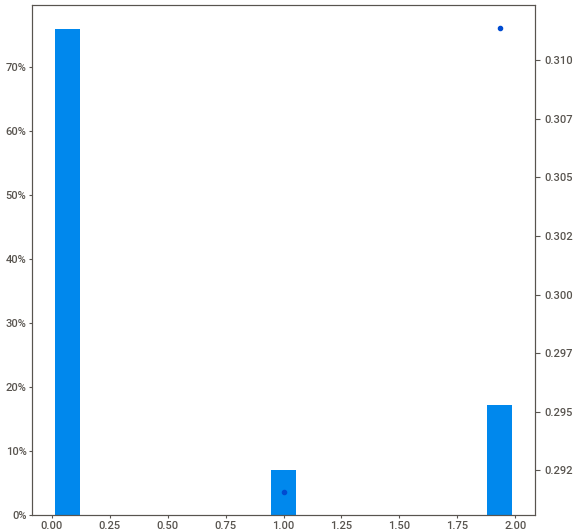
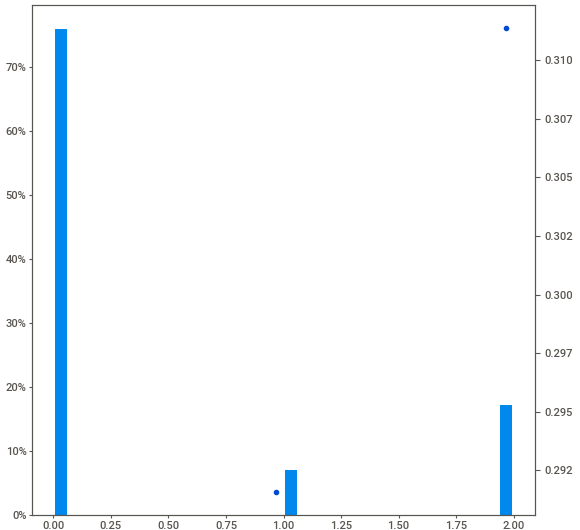
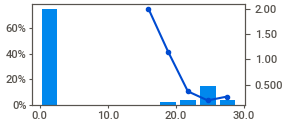
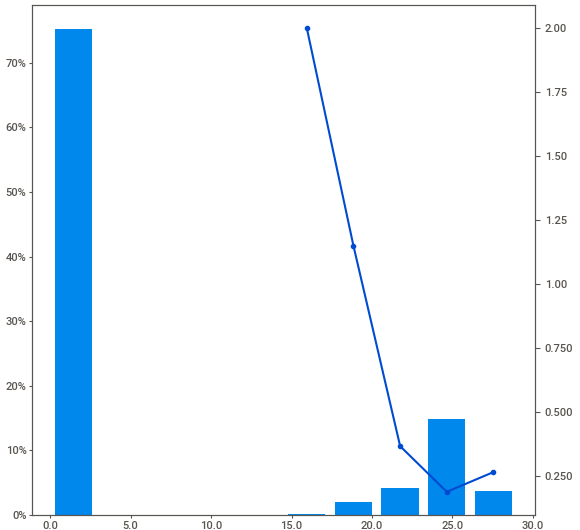
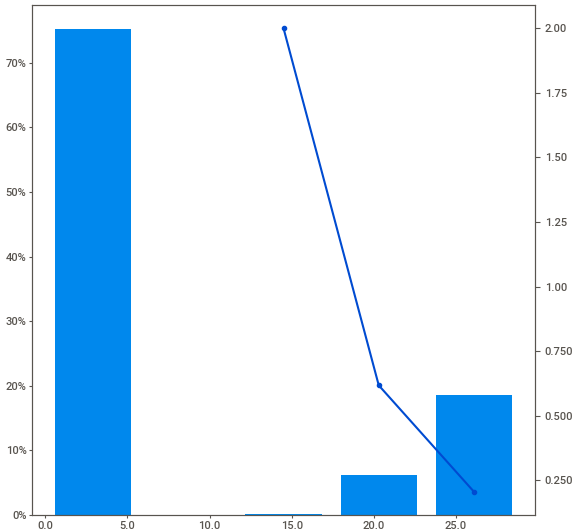
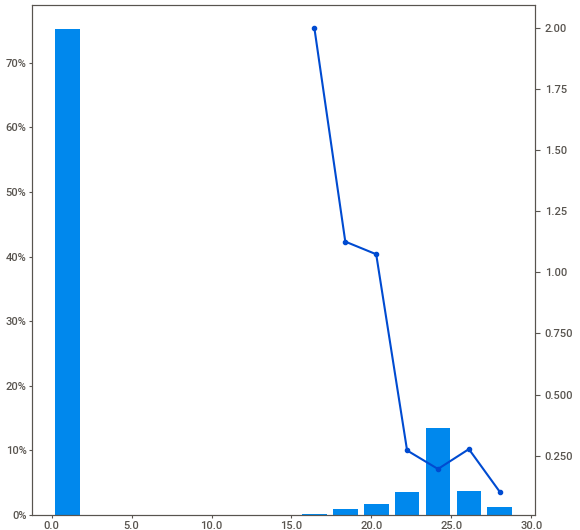
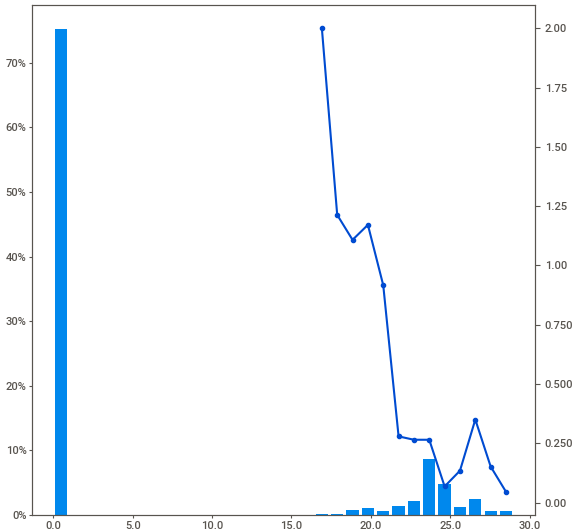
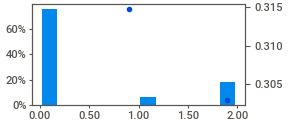
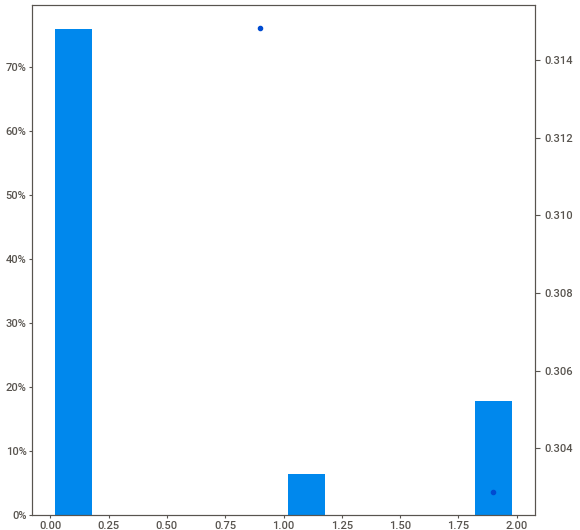
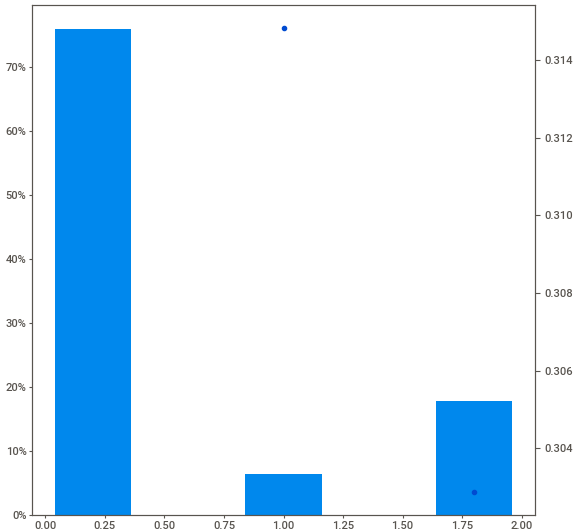
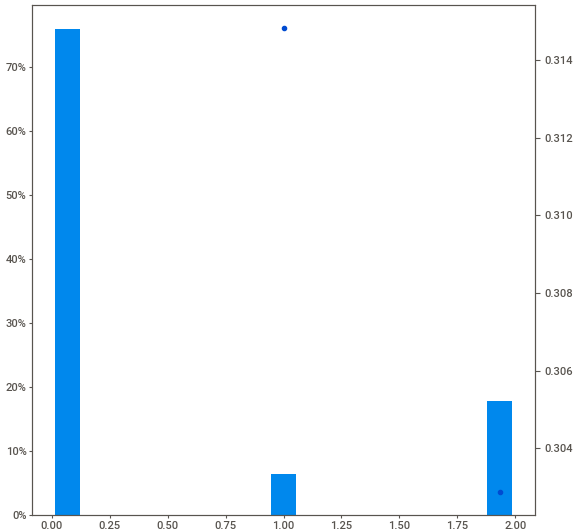
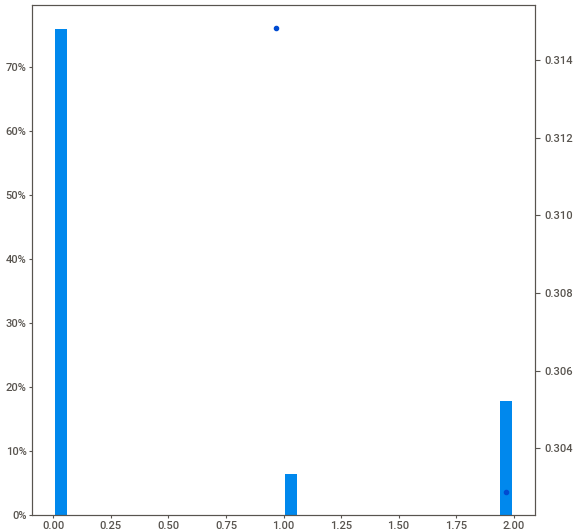
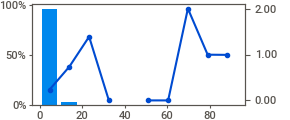
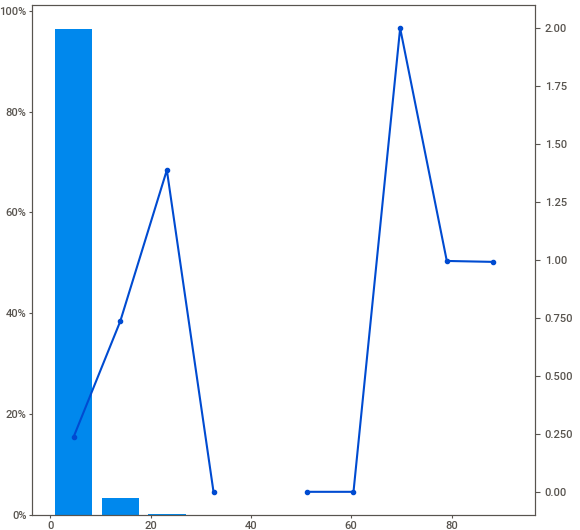
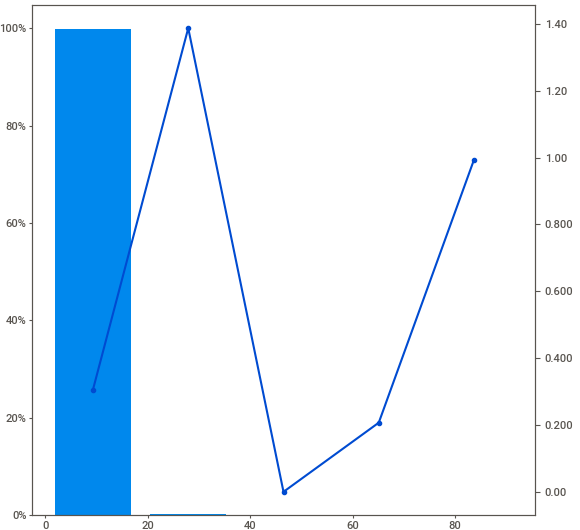
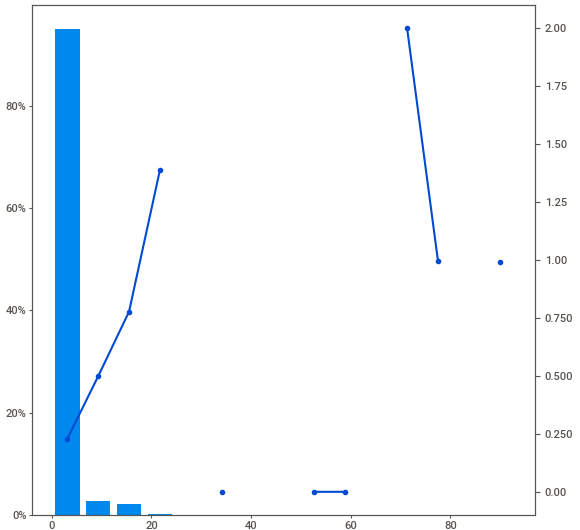
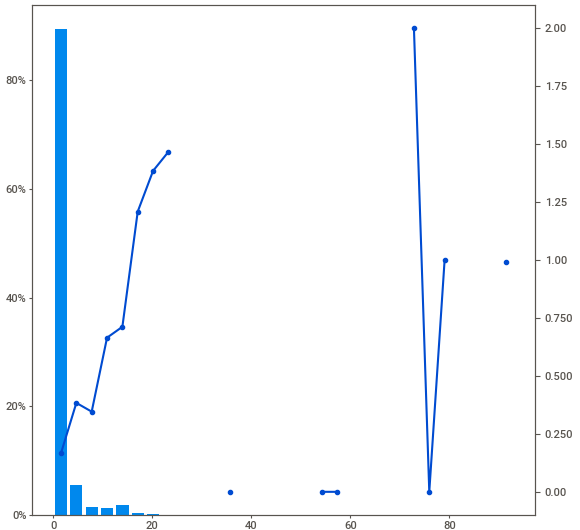
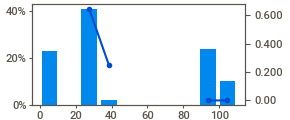
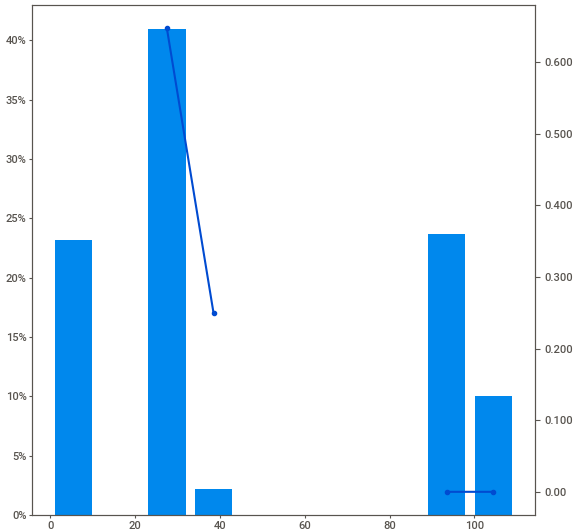
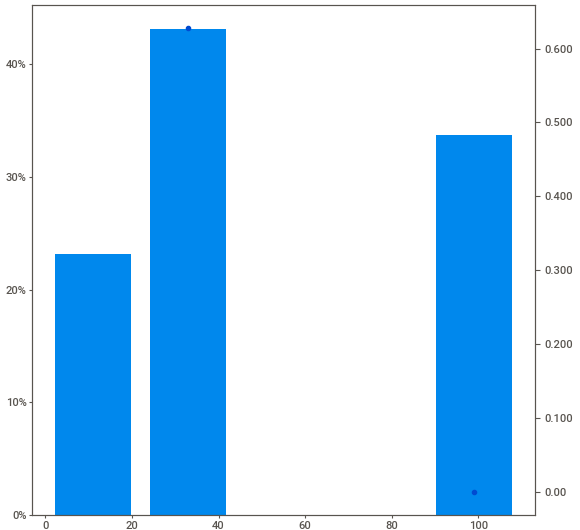
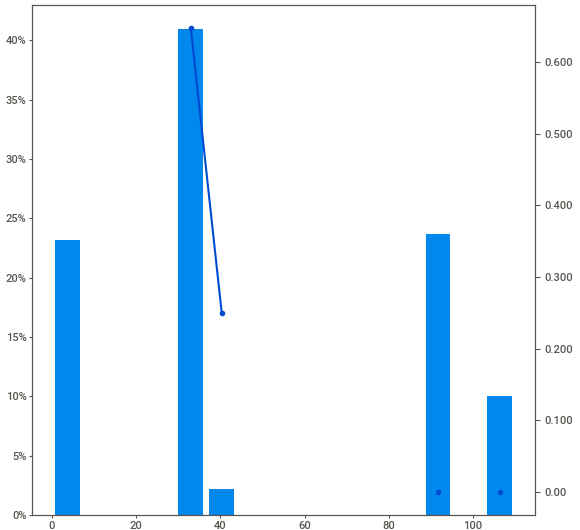
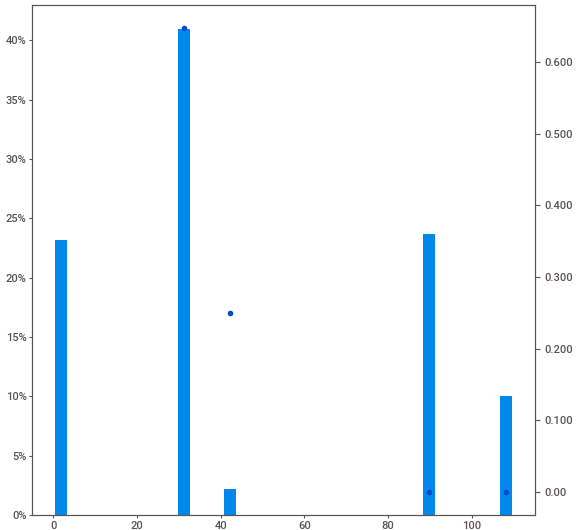
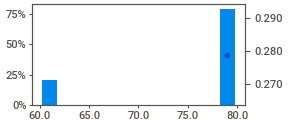
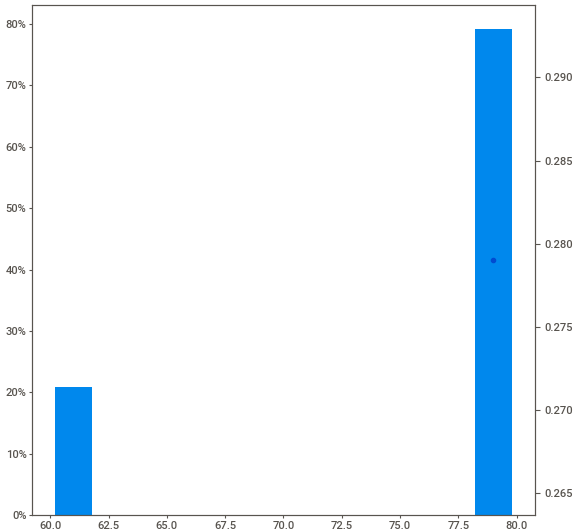
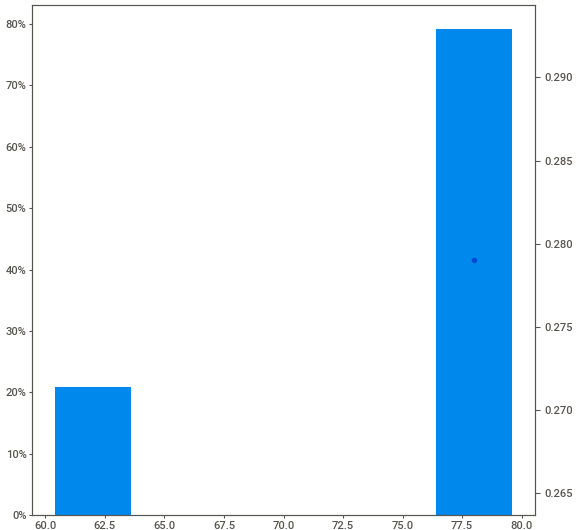
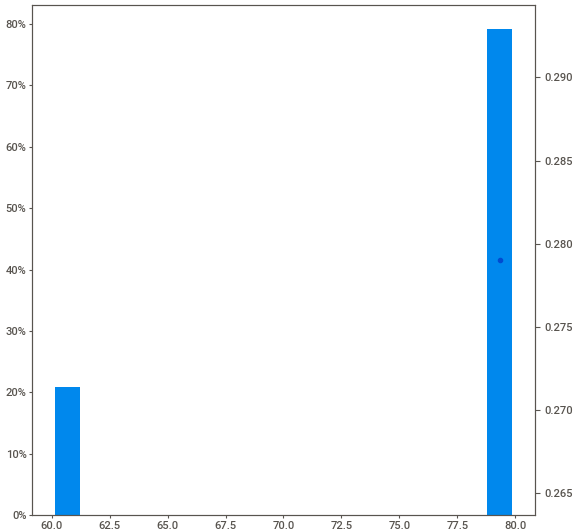
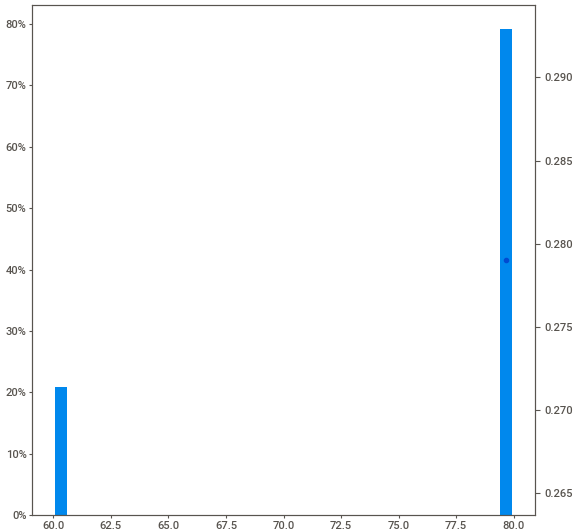
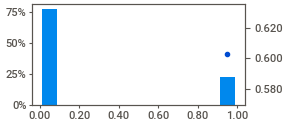
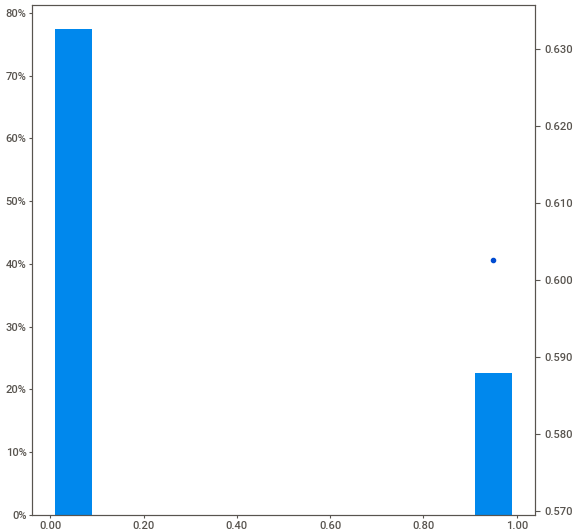
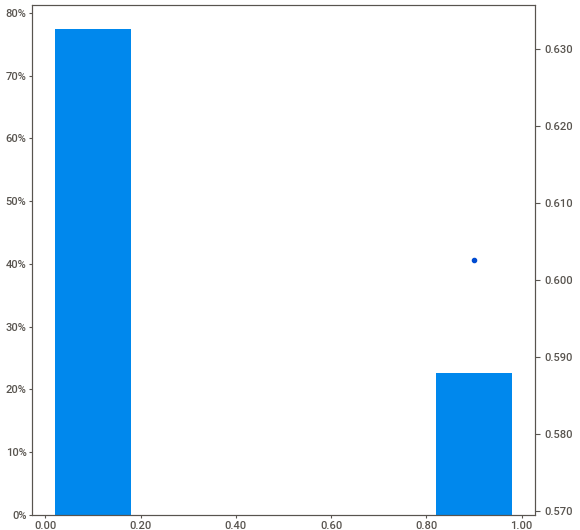
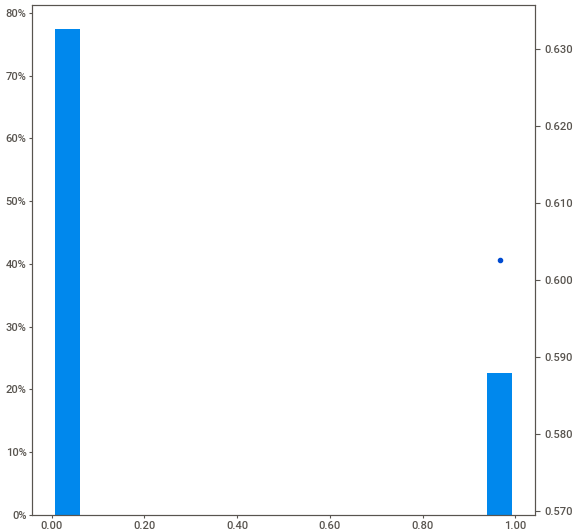
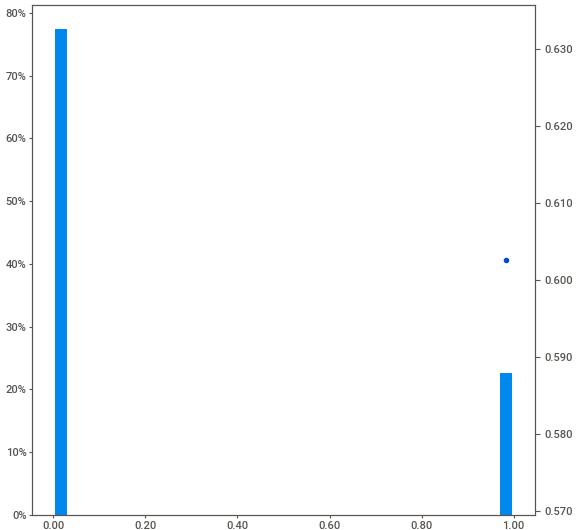
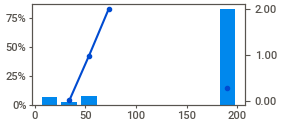
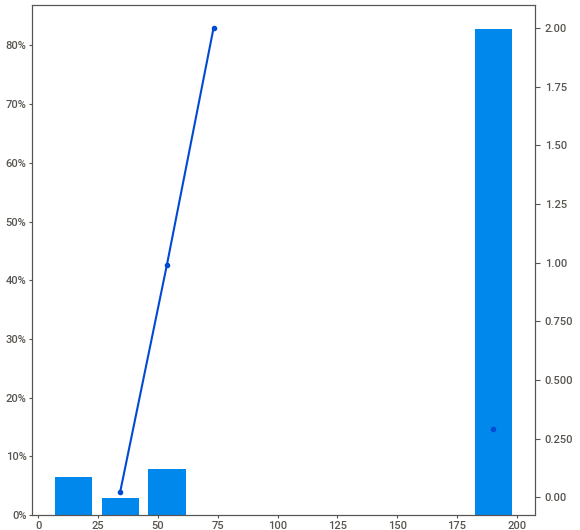
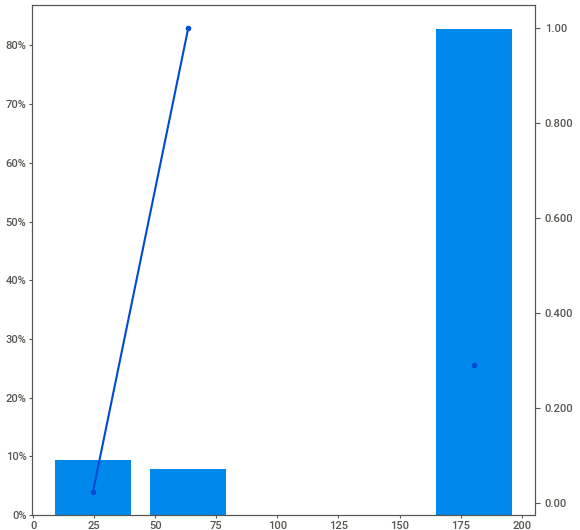
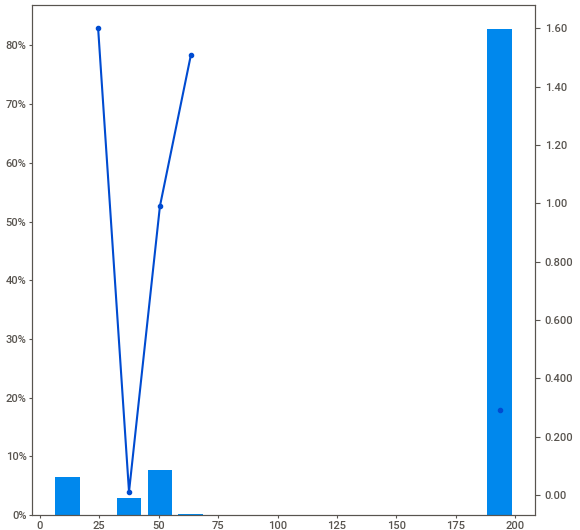
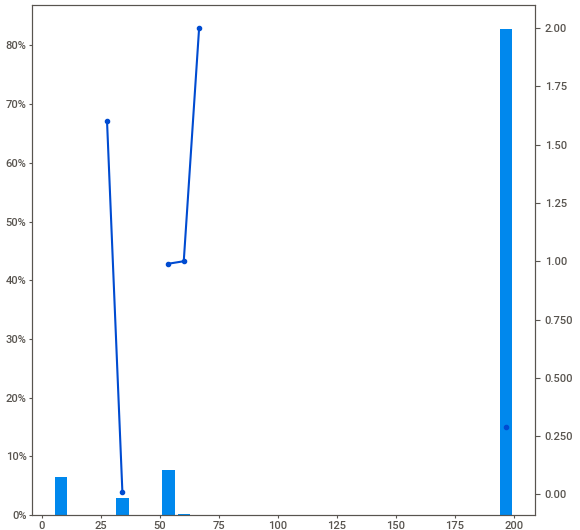
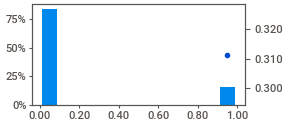
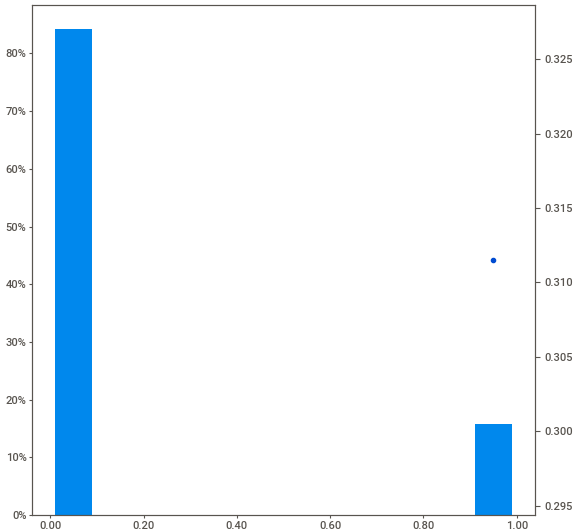
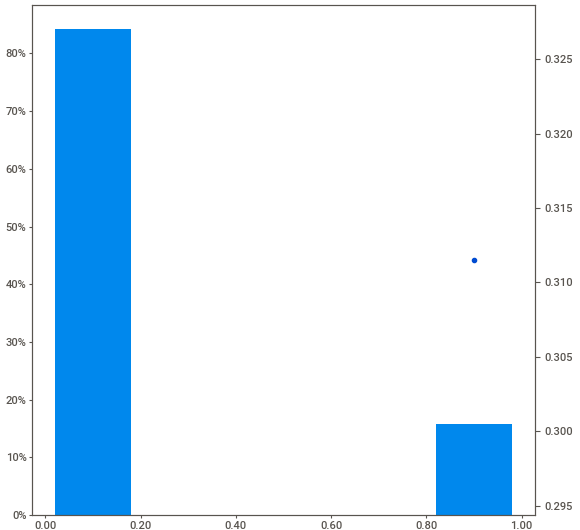
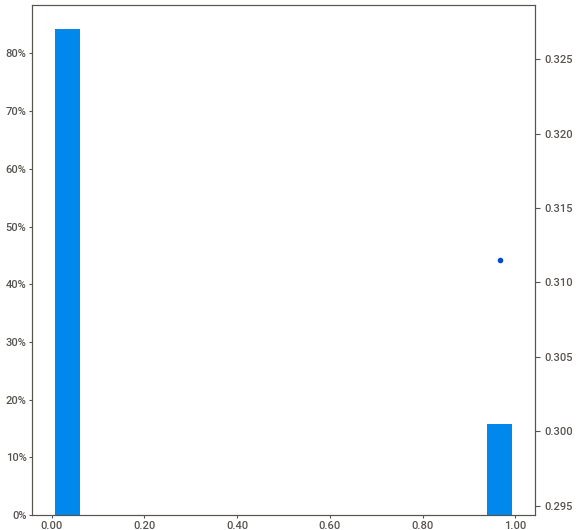
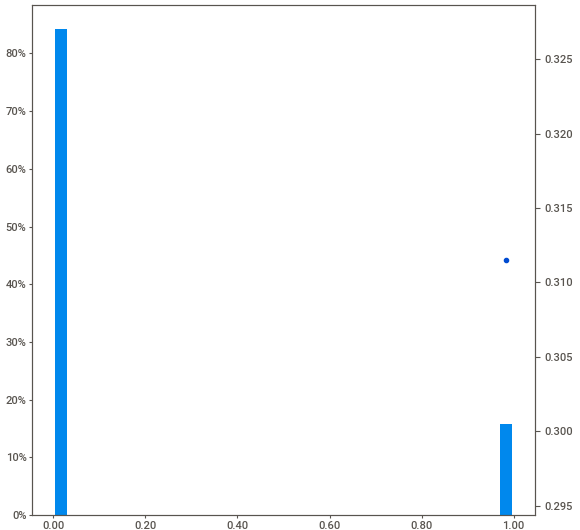
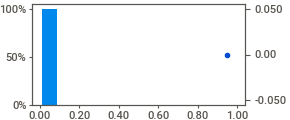
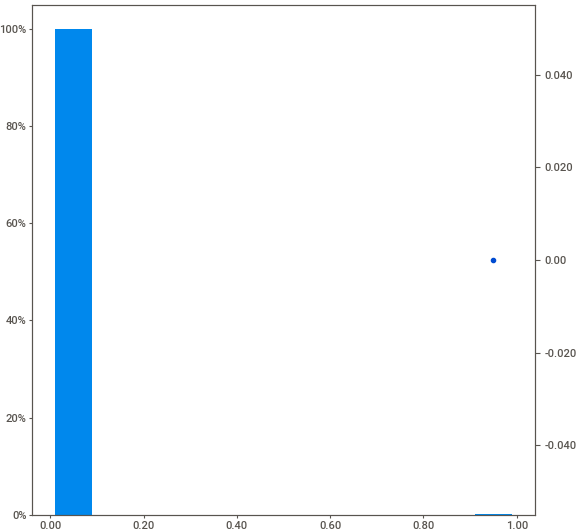
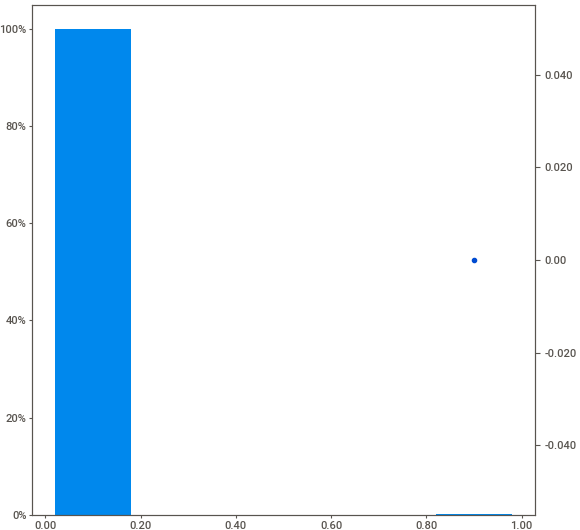
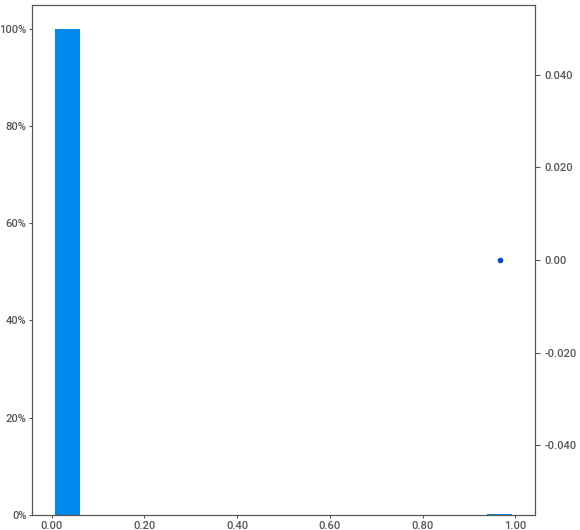
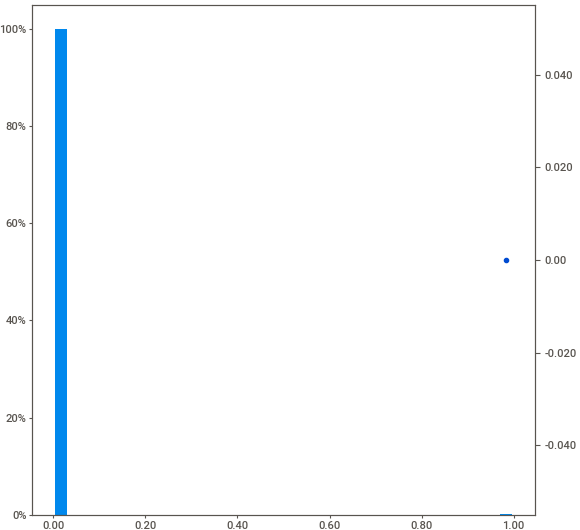
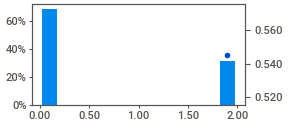
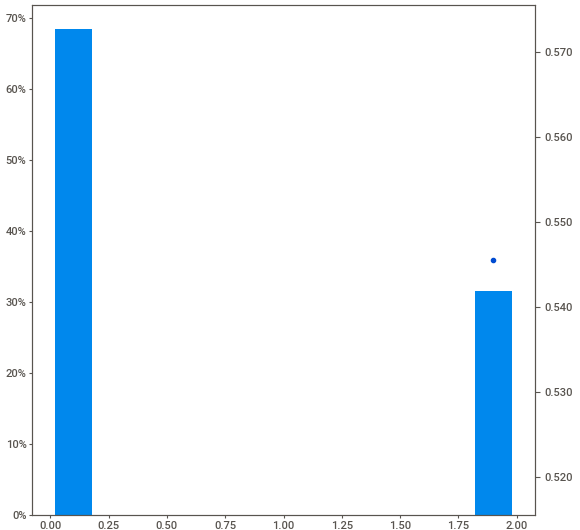
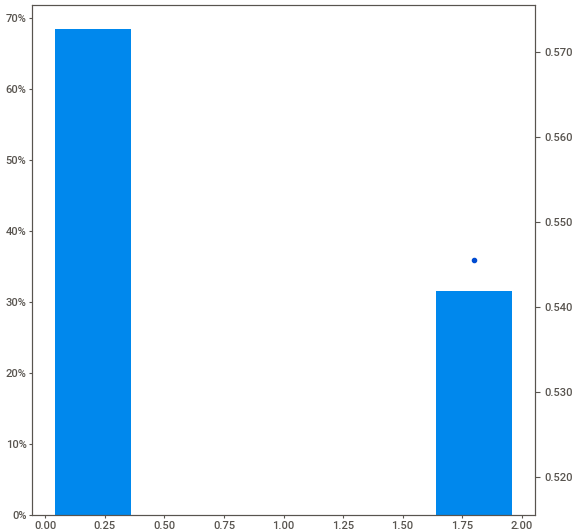
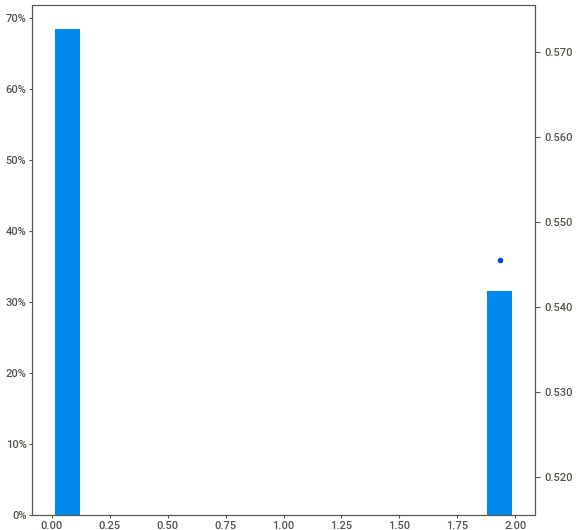
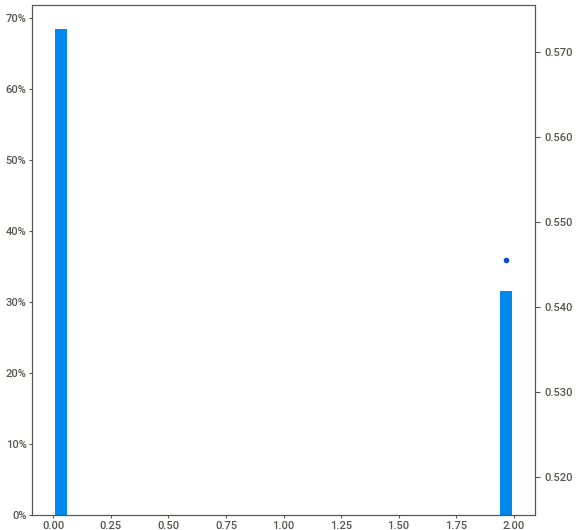
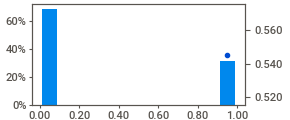
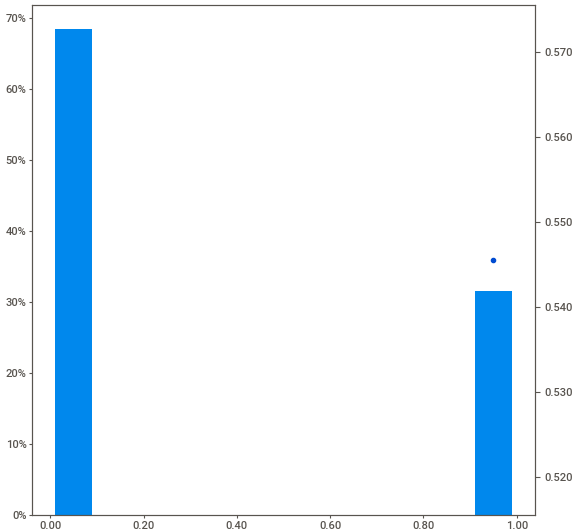
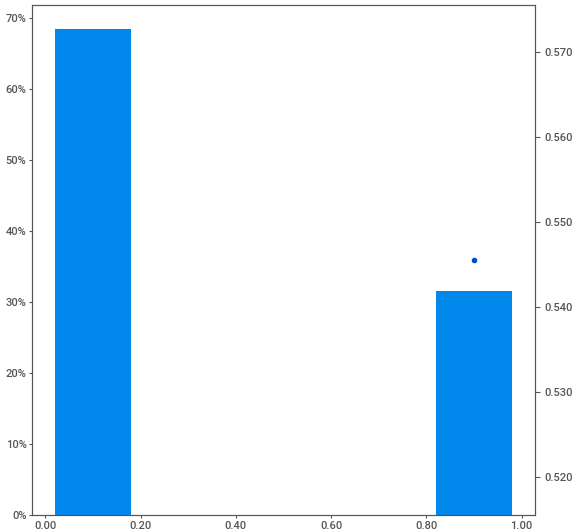
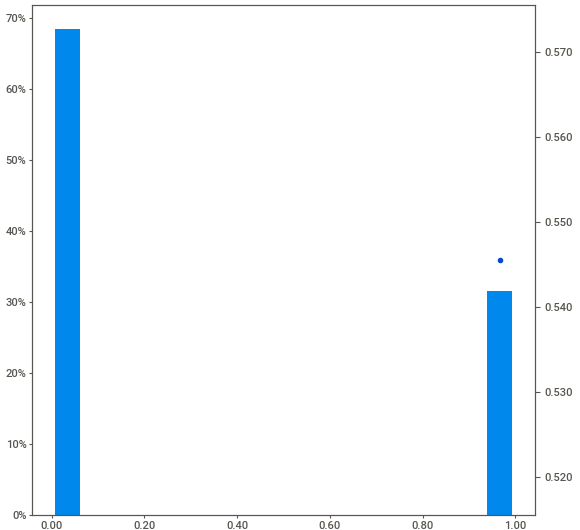
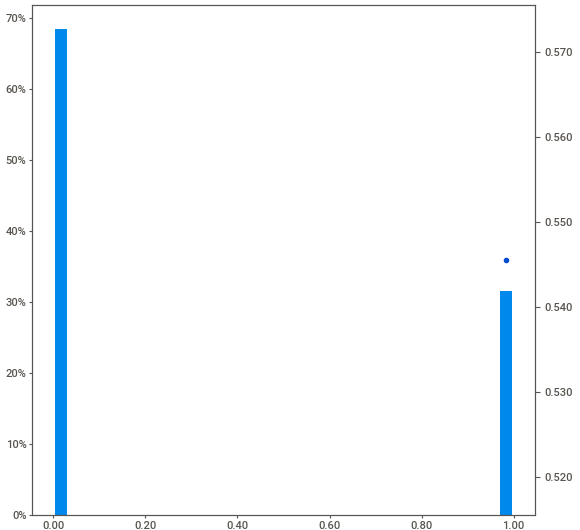
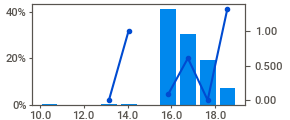
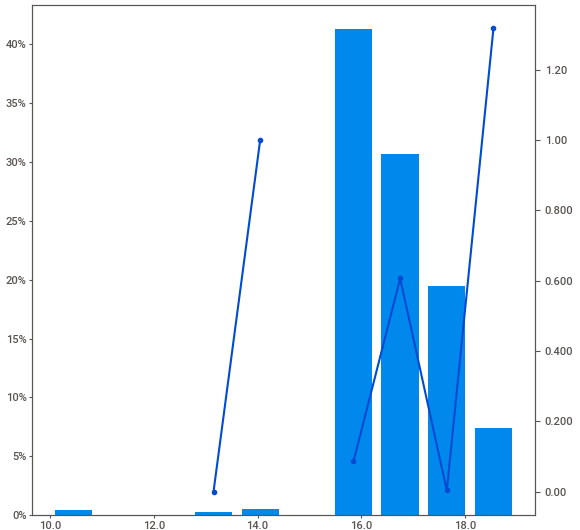
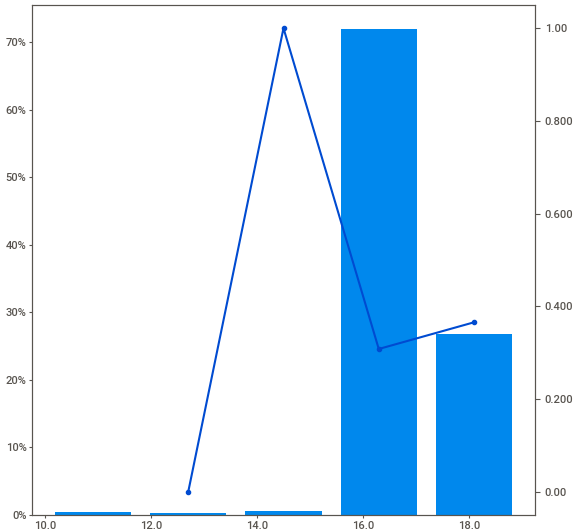
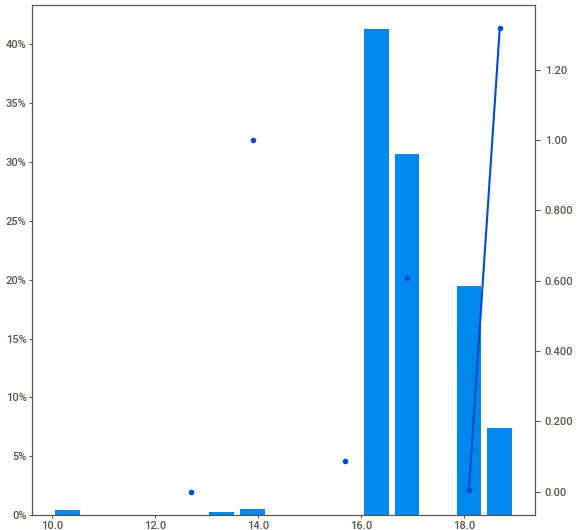
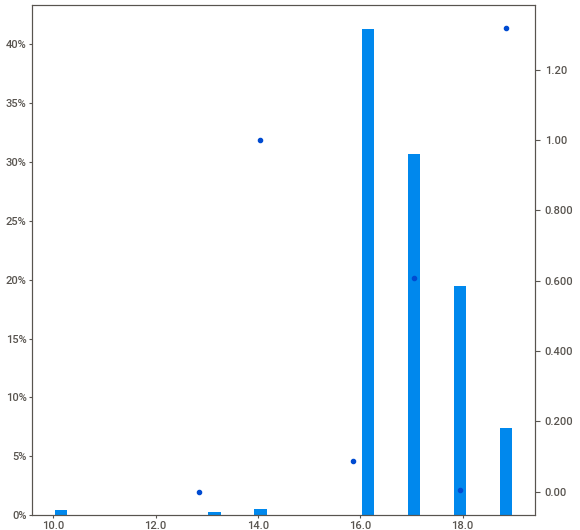
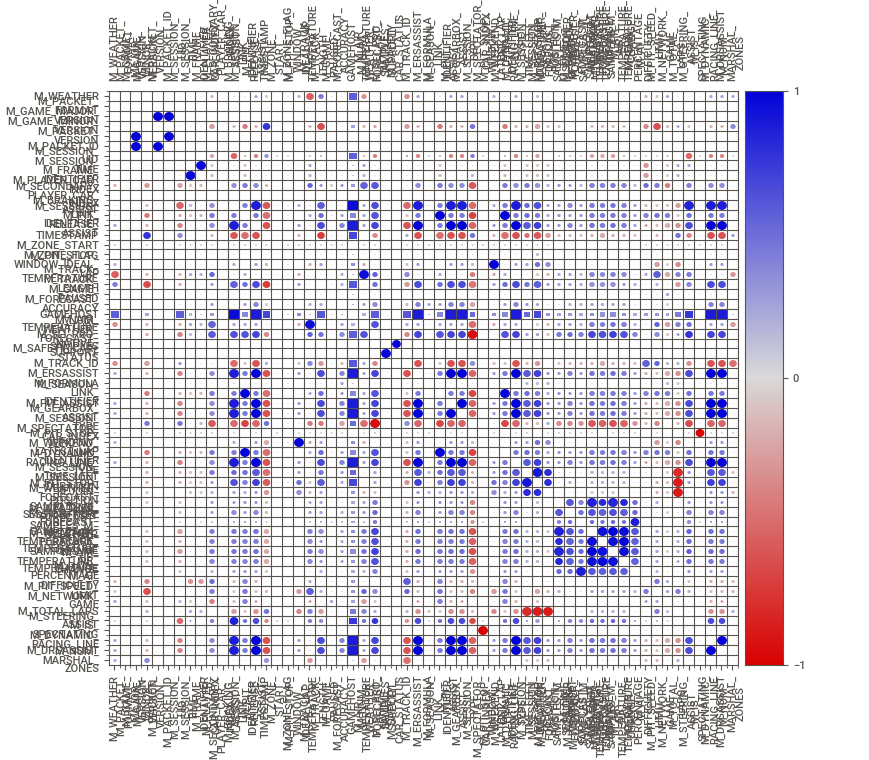
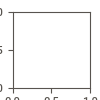

In [22]:
report.show_notebook() # showing the results.

In [23]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42) # splitting data into Train, and Test Data using sklearn library.

In [24]:
def preprocessing(dataframe): #preprocessing and analyzing function to deal with data as timeseries.
    dataframe = dataframe.drop(columns='Unnamed: 58')  # drop unrcorrelated coloumn
    dataframe = dataframe.drop_duplicates() #drop duplicates
    dataframe['Date'] = pd.to_datetime(df['TIMESTAMP'], unit='s') # make a Date coloumn "Date" From "TIMESTAMP" details 
    dataframe['day']=dataframe['Date'].dt.day # make Days coloumn "Day" From "TIMESTAMP" details.
    dataframe['month']=dataframe['Date'].dt.month # make Months coloumn "month" From "TIMESTAMP".
    dataframe['hour']=dataframe['Date'].dt.hour # make Hours coloumn "hour" From "TIMESTAMP".
    dataframe['min']=dataframe['Date'].dt.minute # make minutes coloumn "min" From "TIMESTAMP".
    # dataframe[['Date', 'month', 'day']].groupby(['month', 'day']).count()
    dataframe['time_mins'] = (dataframe['hour'] * 60)  +  dataframe['min'] # time in minutes coloumn to work with the data in minutes, and make predictions more accurate
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.sort_values(by='TIMESTAMP') # sorting values by timestamp, this make the exploration of the weather and races organaizable. 
    
    return dataframe

In [ ]:
df_train = preprocessing(df_train) # applying the preprocessing function functon 
df_train

# input: all timestamp, and group by M_SESSION_UID


the longest time of the session is about two hours, and the minimmum time takes Four minutes.


                                < 0 5 10 15 30 60 > # the time duration steps of prediction the weather and rain percentage as it will be.  
1080    == 18  min  ~~ 20 min 
3600    == 60  min
600     == 10  min
7200    == 120 min
240     == 4   min

In [26]:
df.set_index(['M_SESSION_UID','M_TRACK_ID'])['M_SESSION_TYPE']
df[(df['M_SESSION_UID'] == df['M_SESSION_UID'][3000])]['M_TRACK_ID'].unique()

array([28])

In [30]:
df.groupby(['M_SESSION_UID','M_SESSION_DURATION']).count()

M_PACKET_FORMAT  M_GAME_MAJOR_VERSION  \
M_SESSION_UID M_SESSION_DURATION                                          
2.106082e+16  1080                           7546                  7546   
2.256787e+17  1080                           9625                  9625   
7.316983e+17  1080                          11858                 11858   
7.350151e+17  1080                           5236                  5236   
8.058839e+17  1080                          26873                 26873   
...                                           ...                   ...   
1.776165e+19  1080                           7700                  7700   
1.776466e+19  1080                          13321                 13321   
1.798679e+19  1080                           9856                  9856   
1.802471e+19  7200                            308                   308   
1.826297e+19  600                           14245                 14245   

                                  M_GAME_MINOR_VERSION  M_PACKET_VERSION  \
M_SESSION_UID M_SESSION_DURATION                                           
2.106082e+16  1080                                7546              7546   
2.256787e+17  1080                                9625              9625   
7.316983e+17  1080                               11858             11858   
7.350151e+17  1080                                5236              5236   
8.058839e+17  1080                               26873             26873   
...                                                ...               ...   
1.776165e+19  1080                                7700              7700   
1.776466e+19  1080                               13321             13321   
1.798679e+19  1080                                9856              9856   
1.802471e+19  7200                                 308               308   
1.826297e+19  600                                14245             14245   

                                  M_PACKET_ID  M_SESSION_TIME  \
M_SESSION_UID M_SESSION_DURATION                                
2.106082e+16  1080                       7546            7546   
2.256787e+17  1080                       9625            9625   
7.316983e+17  1080                      11858           11858   
7.350151e+17  1080                       5236            5236   
8.058839e+17  1080                      26873           26873   
...                                       ...             ...   
1.776165e+19  1080                       7700            7700   
1.776466e+19  1080                      13321           13321   
1.798679e+19  1080                       9856            9856   
1.802471e+19  7200                        308             308   
1.826297e+19  600                       14245           14245   

                                  M_FRAME_IDENTIFIER  M_PLAYER_CAR_INDEX  \
M_SESSION_UID M_SESSION_DURATION                                           
2.106082e+16  1080                              7546                7546   
2.256787e+17  1080                              9625                9625   
7.316983e+17  1080                             11858               11858   
7.350151e+17  1080                              5236                5236   
8.058839e+17  1080                             26873               26873   
...                                              ...                 ...   
1.776165e+19  1080                              7700                7700   
1.776466e+19  1080                             13321               13321   
1.798679e+19  1080                              9856                9856   
1.802471e+19  7200                               308                 308   
1.826297e+19  600                              14245               14245   

                                  M_SECONDARY_PLAYER_CAR_INDEX  \
M_SESSION_UID M_SESSION_DURATION                                 
2.106082e+16  1080                                        7546   
2.256787e+17  1080                  

In [31]:
df[df['M_SESSION_UID']==df['M_SESSION_UID'][0]]['M_SESSION_DURATION'].value_counts()

600    96635
Name: M_SESSION_DURATION, dtype: int64

In [33]:
df.columns

Index(['M_PACKET_FORMAT', 'M_GAME_MAJOR_VERSION', 'M_GAME_MINOR_VERSION',
       'M_PACKET_VERSION', 'M_PACKET_ID', 'M_SESSION_UID', 'M_SESSION_TIME',
       'M_FRAME_IDENTIFIER', 'M_PLAYER_CAR_INDEX',
       'M_SECONDARY_PLAYER_CAR_INDEX', 'M_BRAKING_ASSIST',
       'M_SESSION_LINK_IDENTIFIER', 'M_PIT_RELEASE_ASSIST', 'TIMESTAMP',
       'M_ZONE_START', 'M_ZONE_FLAG', 'M_PIT_STOP_WINDOW_IDEAL_LAP',
       'M_TRACK_TEMPERATURE', 'M_TRACK_LENGTH', 'M_GAME_PAUSED',
       'M_FORECAST_ACCURACY', 'GAMEHOST', 'M_AIR_TEMPERATURE',
       'M_NUM_WEATHER_FORECAST_SAMPLES', 'M_SLI_PRO_NATIVE_SUPPORT',
       'M_SAFETY_CAR_STATUS', 'M_TRACK_ID', 'M_ERSASSIST', 'M_FORMULA',
       'M_SEASON_LINK_IDENTIFIER', 'M_PIT_ASSIST', 'M_GEARBOX_ASSIST',
       'M_SESSION_TYPE', 'M_SPECTATOR_CAR_INDEX',
       'M_PIT_STOP_WINDOW_LATEST_LAP', 'M_WEEKEND_LINK_IDENTIFIER',
       'M_DYNAMIC_RACING_LINE_TYPE', 'M_SESSION_TIME_LEFT',
       'M_SESSION_DURATION', 'M_PIT_STOP_REJOIN_POSITION',
       'M_WEATHER_FO

In [32]:
df[(df['M_SESSION_UID']==df['M_SESSION_UID'][0])].groupby(['hour','min']).count()

KeyError: 'hour'

In [ ]:
df[(df['M_SESSION_UID']==df['M_SESSION_UID'][0])].groupby(['hour','min']).count()

In [ ]:
df[(df['M_SESSION_UID']==df['M_SESSION_UID'][0])].groupby(['time_mins']).count()

In [ ]:
# Analysis
for session in list_session: # 153 Sessions
    current_records = df2[df2['M_SESSION_UID']==session]
    x = df2[(df2['M_SESSION_UID']==session)].groupby(['time_mins']).count()
    thelist = x.index
    grplist = [list(group) for group in mit.consecutive_groups(thelist)]
    
    
    M_RAIN_PERCENTAGE_min = current_records[~current_records.iloc[:]["M_RAIN_PERCENTAGE"].isna()]['M_RAIN_PERCENTAGE'].min()
    M_RAIN_PERCENTAGE_max = current_records[~current_records.iloc[:]["M_RAIN_PERCENTAGE"].isna()]['M_RAIN_PERCENTAGE'].max()
    
    M_WEATHER_min = current_records[~current_records.iloc[:]["M_WEATHER"].isna()]['M_WEATHER'].min()
    M_WEATHER_max = current_records[~current_records.iloc[:]["M_WEATHER"].isna()]['M_WEATHER'].max()
    
    print(f'Hi I am in Session: {session}, len(grplist)= {len(grplist)}, DURATION:{current_records.iloc[:]["M_SESSION_DURATION"].min()}, M_WEATHER:({M_WEATHER_min}, {M_WEATHER_max}), M_RAIN_PERCENTAGE: ({M_RAIN_PERCENTAGE_min, M_RAIN_PERCENTAGE_max}), MONTH:{current_records.iloc[0]["month"]}, DAY:{current_records.iloc[0]["day"]}', '='*50)

    for g in grplist:
        print('LENGTH:', len(g))
        print(g)
        print('-'*30)
    print()
    print()    

In [21]:
# session = 1.0606999475394857e+19
# current_records = df[df['M_SESSION_UID']==session]
# df[(df['M_SESSION_UID']==session)].groupby(['TIMESTAMP']).count()

In [22]:
# High_corr = [
# 'M_WEATHER',
# 'M_RAIN_PERCENTAGE',
# 'M_TRACK_ID',
# 'M_TRACK_TEMPERATURE',
# 'M_AIR_TEMPERATURE',
# # 'M_AIR_TEMPERATURE_CHANGE',
# # 'M_TRACK_TEMPERATURE_CHANGE',
# 'M_SESSION_UID',
# 'M_TRACK_LENGTH',
# 'M_PLAYER_CAR_INDEX',
# 'M_AI_DIFFICULTY',
# 'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
# 'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
# 'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE',
# 'M_TIME_OFFSET',
# 'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
# 'M_NUM_WEATHER_FORECAST_SAMPLES',
# 'M_SESSION_TYPE',
# # 'TIMESTAMP'
# 'time_mins'
# ]

In [ ]:
list_session = df_train['M_SESSION_UID'].unique() 
cols = ['M_WEATHER',
 'M_RAIN_PERCENTAGE',
 'M_TRACK_ID',
 'M_AIR_TEMPERATURE',
 'M_TRACK_TEMPERATURE']
N_FUTURE  = 1  # the next prediction 
N_PAST    = 4  # the last 4 sequence in memory to depand on in the prediction. 

def getting_sequences(dataframe): 
    X_sequences = []  # empty list to store the prediction
    y_sequences = [] # empty list to store the N_PAST 

# getting the prediction for each 153 Session
    for session in list_session: # go over the 153 sessions, and drop NAN values in "M_RAIN_PERCENTAGE" coloumn.
        current_records = dataframe[dataframe['M_SESSION_UID'] == session]

        current_records = current_records[~current_records.iloc[:]["M_RAIN_PERCENTAGE"].isna()]

        x_temp = dataframe[(dataframe['M_SESSION_UID']==session)].groupby(['time_mins']).count() # getting the number of sessions grouped by the "time_mins" 
        thelist = x_temp.index
        grplist = [list(group) for group in mit.consecutive_groups(thelist)]  # a group list to use it in seperating the different sessions


        M_RAIN_PERCENTAGE_min = current_records[~current_records.iloc[:]["M_RAIN_PERCENTAGE"].isna()]['M_RAIN_PERCENTAGE'].min() # getting the minimmum value of "M_RAIN_PERCENTAGE" but NOT NAN or zeros
        M_RAIN_PERCENTAGE_max = current_records[~current_records.iloc[:]["M_RAIN_PERCENTAGE"].isna()]['M_RAIN_PERCENTAGE'].max() # getting the maximmum value of "M_RAIN_PERCENTAGE" but NOT NAN or zeros

        M_WEATHER_min = current_records[~current_records.iloc[:]["M_WEATHER"].isna()]['M_WEATHER'].min() # getting the maximmum value of "M_WEATHER"
        M_WEATHER_max = current_records[~current_records.iloc[:]["M_WEATHER"].isna()]['M_WEATHER'].max() # getting the maximmum value of "M_WEATHER"

        # print(f'Hi I am in Session: {session}, len(grplist)= {len(grplist)}, DURATION:{current_records.iloc[:]["M_SESSION_DURATION"].min()}, M_WEATHER:({M_WEATHER_min}, {M_WEATHER_max}), M_RAIN_PERCENTAGE: ({M_RAIN_PERCENTAGE_min, M_RAIN_PERCENTAGE_max}), MONTH:{current_records.iloc[0]["month"]}, DAY:{current_records.iloc[0]["day"]}', '='*50)
        #the way that we seperated the sessions by:
        for g in grplist:           
            if len(g) <= N_PAST:
                continue
            else:
                X_indexes = []
                y_indexes = []
                for i in range(N_PAST, len(g) - N_FUTURE + 1):
                    X_indexes.append(( session, g[i - N_PAST:i]))
                    y_indexes.append(( session, g[i + N_FUTURE - 1:i + N_FUTURE], (M_WEATHER_min, M_WEATHER_max), (M_RAIN_PERCENTAGE_min, M_RAIN_PERCENTAGE_max)))
                X_sequences.extend(X_indexes)
                y_sequences.extend(y_indexes)
    return X_sequences, y_sequences


In [ ]:
def frame_as_supervised_learning(dataframe): # Sequences must be framed as a supervised learning problem
    X_sequences, y_sequences = getting_sequences(dataframe)
    df_new = dataframe.groupby(['M_SESSION_UID', 'time_mins']).max()
    df_new = df_new.reset_index()
    
    # X_sequences[]
    X = [] # Empty list to store the history
    Y = [] # Empty list to store the prediction
    # Features used are ['M_WEATHER', 'M_RAIN_PERCENTAGE', 'M_TRACK_ID', 'M_AIR_TEMPERATURE', 'M_TRACK_TEMPERATURE']

    for x,y in zip(X_sequences, y_sequences): # making a prediction based on a function of the current and previous timesteps.
        X.append( df_new[(df_new['M_SESSION_UID'] == x[0]) & (df_new['time_mins'].isin(x[1]))][cols].to_numpy().astype(float) )
        Y.append(np.array( [y[2][1], y[3][1]]))                                                                                      # y1, y2
        # Y.append( df_new[(df_new['M_SESSION_UID'] == y[0]) & (df_new['time_mins'].isin(y[1]))][cols].to_numpy().astype(float)[0] ) # all sequence
    return np.array(X), np.array(Y)

In [ ]:
g = [1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117] # g represent the races in a one session.


for i in range(N_PAST, len(g) - N_FUTURE + 1):    # make the sequence as to predict the next minute regarding to the previous 4 minutes 
    print(g[i - N_PAST:i], g[i + N_FUTURE - 1:i + N_FUTURE] )   # N_PAST is the past 4 minutes in the sequence, use it to predict the next minute  

In [ ]:
trainX, trainY = frame_as_supervised_learning(df_train)  

print('trainX shape == {}.'.format(trainX.shape)) 
print('trainY shape == {}.'.format(trainY.shape))

In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# Normalize the dataset
train_X_temp = trainX.reshape(-1, trainX.shape[2])
train_X_temp[:, 1] /= 100.

scaler_X = StandardScaler()
# scaler_X = MinMaxScaler()
scaler_X = scaler_X.fit(train_X_temp[:, 3:])

trainX_scaled = scaler_X.transform(train_X_temp[:, 3:])
trainX_scaled = np.hstack([trainX.reshape(-1, trainX.shape[2])[:, :3].reshape(-1,3), trainX_scaled]).reshape(trainX.shape)

train_Y_temp = trainY.copy()
train_Y_temp[:, 1] /= 100.


trainY_weather = to_categorical(trainY[:,0], num_classes=6)
trainY_scaled_all = [trainY_weather, train_Y_temp[:, 1:]]

# MODEL Creation

In [ ]:
model_input = Input(shape=(trainX.shape[1], trainX.shape[2]))    # Shape --> 4,5

x = LSTM(64, activation='relu', return_sequences=True)(model_input)
x = LSTM(32, activation='relu', return_sequences=False)(x)
x = Dropout(0.2)(x)

class_output = Dense(6, activation='softmax', name='class_out')(x)
reg_output   = Dense(1, name='reg_out')(x)

model = Model(inputs=model_input, outputs=[class_output, reg_output])
model.summary()

In [ ]:
model.compile(loss={
                    'class_out' : 'categorical_crossentropy', 
                    'reg_out'   : 'mse'
              },
              metrics={
                    'class_out' : 'accuracy',
                     'reg_out'  : 'mae'
              },
              optimizer='adam')

In [32]:
# fit the model
history = model.fit(trainX_scaled, trainY_scaled_all, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
21/21 [==============================] - 3s 31ms/step - loss: 1.3803 - class_out_loss: 1.2366 - reg_out_loss: 0.1437 - class_out_accuracy: 0.6137 - reg_out_mae: 0.2514 - val_loss: 1.5222 - val_class_out_loss: 1.4714 - val_reg_out_loss: 0.0508 - val_class_out_accuracy: 0.9444 - val_reg_out_mae: 0.2186
Epoch 2/50
21/21 [==============================] - 0s 5ms/step - loss: 1.2138 - class_out_loss: 1.0642 - reg_out_loss: 0.1496 - class_out_accuracy: 0.7882 - reg_out_mae: 0.2625 - val_loss: 1.3539 - val_class_out_loss: 1.3162 - val_reg_out_loss: 0.0377 - val_class_out_accuracy: 0.8889 - val_reg_out_mae: 0.1889
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 0.9843 - class_out_loss: 0.8373 - reg_out_loss: 0.1470 - class_out_accuracy: 0.7913 - reg_out_mae: 0.2732 - val_loss: 0.9724 - val_class_out_loss: 0.9437 - val_reg_out_loss: 0.0287 - val_class_out_accuracy: 0.8889 - val_reg_out_mae: 0.1620
Epoch 4/50
21/21 [==============================] - 0s 5ms/step

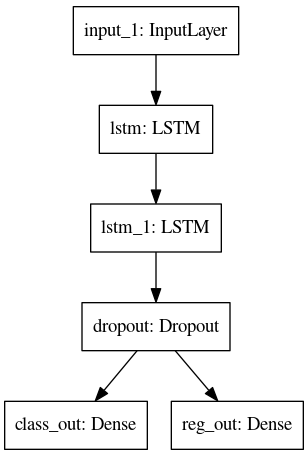

In [33]:
plot_model(model, to_file='model.png')

In [ ]:
history.history.keys()

In [ ]:
# model.save('model.h5')

In [ ]:
loaded_model = load_model('model.h5')

In [ ]:
def output(X_predict):
    dict_output = {}
    keys = ['5', '10', '15', '30', '60']
    s = scaler_X.transform(X_predict[1:].reshape(1,-1))
    new_record = [X_predict[0]] + list(s[0])
    X_predict = np.array([[X_predict] * N_PAST])
    
    for i in range(5, 61, 5):
        y1, y2 = loaded_model.predict(X_predict)
        
        X_predict = np.array([np.argmax(y1), np.round(y2[0][0], 2), np.round(y2[0][1], 2), np.round(y2[0][2], 2)])
        X_predict = np.array([[X_predict] * N_PAST])
        
        if str(i) in keys:
            dict_output[str(i)] = { 'type':np.argmax(y1), str(np.argmax(y1)): np.round(y2[0][0], 2) }
    
    return dict_output

# Testing

In [ ]:
df_test = preprocessing(df_test)
df_test

In [ ]:
testX, testY = frame_as_supervised_learning(df_test)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

In [ ]:
test_X_temp = testX.reshape(-1, testX.shape[2])
test_X_temp[:, 1] /= 100.

testX_scaled = scaler_X.transform(test_X_temp[:, 3:])
testX_scaled = np.hstack([testX.reshape(-1, testX.shape[2])[:, :3].reshape(-1,3), testX_scaled]).reshape(testX.shape)

test_Y_temp = testY.copy()
test_Y_temp[:, 1] /= 100.


testY_weather = to_categorical(testY[:,0], num_classes=6)
testY_scaled_all = [trainY_weather, test_Y_temp[:, 1:]]

# Evaluation

In [ ]:
model.evaluate(trainX_scaled, trainY_scaled_all)

In [ ]:
model.evaluate(testX_scaled, testY_scaled_all)

In [ ]:
def output_scaled(X_predict_scaled):
    dict_output = {}
    keys = ['5', '10', '15', '30', '60']

    X_predict  = np.array([[X_predict_scaled] * N_PAST])
    
    for i in range(5, 61, 5):
        y1, y2 = model.predict(X_predict)
        
        X_predict = np.array([np.argmax(y1), np.round(y2[0][0], 2)] + list(X_predict_scaled[2:]))
        X_predict = np.array([[X_predict] * N_PAST])

        if str(i) in keys:
            dict_output[str(i)] = { 'type':np.argmax(y1), str(np.argmax(y1)): np.round(y2[0][0], 2) }
    
    return dict_output

In [ ]:
print(output_scaled(trainX_scaled[85][0]))


In [ ]:
trainY[85]

In [ ]:
for i in range(len(testX_scaled)):
    print(output_scaled(testX_scaled[i][0]))
    print(i, '='*120)